**Abnormality Detection in Bone X-Rays - MURA Dataset<br>Project 2 in the context of the course Deep Learning of the MSc in Data Science at Athens University of Business and Economics<br>Contributors: Panteleimon Sfakianakis (f3352121) and Alexandros Skondras (f3352119)**

#### Installations-Imports and DataFrames

In [ ]:
pip install keras-tuner --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 133 kB 14.3 MB/s 


In [ ]:
pip install plot_keras_history

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 323 kB 12.2 MB/s 
  Created wheel for plot-keras-history: filename=plot_keras_history-1.1.36-py3-none-any.whl size=9236 sha256=f056439880b9cede7d33d986396730e745448157644bc30a347ba3f04371f94a
  Stored in directory: /root/.cache/pip/wheels/ca/73/ed/41022b42c1d9ce60a8a2ebb71f042c7f895673760404d39fd7
  Created wheel for sanitize-ml-labels: filename=sanitize_ml_labels-1.0.42-py3-none-any.whl size=322677 sha256=d87e2c8ab656a87df169898a1e82b2f1c1d7a585d7c40ee99504bf4b15ae34d4
  Stored in directory: /root/.cache/pip/wheels/97/31/a0/5ddbb26189896b5d23d83b03bf9a74327a8091a610a6375785
  Created wheel for compress-json: filename=compress_json-1.0.7-py3-none-any.whl size=5233 sha256=beba4630c18cc2188140e82b6d264ed07d1ab663991cf6ab4540c2549782fc00
  Stored in directory: /root/.cache/pip/wheels/6d/7e/13/0e370d719528969d430498ca952417324595d116776840b279
Successfu

In [ ]:
pip install tfa-nightly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 14.6 MB/s 


In [ ]:
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np                                                                             
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
from tensorflow.random import set_seed
from tensorflow.keras.utils import to_categorical
import gc
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from tensorflow.keras import backend as K # Importing Keras backend (by default it is Tensorflow)
from tensorflow.keras.layers import Input, Conv2D, Dense, Dropout, Flatten, MaxPool2D # Layers to be used for building our model
from tensorflow.keras.models import Model # The class used to create a model
from tensorflow.keras.optimizers import SGD, Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, plot_confusion_matrix, classification_report, precision_recall_curve, auc, f1_score
import keras_tuner as kt
from keras.layers import LeakyReLU, ELU,BatchNormalization
import warnings
warnings.filterwarnings("ignore")
import pickle
from keras import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns
import tensorflow_addons as tfa
from sklearn.metrics import cohen_kappa_score
from tensorflow import keras
from tensorflow.keras import layers
from keras import models
from keras.models import load_model
from plot_keras_history import plot_history
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.densenet import DenseNet169

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
print(os.getcwd())
os.chdir("drive/MyDrive")
print(os.getcwd())

/content
/content/drive/MyDrive


In [ ]:
# !unzip MURA-v1.1.zip

Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.
   creating: MURA-v1.1/train/XR_SHOULDER/patient01061/
   creating: MURA-v1.1/train/XR_SHOULDER/patient01061/study1_positive/
  inflating: MURA-v1.1/train/XR_SHOULDER/patient01061/study1_positive/image1.png  
  inflating: MURA-v1.1/train/XR_SHOULDER/patient01061/study1_positive/image3.png  
  inflating: MURA-v1.1/train/XR_SHOULDER/patient01061/study1_positive/image2.png  
   creating: MURA-v1.1/train/XR_SHOULDER/patient01016/
   creating: MURA-v1.1/train/XR_SHOULDER/patient01016/study1_positive/
  inflating: MURA-v1.1/train/XR_SHOULDER/patient01016/study1_positive/image1.png  
  inflating: MURA-v1.1/train/XR_SHOULDER/patient01016/study1_positive/image3.png  
  inflating: MURA-v1.1/train/XR_SHOULDER/patient01016/study1_positive/image2.png  
   creating: MURA-v1.1/train/XR_SHOULDER/patient01182/
   creating: MURA-v1.1/train/XR_SHOULDER/patient01182/study1_positive/
  inflating: MURA-v1.1/train/XR_SHOULDER/patient01182/study1_positive

In [ ]:
os.chdir("./MURA-v1.1")
train = pd.read_csv("train_image_paths.csv",header=None)
test = pd.read_csv("valid_image_paths.csv",header=None)
train_labels = pd.read_csv("train_labeled_studies.csv",header=None)
test_labels = pd.read_csv("valid_labeled_studies.csv",header=None)
train.rename(columns={0:"Paths"},inplace =True)
test.rename(columns={0:"Paths"},inplace =True)

train['SetSplit'] = train['Paths'].map(lambda x: x.split('/')[1])
train['Region'] = train['Paths'].map(lambda x: x.split('/')[-4])
train['Patient'] = train['Paths'].map(lambda x: x.split('/')[-3])
train['FolderId'] = train['Paths'].map(lambda x: x.split('/')[-2])
train['ImageNumber'] = train['Paths'].map(lambda x: x.split('/')[-1])
train['Study'] = train['FolderId'].map(lambda x: x.split('_')[0])
train['Label'] = train['FolderId'].map(lambda x: x.split('_')[-1] if '' in x else np.NAN )
train['BooleanLabel'] = train.apply(lambda row: np.where(row.Label == "negative", 0, 1), axis=1)

test['SetSplit'] = test['Paths'].map(lambda x: x.split('/')[1])
test['Region'] = test['Paths'].map(lambda x: x.split('/')[-4])
test['Patient'] = test['Paths'].map(lambda x: x.split('/')[-3])
test['FolderId'] = test['Paths'].map(lambda x: x.split('/')[-2])
test['ImageNumber'] = test['Paths'].map(lambda x: x.split('/')[-1])
test['Study'] = test['FolderId'].map(lambda x: x.split('_')[0])
test['Label'] = test['FolderId'].map(lambda x: x.split('_')[-1] if '' in x else np.NAN )
test['BooleanLabel'] = train.apply(lambda row: np.where(row.Label == "negative", 0, 1), axis=1)

In [ ]:
train

Paths SetSplit  \
0      MURA-v1.1/train/XR_SHOULDER/patient00001/study...    train   
1      MURA-v1.1/train/XR_SHOULDER/patient00001/study...    train   
2      MURA-v1.1/train/XR_SHOULDER/patient00001/study...    train   
3      MURA-v1.1/train/XR_SHOULDER/patient00002/study...    train   
4      MURA-v1.1/train/XR_SHOULDER/patient00002/study...    train   
...                                                  ...      ...   
36803  MURA-v1.1/train/XR_HAND/patient11183/study1_ne...    train   
36804  MURA-v1.1/train/XR_HAND/patient11183/study1_ne...    train   
36805  MURA-v1.1/train/XR_HAND/patient11184/study1_ne...    train   
36806  MURA-v1.1/train/XR_HAND/patient11184/study1_ne...    train   
36807  MURA-v1.1/train/XR_HAND/patient11184/study1_ne...    train   

            Region       Patient         FolderId ImageNumber   Study  \
0      XR_SHOULDER  patient00001  study1_positive  image1.png  study1   
1      XR_SHOULDER  patient00001  study1_positive  image2.png  study1   
2      XR_SHOULDER  patient00001  study1_positive  image3.png  study1   
3      XR_SHOULDER  patient00002  study1_positive  image1.png  study1   
4      XR_SHOULDER  patient00002  study1_positive  image2.png  study1   
...            ...           ...              ...         ...     ...   
36803      XR_HAND  patient11183  study1_negative  image2.png  study1   
36804      XR_HAND  patient11183  study1_negative  image3.png  study1   
36805      XR_HAND  patient11184  study1_negative  image1.png  study1   
36806      XR_HAND  patient11184  study1_negative  image2.png  study1   
36807      XR_HAND  patient11184  study1_negative  image3.png  study1   

          Label BooleanLabel  
0      positive            1  
1      positive            1  
2      positive            1  
3      positive            1  
4      positive            1  
...         ...          ...  
36803  negative            0  
36804  negative            0  
36805  negative            0  
36806  negative            0  
36807  negative            0  

[36808 rows x 9 columns]

In [ ]:
x_train_strat,x_dev_strat,y_train_strat,y_dev_strat = train_test_split(train.loc[:,"Paths"].tolist(),train.loc[:,"Label"].tolist(),
                                                                       test_size=0.2,random_state=123,stratify=train[["Label", "Region"]])

train = pd.DataFrame(x_train_strat)
dev = pd.DataFrame(x_dev_strat)

train.rename(columns={0:"Paths"},inplace =True)
dev.rename(columns={0:"Paths"},inplace =True)
train['SetSplit'] = train['Paths'].map(lambda x: x.split('/')[1])
train['Region'] = train['Paths'].map(lambda x: x.split('/')[-4])
train['Patient'] = train['Paths'].map(lambda x: x.split('/')[-3])
train['FolderId'] = train['Paths'].map(lambda x: x.split('/')[-2])
train['ImageNumber'] = train['Paths'].map(lambda x: x.split('/')[-1])
train['Study'] = train['FolderId'].map(lambda x: x.split('_')[0])
train['Label'] = train['FolderId'].map(lambda x: x.split('_')[-1] if '' in x else np.NAN )
train['BooleanLabel'] = train.apply(lambda row: np.where(row.Label == "negative", 0, 1), axis=1)

dev['SetSplit'] = dev['Paths'].map(lambda x: x.split('/')[1])
dev['Region'] = dev['Paths'].map(lambda x: x.split('/')[-4])
dev['Patient'] = dev['Paths'].map(lambda x: x.split('/')[-3])
dev['FolderId'] = dev['Paths'].map(lambda x: x.split('/')[-2])
dev['ImageNumber'] = dev['Paths'].map(lambda x: x.split('/')[-1])
dev['Study'] = dev['FolderId'].map(lambda x: x.split('_')[0])
dev['Label'] = dev['FolderId'].map(lambda x: x.split('_')[-1] if '' in x else np.NAN )
dev["SetSplit"] = ["dev"]*len(dev.SetSplit)
dev['BooleanLabel'] = train.apply(lambda row: np.where(row.Label == "negative", 0, 1), axis=1)

In [ ]:
train

Paths SetSplit  \
0      MURA-v1.1/train/XR_SHOULDER/patient02504/study...    train   
1      MURA-v1.1/train/XR_WRIST/patient06382/study1_p...    train   
2      MURA-v1.1/train/XR_HAND/patient10611/study1_ne...    train   
3      MURA-v1.1/train/XR_HAND/patient05916/study1_ne...    train   
4      MURA-v1.1/train/XR_WRIST/patient07854/study1_n...    train   
...                                                  ...      ...   
29441  MURA-v1.1/train/XR_FINGER/patient03519/study1_...    train   
29442  MURA-v1.1/train/XR_SHOULDER/patient01284/study...    train   
29443  MURA-v1.1/train/XR_WRIST/patient08731/study1_n...    train   
29444  MURA-v1.1/train/XR_HAND/patient10707/study1_ne...    train   
29445  MURA-v1.1/train/XR_HAND/patient09818/study1_po...    train   

            Region       Patient         FolderId ImageNumber   Study  \
0      XR_SHOULDER  patient02504  study1_negative  image4.png  study1   
1         XR_WRIST  patient06382  study1_positive  image2.png  study1   
2          XR_HAND  patient10611  study1_negative  image3.png  study1   
3          XR_HAND  patient05916  study1_negative  image1.png  study1   
4         XR_WRIST  patient07854  study1_negative  image3.png  study1   
...            ...           ...              ...         ...     ...   
29441    XR_FINGER  patient03519  study1_positive  image1.png  study1   
29442  XR_SHOULDER  patient01284  study1_positive  image1.png  study1   
29443     XR_WRIST  patient08731  study1_negative  image2.png  study1   
29444      XR_HAND  patient10707  study1_negative  image2.png  study1   
29445      XR_HAND  patient09818  study1_positive  image2.png  study1   

          Label BooleanLabel  
0      negative            0  
1      positive            1  
2      negative            0  
3      negative            0  
4      negative            0  
...         ...          ...  
29441  positive            1  
29442  positive            1  
29443  negative            0  
29444  negative            0  
29445  positive            1  

[29446 rows x 9 columns]

In [ ]:
dev

Paths SetSplit       Region  \
0     MURA-v1.1/train/XR_SHOULDER/patient01151/study...      dev  XR_SHOULDER   
1     MURA-v1.1/train/XR_HAND/patient05959/study1_po...      dev      XR_HAND   
2     MURA-v1.1/train/XR_FOREARM/patient09628/study1...      dev   XR_FOREARM   
3     MURA-v1.1/train/XR_WRIST/patient08821/study1_n...      dev     XR_WRIST   
4     MURA-v1.1/train/XR_SHOULDER/patient01669/study...      dev  XR_SHOULDER   
...                                                 ...      ...          ...   
7357  MURA-v1.1/train/XR_FINGER/patient04055/study1_...      dev    XR_FINGER   
7358  MURA-v1.1/train/XR_FINGER/patient02253/study1_...      dev    XR_FINGER   
7359  MURA-v1.1/train/XR_WRIST/patient08741/study1_n...      dev     XR_WRIST   
7360  MURA-v1.1/train/XR_WRIST/patient08868/study1_n...      dev     XR_WRIST   
7361  MURA-v1.1/train/XR_ELBOW/patient05136/study1_p...      dev     XR_ELBOW   

           Patient         FolderId ImageNumber   Study     Label BooleanLabel  
0     patient01151  study1_positive  image4.png  study1  positive            0  
1     patient05959  study1_positive  image4.png  study1  positive            1  
2     patient09628  study1_negative  image2.png  study1  negative            0  
3     patient08821  study1_negative  image1.png  study1  negative            0  
4     patient01669  study1_negative  image4.png  study1  negative            0  
...            ...              ...         ...     ...       ...          ...  
7357  patient04055  study1_negative  image1.png  study1  negative            1  
7358  patient02253  study1_negative  image2.png  study1  negative            0  
7359  patient08741  study1_negative  image1.png  study1  negative            0  
7360  patient08868  study1_negative  image1.png  study1  negative            0  
7361  patient05136  study1_positive  image3.png  study1  positive            1  

[7362 rows x 9 columns]

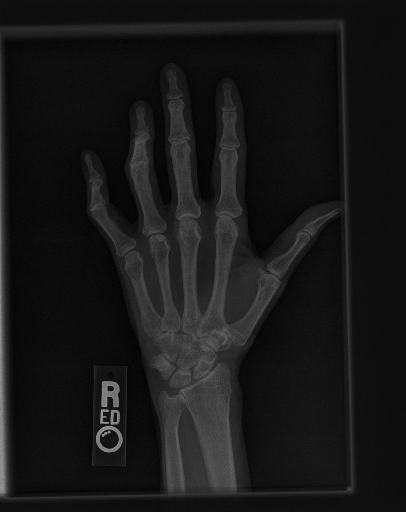

In [ ]:
os.chdir('/content/drive/MyDrive')
#print a random image
index = np.random.randint(train.shape[0] - 1)
Image.open(str(train.loc[10,"Paths"]))

####Class Balance

In [ ]:
count_dict = Counter(train["Region"])
count_dict_dev = Counter(dev["Region"])
#sort the values
count_dict = dict(sorted(count_dict.items(), key=lambda item: item[0]))
count_dict_val = dict(sorted(count_dict_dev.items(), key=lambda item: item[0]))
train_df = pd.DataFrame.from_dict(dict(count_dict), orient='index')
train_df.rename(columns = {0:"Counts"},inplace=True)
train_df["Percentage"] = round(train_df/train_df["Counts"].sum(),3)
val_df = pd.DataFrame.from_dict(dict(count_dict_val), orient='index')
val_df.rename(columns = {0:"Counts"},inplace=True)
val_df["Percentage"] = round(val_df/val_df["Counts"].sum(),3)



print("The class balance for the different body parts for the train set is: \n")
print(train_df)
print("--------------------------------")
print("The class balance for the body parts X-Rays of the dev set is: \n")
print(val_df)
print("--------------------------------")


count_dict = Counter(train["Label"])
count_dict_dev = Counter(dev["Label"])
#sort the values
count_dict = dict(sorted(count_dict.items(), key=lambda item: item[0]))
count_dict_val = dict(sorted(count_dict_dev.items(), key=lambda item: item[0]))
train_df_ = pd.DataFrame.from_dict(dict(count_dict), orient='index')
train_df_.rename(columns = {0:"Counts"},inplace=True)
train_df_["Percentage"] = round(train_df_/train_df_["Counts"].sum(),3)
val_df_ = pd.DataFrame.from_dict(dict(count_dict_val), orient='index')
val_df_.rename(columns = {0:"Counts"},inplace=True)
val_df_["Percentage"] = round(val_df_/val_df_["Counts"].sum(),3)


print("The class balance for the study in train set is: \n")
print(train_df_)
print("--------------------------------")
print("The class balance for the study the dev set is: \n")
print(val_df_)
print("--------------------------------")

The class balance for the different body parts for the train set is: 

             Counts  Percentage
XR_ELBOW       3945       0.134
XR_FINGER      4084       0.139
XR_FOREARM     1460       0.050
XR_HAND        4434       0.151
XR_HUMERUS     1018       0.035
XR_SHOULDER    6703       0.228
XR_WRIST       7802       0.265
--------------------------------
The class balance for the body parts X-Rays of the dev set is: 

             Counts  Percentage
XR_ELBOW        986       0.134
XR_FINGER      1022       0.139
XR_FOREARM      365       0.050
XR_HAND        1109       0.151
XR_HUMERUS      254       0.035
XR_SHOULDER    1676       0.228
XR_WRIST       1950       0.265
--------------------------------
The class balance for the study in train set is: 

          Counts  Percentage
negative   17548       0.596
positive   11898       0.404
--------------------------------
The class balance for the study the dev set is: 

          Counts  Percentage
negative    4387       0.596
positiv

In [ ]:
def split_member(df_set):
  df_elbow = df_set.loc[df_set["Region"] == "XR_ELBOW",]
  df_finger = df_set.loc[df_set["Region"] == "XR_FINGER",]
  df_forearm = df_set.loc[df_set["Region"] == "XR_FOREARM",]
  df_hand = df_set.loc[df_set["Region"] == "XR_HAND",]
  df_humerus = df_set.loc[df_set["Region"] == "XR_HUMERUS",]
  df_shoulder = df_set.loc[df_set["Region"] == "XR_SHOULDER",]
  df_wrist = df_set.loc[df_set["Region"] == "XR_WRIST",]
  return df_elbow, df_finger, df_forearm, df_hand,df_humerus,df_shoulder,df_wrist

In [ ]:
elbow, finger, forearm, hand, humerus, shoulder, wrist = split_member(train)
memb_list = [finger, forearm, hand, humerus, shoulder, wrist]  

In [ ]:
to_concat_df = Counter(elbow["Label"])
#sort the values
to_concat_df = dict(sorted(to_concat_df.items(), key=lambda item: item[0]))
to_concat_df = pd.DataFrame.from_dict(dict(to_concat_df), orient='index')
to_concat_df.rename(columns = {0:"Counts"},inplace=True)
to_concat_df["member"] = [elbow["Region"].iloc[0]]*2
for memb in memb_list:
  count_dict_memb = Counter(memb["Label"])
  #sort the values
  count_dict_memb = dict(sorted(count_dict_memb.items(), key=lambda item: item[0]))
  df_memb = pd.DataFrame.from_dict(dict(count_dict_memb), orient='index')
  
  df_memb.rename(columns = {0:"Counts"},inplace=True)
  df_memb["member"] = [memb["Region"].iloc[0]]*2
  
  df_memb = pd.concat([to_concat_df,df_memb])
  to_concat_df = df_memb
df_memb.reset_index(inplace=True)
df_memb = df_memb.rename(columns = {'index':'case'})
df_memb = df_memb.set_index(["member","case"])

In [ ]:
train_df_memb=df_memb
train_df_memb

Counts
member      case            
XR_ELBOW    negative    2340
            positive    1605
XR_FINGER   negative    2510
            positive    1574
XR_FOREARM  negative     931
            positive     529
XR_HAND     negative    3247
            positive    1187
XR_HUMERUS  negative     539
            positive     479
XR_SHOULDER negative    3369
            positive    3334
XR_WRIST    negative    4612
            positive    3190

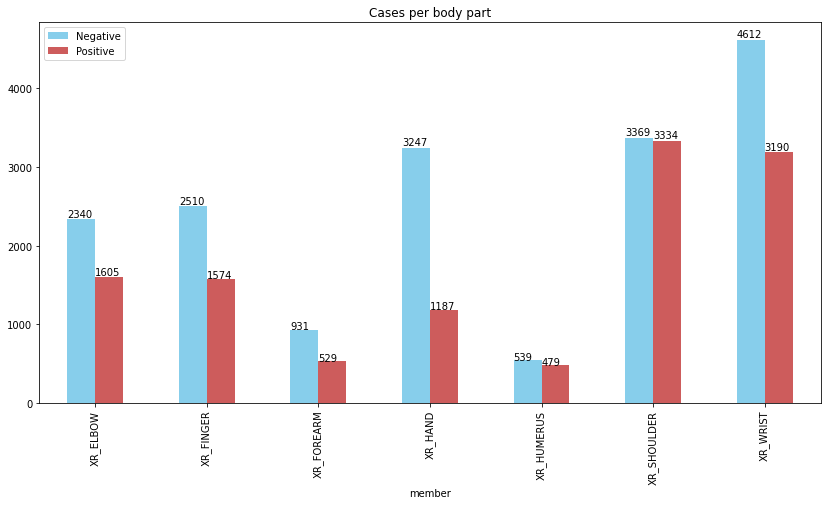

In [ ]:
def plot(df_memb):
  ax = df_memb.unstack().plot(kind="bar",color=["SkyBlue","IndianRed"], rot=90, title="Cases per body part",figsize=(14, 7))
  for p in ax.patches:
      ax.annotate(str(p.get_height()), (p.get_x() * 1.0, p.get_height() * 1.01))
  ax.legend(["Negative", "Positive"]);
plot(train_df_memb)

In [ ]:
elbow_, finger_, forearm_, hand_, humerus_, shoulder_, wrist_ = split_member(dev)
memb_list = [finger_, forearm_, hand_, humerus_, shoulder_, wrist_]  

In [ ]:
to_concat_df = Counter(elbow_["Label"])
#sort the values
to_concat_df = dict(sorted(to_concat_df.items(), key=lambda item: item[0]))
to_concat_df = pd.DataFrame.from_dict(dict(to_concat_df), orient='index')
to_concat_df.rename(columns = {0:"Counts"},inplace=True)
to_concat_df["member"] = [elbow_["Region"].iloc[0]]*2
for memb in memb_list:
  count_dict_memb = Counter(memb["Label"])
  #sort the values
  count_dict_memb = dict(sorted(count_dict_memb.items(), key=lambda item: item[0]))
  df_memb = pd.DataFrame.from_dict(dict(count_dict_memb), orient='index')
  
  df_memb.rename(columns = {0:"Counts"},inplace=True)
  df_memb["member"] = [memb["Region"].iloc[0]]*2
  
  df_memb = pd.concat([to_concat_df,df_memb])
  to_concat_df = df_memb
df_memb.reset_index(inplace=True)
df_memb = df_memb.rename(columns = {'index':'case'})
df_memb = df_memb.set_index(["member","case"])

In [ ]:
dev_df=df_memb
dev_df

Counts
member      case            
XR_ELBOW    negative     585
            positive     401
XR_FINGER   negative     628
            positive     394
XR_FOREARM  negative     233
            positive     132
XR_HAND     negative     812
            positive     297
XR_HUMERUS  negative     134
            positive     120
XR_SHOULDER negative     842
            positive     834
XR_WRIST    negative    1153
            positive     797

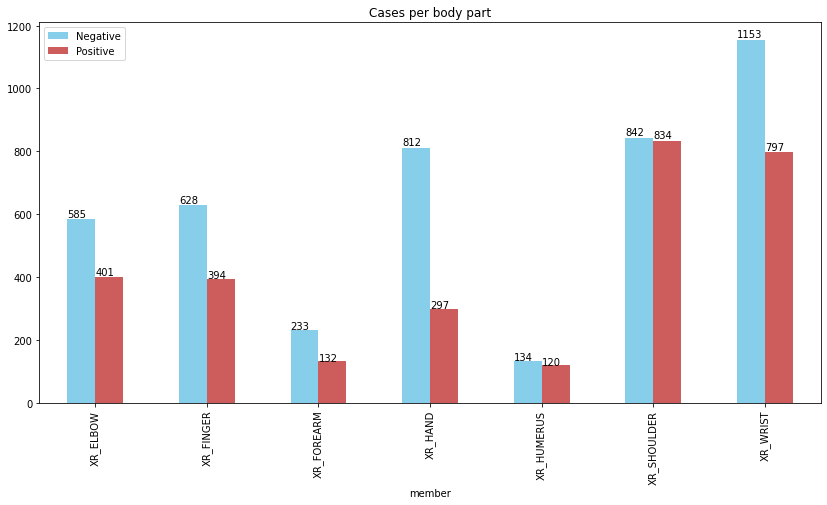

In [ ]:
plot(dev_df)

#### Clean up function

In [ ]:
def clean_up(model):
    K.clear_session()
    del model
    gc.collect()

#### CNN with rotation ONLY of the train set

##### Image Data Generator for the CNN

In [ ]:
train_datagen = ImageDataGenerator(rescale=1/255, rotation_range=30)

train_generator = train_datagen.flow_from_dataframe(dataframe=train, directory=None,
                                              x_col="Paths", y_col="Label",         # 1_hot_labels and categorical
                                              target_size=(224,224), class_mode="binary",
                                              batch_size=128, shuffle=True, color_mode = "rgb", seed=11, fill_mode='constant')

# To discuss
# https://stackoverflow.com/questions/47697622/cnn-image-resizing-vs-padding-keeping-aspect-ratio-or-not
# https://stackoverflow.com/questions/42467734/keras-how-to-use-imagedatagenerator-without-deforming-aspect-ratio
# https://github.com/keras-team/keras/pull/4987

Found 29446 validated image filenames belonging to 2 classes.


In [ ]:
dev_test_datagen = ImageDataGenerator(rescale=1/255)

dev_generator = dev_test_datagen.flow_from_dataframe(dataframe=dev, directory=None,
                                              x_col="Paths", y_col="Label",
                                              target_size=(224,224), class_mode="binary",
                                              batch_size=128, shuffle=False, color_mode = "rgb", seed=11, fill_mode='constant')

test_generator = dev_test_datagen.flow_from_dataframe(dataframe=test, directory=None,
                                              x_col="Paths", y_col="Label",
                                              target_size=(224,224), class_mode="binary",
                                              batch_size=128, shuffle=False, color_mode = "rgb", seed=11, fill_mode='constant')

Found 7362 validated image filenames belonging to 2 classes.
Found 3197 validated image filenames belonging to 2 classes.


##### Metrics and Callbacks

In [ ]:
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
chosen_metrics = [tf.keras.metrics.AUC(name="pr_auc", curve="PR"),
                                                    tf.keras.metrics.AUC(name="roc_auc", curve="ROC"),
                                                    tf.keras.metrics.Precision(name="precision"),
                                                    tf.keras.metrics.Recall(name="recall"),
                                                    tf.keras.metrics.BinaryAccuracy(name="binary_acc"),
                                                        tf.keras.metrics.TruePositives(name="tp"),
                                                    tf.keras.metrics.FalsePositives(name="fp"),
                                                    tf.keras.metrics.TrueNegatives(name="tn"),
                                                    tf.keras.metrics.FalseNegatives(name="fn"),
                                                    tfa.metrics.CohenKappa(name="cohen_kappa", num_classes=2),
                                                        f1]

In [ ]:
callbacks = [ReduceLROnPlateau(monitor="val_loss", patience=2, cooldown=2), 
        EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=5, restore_best_weights=True)]
                                                                          # If False, the model weights obtained at the last step of training are used.
                                                                          # else, restores weights from the best epoch in that set.

##### Tuning

In [ ]:
def build_a_model(hp):

  input = Input(shape = (224,224,1), name='cnn_Input')
  x = input

# Define the convolutional layers.
  for i in range(hp.Int('CNN_layers', 1, 2)):
    hidden_activ = hp.Choice("hidden_activ", ["LeakyReLU", "ELU"])
    if hidden_activ == "LeakyReLU":
      with hp.conditional_scope("hidden_activ", ["LeakyReLU"]):
        x = Conv2D(                                                       # data_format = channels_last (default)
            filters=hp.Choice('conv_filter_'+str(i), [64,128]),
                                                                          # it is common for a CNN to learn  from 32 to 512 filters

            kernel_size=hp.Choice('conv_kernel_'+str(i), values = [3,5]),
            strides=hp.Choice('strides_'+str(i), values = [1]),  # this is unnecessary because it is usually used to make it quicker, in case of too much data
            padding='same',
            dilation_rate=hp.Choice('dil_rate_'+str(i), values=[1]),
            # could change the rate using for example: values = [1,2]
            # https://github.com/transcranial/keras-js/issues/79

            activation=LeakyReLU(hp.Float('cnn_leaky_'+str(i), 0, 0.4)),
            name='cnn_hidden_layer_'+str(i))(x)
    else:
      with hp.conditional_scope("hidden_activ", ["ELU"]):
        x = Conv2D(
            filters= hp.Choice('conv_filter_'+str(i), [64,128]),
            kernel_size=hp.Choice('conv_kernel_'+str(i), values = [3,5]),
            strides=hp.Choice('strides_'+str(i), values = [1]),
            padding='same',
            dilation_rate=hp.Choice('dil_rate_'+str(i), values = [1]),
            activation=ELU(hp.Float('cnn_elu_'+str(i), 0, 0.4)),
            name='cnn_hidden_layer_'+str(i))(x)

    if hp.Boolean("batch_norm_"+str(i)):  
      x=BatchNormalization()(x)
    # Makes every activation zero-mean and unit-variance per batch

    x = MaxPool2D(
            pool_size=hp.Choice('pool_size_'+str(i), values = [2]),
            strides=hp.Choice('max_strides'+str(i), values = [2]),
            padding='same',
            name='MaxPool'+str(i))(x)
    
    
    x = Dropout(hp.Float('cnn_drop_rate_'+str(i), 0, 0.4))(x)

  x = Flatten(name='Flatten')(x)
  
  # Define the output layer.
  output = Dense(
      units = 1,   # 1 output the probability of being abnormal
      kernel_initializer = hp.Choice('cnn_output_init', ['glorot_uniform']),
      activation = 'sigmoid',
      name = 'cnn_output')(x)

  # Define the model and train it.
  model = Model(inputs = input, outputs = output)
  model.compile(optimizer = Adam(lr=hp.Float("cnn_Adam_lr",0.001,0.01)),
                loss='binary_crossentropy', metrics=chosen_metrics)
  
  return model

In [ ]:
tuner2 = kt.BayesianOptimization(
    build_a_model,
    objective='val_loss', seed = 112, overwrite = True, max_trials = 10) #kt.Objective("val_binary_acc", direction = "max")
                                                                                # from tf.keras.metrics import binary_accuracy
                                                                                # val_loss
                                                                                # kt.Objective("val_cohen_kappa", direction="max")

In [ ]:
tuner2.search(train_generator, epochs = 10, callbacks = callbacks, validation_data=dev_generator,batch_size = 128)

##### Fixing an architecture

In [ ]:
# BatchNorm with Dropout - Is it a good practice?
# https://machinelearningmastery.com/batch-normalization-for-training-of-deep-neural-networks/

input = Input(shape = (224,224,3), name='cnn_Input')
x = input

x = Conv2D(filters=64,kernel_size=3,strides=1,padding='same',dilation_rate=1,activation='ELU',name='conv_0')(x)
x=BatchNormalization()(x)
x = MaxPool2D(pool_size=2,strides=2,padding='same',name='max_pool_0')(x)
# x = Dropout(0.2)(x)

x = Conv2D(filters=128,kernel_size=3,strides=1,padding='same',dilation_rate=1,activation='ELU',name='conv_1')(x)
x=BatchNormalization()(x)
x = MaxPool2D(pool_size=2,strides=2,padding='same',name='max_pool_1')(x)
x = Dropout(0.25, name='dropout_1')(x)

x = Conv2D(filters=256,kernel_size=3,strides=1,padding='same',dilation_rate=1,activation='ELU',name='conv_2')(x)
x=BatchNormalization()(x)
x = MaxPool2D(pool_size=2,strides=2,padding='same',name='max_pool_2')(x)
# x = Dropout(0.4)(x)

x = Conv2D(filters=512,kernel_size=3,strides=1,padding='same',dilation_rate=1,activation='ELU',name='conv_3')(x)
x=BatchNormalization()(x)
x = MaxPool2D(pool_size=2,strides=2,padding='same',name='max_pool_3')(x)
x = Dropout(0.35, name='dropout_3')(x)


x = Flatten(name='Flatten')(x)

# Define the output layer.

x = Dense(
    units = 256,
    kernel_initializer = 'glorot_uniform',
    activation = 'relu',
    name = 'cnn_mlp_layer_1')(x)

x = Dense(
    units = 128,
    kernel_initializer = 'glorot_uniform',
    activation = 'relu',
    name = 'cnn_mlp_layer_2')(x)

output = Dense(
    units = 1,   # 1 output the probability of being abnormal
    kernel_initializer = 'glorot_uniform',
    activation = 'sigmoid',
    name = 'cnn_output')(x)

# Define the model and train it.
model = Model(inputs = input, outputs = output)
model.compile(optimizer = 'Adam',
              loss='binary_crossentropy', metrics=chosen_metrics)

In [ ]:
model_CNN = model.fit(train_generator, epochs=15, callbacks=callbacks, validation_data=dev_generator, batch_size = 128)

Epoch 1/15
231/231 [==============================] - 591s 2s/step - loss: 1.4102 - pr_auc: 0.4455 - roc_auc: 0.5624 - precision: 0.4596 - recall: 0.4133 - binary_acc: 0.5666 - tp: 4917.0000 - fp: 5782.0000 - tn: 11766.0000 - fn: 6981.0000 - cohen_kappa: 0.0851 - f1: 0.4087 - val_loss: 0.9148 - val_pr_auc: 0.4565 - val_roc_auc: 0.5535 - val_precision: 0.4945 - val_recall: 0.0151 - val_binary_acc: 0.5958 - val_tp: 45.0000 - val_fp: 46.0000 - val_tn: 4341.0000 - val_fn: 2930.0000 - val_cohen_kappa: 0.0055 - val_f1: 0.0286 - lr: 0.0010
Epoch 2/15
231/231 [==============================] - 543s 2s/step - loss: 0.6947 - pr_auc: 0.4925 - roc_auc: 0.6056 - precision: 0.5056 - recall: 0.3882 - binary_acc: 0.5994 - tp: 4619.0000 - fp: 4517.0000 - tn: 13031.0000 - fn: 7279.0000 - cohen_kappa: 0.1359 - f1: 0.4013 - val_loss: 0.7749 - val_pr_auc: 0.4790 - val_roc_auc: 0.6053 - val_precision: 0.4439 - val_recall: 0.8615 - val_binary_acc: 0.5079 - val_tp: 2563.0000 - val_fp: 3211.0000 - val_tn: 1176

INFO:tensorflow:Assets written to: saved_model/MURA_CNN_with_small_MLP_new/assets


INFO:tensorflow:Assets written to: saved_model/MURA_CNN_with_small_MLP_new/assets


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cnn_Input (InputLayer)      [(None, 224, 224, 3)]     0         
                                                                 
 conv_0 (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 64)     256       
 ormalization)                                                   
                                                                 
 max_pool_0 (MaxPooling2D)   (None, 112, 112, 64)      0         
                                                                 
 conv_1 (Conv2D)             (None, 112, 112, 128)     73856     
                                                                 
 batch_normalization_1 (Batc  (None, 112, 112, 128)    512       
 hNormalization)                                             

In [ ]:
# !mkdir -p saved_model
# model.save('saved_model/MURA_CNN_with_small_MLP_new')

# with open('MURA_CNN_with_small_MLP_history_dict_new.pkl', 'wb') as file_pi:
#      pickle.dump(model_CNN.history, file_pi, pickle.HIGHEST_PROTOCOL)

INFO:tensorflow:Assets written to: saved_model/MURA_CNN_with_small_MLP/assets


INFO:tensorflow:Assets written to: saved_model/MURA_CNN_with_small_MLP/assets


In [ ]:
MURA_CNN = load_model('saved_model/MURA_CNN_with_small_MLP_new', custom_objects={'f1':f1})
model_CNN_history = pickle.load(open('MURA_CNN_with_small_MLP_history_dict_new.pkl','rb'))   # history of the model

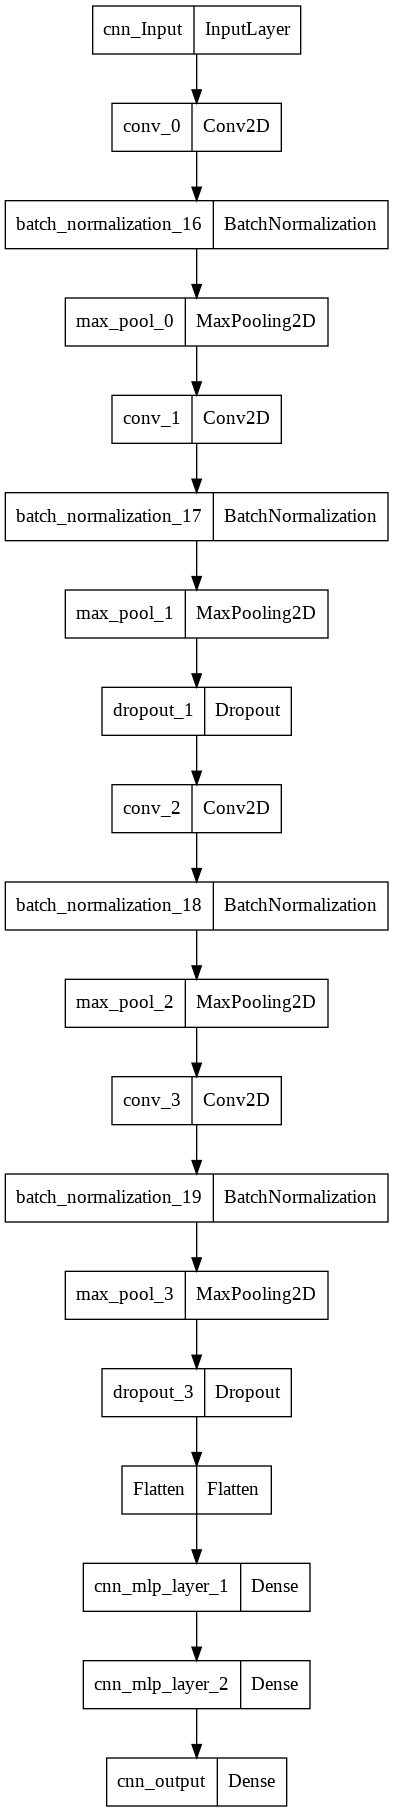

In [ ]:
tf.keras.utils.plot_model(MURA_CNN)

##### Learning Curves

In [ ]:
def plot_learning_curves(history_of_model, list_of_sets, state_of_pretrained, model_type):   # eg ['Train', 'Val']
  first_list = [0,0,1,1]
  second_list = [0,1,0,1]
  metrics_for_learning_curves_list = ['loss', 'cohen_kappa', 'precision', 'recall']

  fig, axs = plt.subplots(2, 2, figsize=(15,16))
  epoch = np.arange(1,len(history_of_model['precision'])+1)

  k = 0
  for i, j in zip(first_list, second_list):
    axs[i,j].plot(epoch,history_of_model[metrics_for_learning_curves_list[k]])
    axs[i,j].plot(epoch,history_of_model[f'val_{metrics_for_learning_curves_list[k]}'])
    axs[i,j].set_title(model_type + f'{metrics_for_learning_curves_list[k]}' + state_of_pretrained, fontsize=17) # 'CNN - '
    axs[i,j].set_ylabel(f'{metrics_for_learning_curves_list[k]}', fontsize=15)
    axs[i,j].set_xlabel('Epochs', fontsize=15)
    axs[i,j].legend(list_of_sets, fontsize = 15)
    axs[i,j].set_xticks(epoch)
    # axs[i,j].grid(visible=True, which='major', axis='y')
    axs[i,j].grid(visible=True, which='major', axis='y', linestyle= '--')

    k += 1

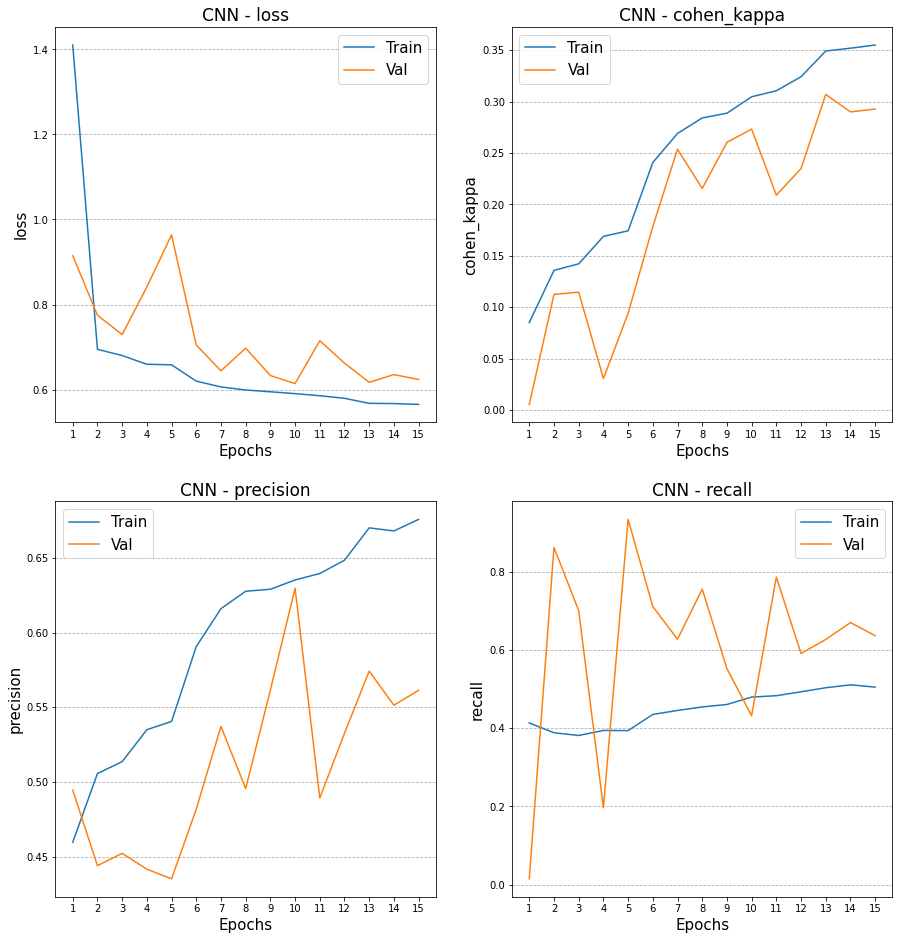

In [ ]:
plot_learning_curves(model_CNN_history, ['Train', 'Val'], '', 'CNN - ')

##### Evaluation Metrics for all body regions together

In [ ]:
def eval_metrics(models_list, generators_list, set_type_list, chosen_metrics, flag_for_conf_matrix):

  for model in models_list:
    for generator, set_type in zip(generators_list, set_type_list):

      evaluation_metrics = model.evaluate(generator, verbose=0)

      print(f'Metrics for the {set_type} set:')

      loss = evaluation_metrics.pop(0)
      print(f"loss        : {loss}")

      f1_score = evaluation_metrics.pop(-1)
      print(f"f1          : {f1_score}")

      for metric, score in zip(chosen_metrics[:-1], evaluation_metrics):
          print(f"{metric.name + ' ' * (12 - len(metric.name))}: {score}")

      if flag_for_conf_matrix == True:

        probs_belong_to_class_1 = model.predict(generator)

        # for g in range(len(probs_belong_to_class_1)):
        #   if probs_belong_to_class_1[g][0] == 0.5:
        #     probs_belong_to_class_1[g][0] = 1      # THIS does NOT solve the problem, so it must be the Shuffle=True parameter

        y_true = generator.classes

        label_names = ['Normal', 'Abnormal']
        cm = confusion_matrix(y_true, np.round(probs_belong_to_class_1).astype("int32")) #df['BooleanLabel'].tolist() # np.round(probs_belong_to_class_1).astype("int32")
        plt.figure(figsize=((11,8.5)))
        ax = sns.heatmap(cm, annot=True, cmap='viridis', fmt='g', xticklabels=label_names, yticklabels=label_names)

        ax.set_title('MURA Confusion Matrix - {}\n\n'.format(set_type), size=15.5)
        ax.set_xlabel('\nPredicted Labels', size=13.5)
        ax.set_ylabel('Actual Labels ', size=13.5)
        sns.set(font_scale=1)
        ax.set_xticklabels(label_names, size = 12, rotation=45)
        ax.set_yticklabels(label_names, size = 12)

        # Display the visualization of the Confusion Matrix.
        plt.show()

In [ ]:
eval_metrics([MURA_CNN], [train_generator], ['train'], chosen_metrics, False)

Metrics for the train set:
loss        : 0.600164532661438
f1          : 0.4241575002670288
pr_auc      : 0.6447675228118896
roc_auc     : 0.7197316288948059
precision   : 0.7092034220695496
recall      : 0.308287113904953
binary_acc  : 0.6694287657737732
tp          : 3668.0
fp          : 1504.0
tn          : 16044.0
fn          : 8230.0
cohen_kappa : 0.24486351013183594


Metrics for the development set:
loss        : 0.6142418384552002
f1          : 0.509791910648346
pr_auc      : 0.6297128200531006
roc_auc     : 0.709082841873169
precision   : 0.6297204494476318
recall      : 0.43159663677215576
binary_acc  : 0.6677533388137817
tp          : 1284.0
fp          : 755.0
tn          : 3632.0
fn          : 1691.0
cohen_kappa : 0.2733369469642639


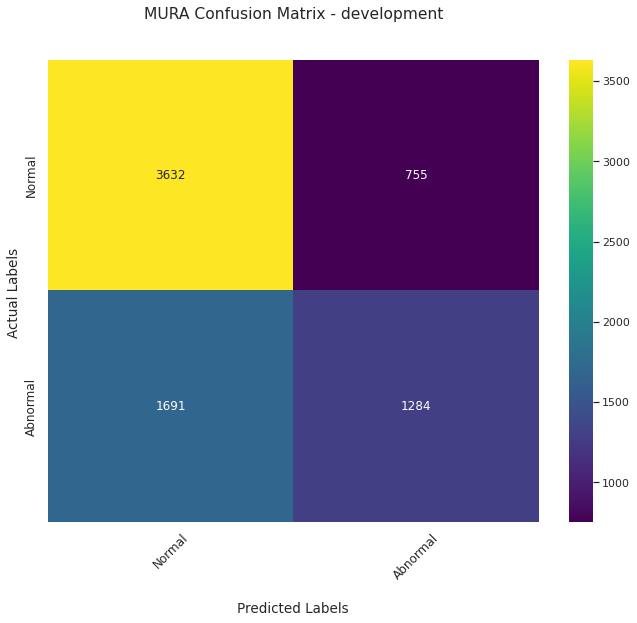

In [ ]:
eval_metrics([MURA_CNN], [dev_generator], ['development'], chosen_metrics, True)

Metrics for the test set:
loss        : 0.675615668296814
f1          : 0.3811098039150238
pr_auc      : 0.6623557806015015
roc_auc     : 0.6769608855247498
precision   : 0.6831228733062744
recall      : 0.3888888955116272
binary_acc  : 0.6212073564529419
tp          : 595.0
fp          : 276.0
tn          : 1391.0
fn          : 935.0
cohen_kappa : 0.22734570503234863


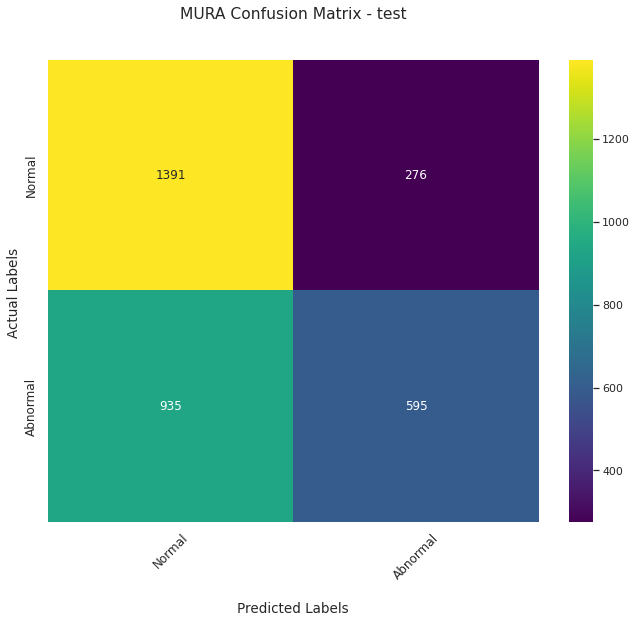

In [ ]:
eval_metrics([MURA_CNN], [test_generator], ['test'], chosen_metrics, True)

##### Specific metrics of interest<br> for each body region separately

In [ ]:
def report(set_type_df, set_type, choose_color_mode, model, datagen, chosen_metrics):

  body_parts_list = ["XR_ELBOW", "XR_FINGER", "XR_FOREARM", "XR_HAND", "XR_HUMERUS", "XR_SHOULDER", "XR_WRIST"]
  elbow, finger, forearm, hand, humerus, shoulder, wrist = split_member(set_type_df)
  df_body_parts_list = [elbow, finger, forearm, hand, humerus, shoulder, wrist]

  for i in range(len(body_parts_list)):
    generator = datagen.flow_from_dataframe(dataframe=split_member(set_type_df)[i], directory=None,
                                                x_col="Paths", y_col="Label",
                                                target_size=(224,224), class_mode="binary",
                                                batch_size=128, shuffle=False, color_mode = choose_color_mode, seed=11, fill_mode='constant')
                                                # shuffle = False to have the same order of data as the dataframes created in the start

    print('\n')
    print('\033[1m{:10s}\033[0m'.format(body_parts_list[i]))                     # to make the body part bold
    print('\n')

    eval_metrics([model], [generator], [set_type], chosen_metrics, False)

    y_true = generator.classes

    probs_belong_to_class_1 = model.predict(generator)
    probs_belong_to_class_0 = 1-probs_belong_to_class_1
    predict_proba_preds = np.concatenate((probs_belong_to_class_0, probs_belong_to_class_1), axis = 1)

    print(f"\nPrecision, recall, F1 scores for each class({set_type} set)")

    print(classification_report(y_true, np.round(probs_belong_to_class_1).astype("int32"), labels=np.array([0,1]),
                                target_names=['Normal','Abnormal']))

    print(f"\nPrecision Recall AUC score for the normal class({set_type} set):")
    precision, recall, thresholds = precision_recall_curve(y_true, predict_proba_preds[:,0],pos_label=0)
    area_train_1 = auc(recall, precision)
    print(area_train_1)
    print(f"\nPrecision Recall AUC score for the abnormal class({set_type} set):")
    precision, recall, thresholds = precision_recall_curve(y_true, predict_proba_preds[:,1],pos_label=1)
    area_train_2 = auc(recall, precision)
    print(area_train_2)
    print(f"\nMacro-averaged Precision Recall AUC score for the {set_type} set:")
    print((area_train_1+area_train_2)/2)

    label_names = ['Normal', 'Abnormal']
    cm = confusion_matrix(y_true, np.round(probs_belong_to_class_1).astype("int32")) # y_true = generator.classes # df_body_parts_list[i]['BooleanLabel'].tolist()
    plt.figure(figsize=((11,8.5)))
    ax = sns.heatmap(cm, annot=True, cmap='viridis', fmt='d', xticklabels=label_names, yticklabels=label_names)

    ax.set_title('MURA Confusion Matrix - {}\n\n'.format(body_parts_list[i]), size=15.5)
    ax.set_xlabel('\nPredicted Labels', size=13.5)
    ax.set_ylabel('Actual Labels ', size=13.5)
    sns.set(font_scale=1)
    ax.set_xticklabels(label_names, size = 12, rotation=45)
    ax.set_yticklabels(label_names, size = 12)

    # Display the visualization of the Confusion Matrix.
    plt.show()

    print('\n\n')
    print('========================================================================================')

Found 3945 validated image filenames belonging to 2 classes.


XR_ELBOW  


Metrics for the train set:
loss        : 0.6327711343765259
f1          : 0.33729755878448486
pr_auc      : 0.590357780456543
roc_auc     : 0.6737624406814575
precision   : 0.6998050808906555
recall      : 0.22367601096630096
binary_acc  : 0.64512038230896
tp          : 359.0
fp          : 154.0
tn          : 2186.0
fn          : 1246.0
cohen_kappa : 0.17675048112869263

Precision, recall, F1 scores for each class(train set)
              precision    recall  f1-score   support

      Normal       0.64      0.94      0.76      2340
    Abnormal       0.72      0.22      0.34      1605

    accuracy                           0.65      3945
   macro avg       0.68      0.58      0.55      3945
weighted avg       0.67      0.65      0.59      3945


Precision Recall AUC score for the normal class(train set):
0.7349427934512875

Precision Recall AUC score for the abnormal class(train set):
0.5946232888966632

Macro

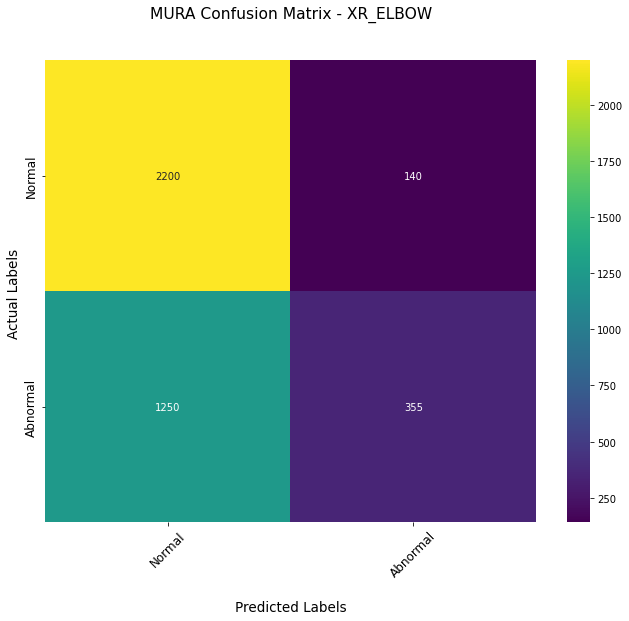




Found 4084 validated image filenames belonging to 2 classes.


XR_FINGER 


Metrics for the train set:
loss        : 0.5693832039833069
f1          : 0.43890121579170227
pr_auc      : 0.6526044607162476
roc_auc     : 0.74725741147995
precision   : 0.7096773982048035
recall      : 0.32147395610809326
binary_acc  : 0.6878060698509216
tp          : 506.0
fp          : 207.0
tn          : 2303.0
fn          : 1068.0
cohen_kappa : 0.2661491632461548

Precision, recall, F1 scores for each class(train set)
              precision    recall  f1-score   support

      Normal       0.68      0.91      0.78      2510
    Abnormal       0.67      0.31      0.43      1574

    accuracy                           0.68      4084
   macro avg       0.68      0.61      0.60      4084
weighted avg       0.68      0.68      0.64      4084


Precision Recall AUC score for the normal class(train set):
0.8218029806004287

Precision Recall AUC score for the abnormal class(train set):
0.6494540428061022

Ma

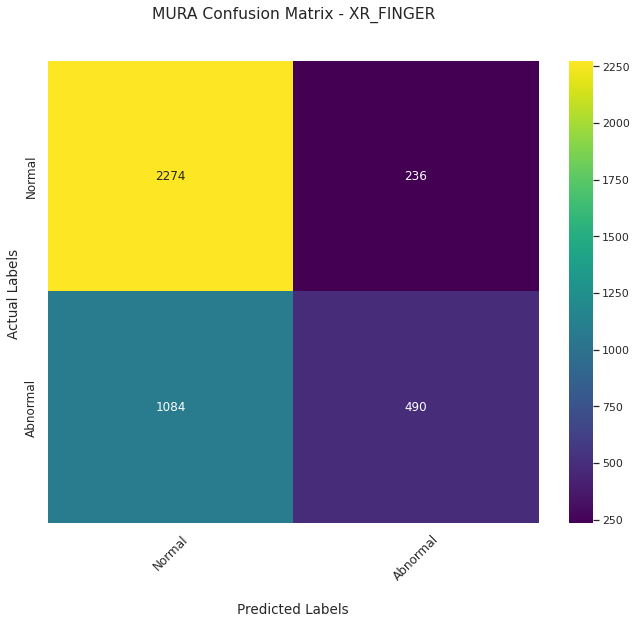




Found 1460 validated image filenames belonging to 2 classes.


XR_FOREARM


Metrics for the train set:
loss        : 0.5904040336608887
f1          : 0.36553502082824707
pr_auc      : 0.56212317943573
roc_auc     : 0.7164877653121948
precision   : 0.6325581669807434
recall      : 0.257088840007782
binary_acc  : 0.6767123341560364
tp          : 136.0
fp          : 79.0
tn          : 852.0
fn          : 393.0
cohen_kappa : 0.1975499391555786

Precision, recall, F1 scores for each class(train set)
              precision    recall  f1-score   support

      Normal       0.69      0.92      0.79       931
    Abnormal       0.67      0.27      0.39       529

    accuracy                           0.69      1460
   macro avg       0.68      0.60      0.59      1460
weighted avg       0.69      0.69      0.65      1460


Precision Recall AUC score for the normal class(train set):
0.8229827567918501

Precision Recall AUC score for the abnormal class(train set):
0.5853746476272604

Macro-a

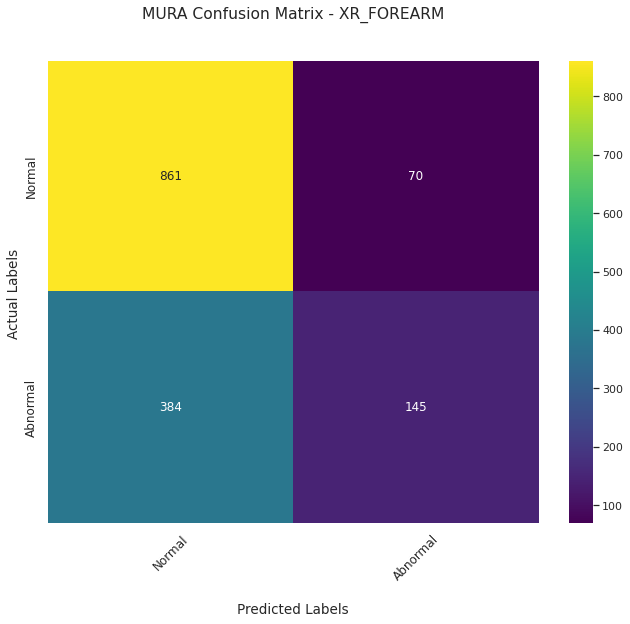




Found 4434 validated image filenames belonging to 2 classes.


XR_HAND   


Metrics for the train set:
loss        : 0.5472075343132019
f1          : 0.10804027318954468
pr_auc      : 0.43821126222610474
roc_auc     : 0.6692847609519958
precision   : 0.6822429895401001
recall      : 0.06149957701563835
binary_acc  : 0.7410915493965149
tp          : 73.0
fp          : 34.0
tn          : 3213.0
fn          : 1114.0
cohen_kappa : 0.07173168659210205

Precision, recall, F1 scores for each class(train set)
              precision    recall  f1-score   support

      Normal       0.74      0.98      0.84      3247
    Abnormal       0.54      0.05      0.09      1187

    accuracy                           0.73      4434
   macro avg       0.64      0.52      0.47      4434
weighted avg       0.69      0.73      0.64      4434


Precision Recall AUC score for the normal class(train set):
0.8358345501777396

Precision Recall AUC score for the abnormal class(train set):
0.4240288002253052



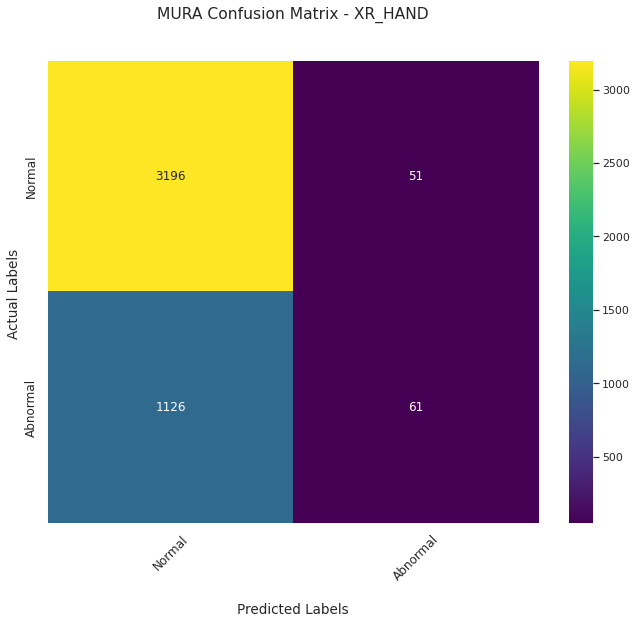




Found 1018 validated image filenames belonging to 2 classes.


XR_HUMERUS


Metrics for the train set:
loss        : 0.6558140516281128
f1          : 0.45329558849334717
pr_auc      : 0.6364635229110718
roc_auc     : 0.6617760062217712
precision   : 0.6600790619850159
recall      : 0.3486430048942566
binary_acc  : 0.6090373396873474
tp          : 167.0
fp          : 86.0
tn          : 453.0
fn          : 312.0
cohen_kappa : 0.19418776035308838

Precision, recall, F1 scores for each class(train set)
              precision    recall  f1-score   support

      Normal       0.59      0.83      0.69       539
    Abnormal       0.65      0.36      0.46       479

    accuracy                           0.61      1018
   macro avg       0.62      0.59      0.58      1018
weighted avg       0.62      0.61      0.58      1018


Precision Recall AUC score for the normal class(train set):
0.6886665995354422

Precision Recall AUC score for the abnormal class(train set):
0.6427571698781367

Mac

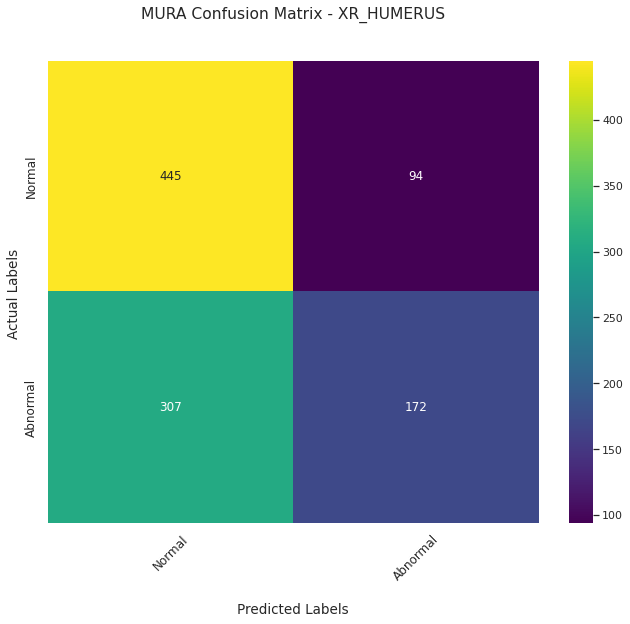




Found 6703 validated image filenames belonging to 2 classes.


XR_SHOULDER


Metrics for the train set:
loss        : 0.6630613803863525
f1          : 0.45059025287628174
pr_auc      : 0.6806090474128723
roc_auc     : 0.6632979512214661
precision   : 0.7494809627532959
recall      : 0.32483503222465515
binary_acc  : 0.6101745367050171
tp          : 1083.0
fp          : 362.0
tn          : 3007.0
fn          : 2251.0
cohen_kappa : 0.21802634000778198

Precision, recall, F1 scores for each class(train set)
              precision    recall  f1-score   support

      Normal       0.57      0.88      0.69      3369
    Abnormal       0.73      0.32      0.45      3334

    accuracy                           0.60      6703
   macro avg       0.65      0.60      0.57      6703
weighted avg       0.65      0.60      0.57      6703


Precision Recall AUC score for the normal class(train set):
0.6276883473829983

Precision Recall AUC score for the abnormal class(train set):
0.675984267610615

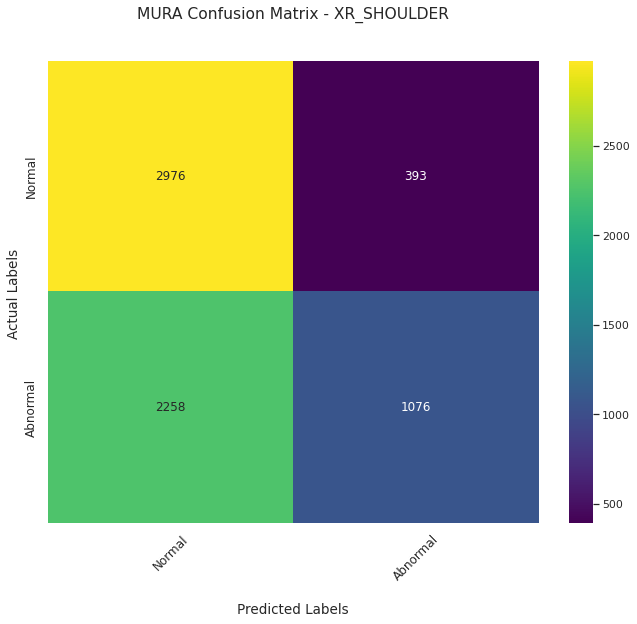




Found 7802 validated image filenames belonging to 2 classes.


XR_WRIST  


Metrics for the train set:
loss        : 0.5695821642875671
f1          : 0.5162855386734009
pr_auc      : 0.6942321062088013
roc_auc     : 0.752264142036438
precision   : 0.7040598392486572
recall      : 0.4131661355495453
binary_acc  : 0.6890540719032288
tp          : 1318.0
fp          : 554.0
tn          : 4058.0
fn          : 1872.0
cohen_kappa : 0.31297993659973145

Precision, recall, F1 scores for each class(train set)
              precision    recall  f1-score   support

      Normal       0.69      0.88      0.77      4612
    Abnormal       0.71      0.42      0.53      3190

    accuracy                           0.69      7802
   macro avg       0.70      0.65      0.65      7802
weighted avg       0.69      0.69      0.67      7802


Precision Recall AUC score for the normal class(train set):
0.8136180605575813

Precision Recall AUC score for the abnormal class(train set):
0.6985247012741154

M

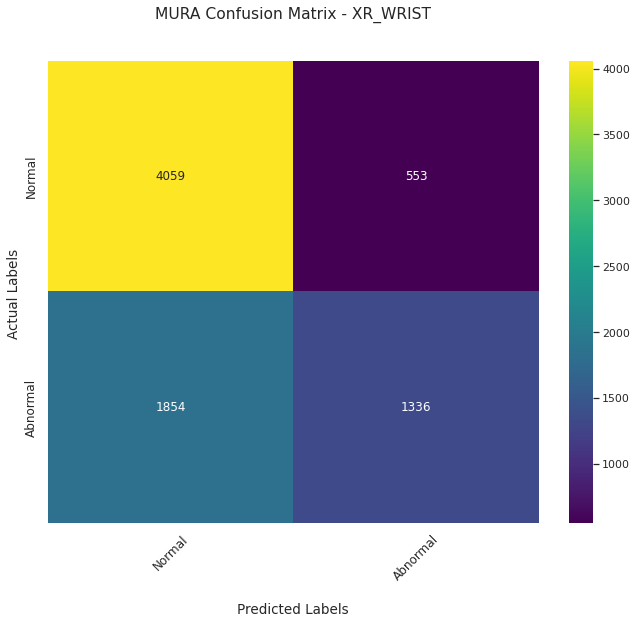

In [ ]:
report(train, 'train', 'rgb', MURA_CNN, train_datagen, chosen_metrics)

Found 986 validated image filenames belonging to 2 classes.


XR_ELBOW  


Metrics for the dev set:
loss        : 0.6370886564254761
f1          : 0.4395863711833954
pr_auc      : 0.5828665494918823
roc_auc     : 0.6657330989837646
precision   : 0.6216216087341309
recall      : 0.3441396653652191
binary_acc  : 0.6480730175971985
tp          : 138.0
fp          : 84.0
tn          : 501.0
fn          : 263.0
cohen_kappa : 0.21569156646728516

Precision, recall, F1 scores for each class(dev set)
              precision    recall  f1-score   support

      Normal       0.66      0.86      0.74       585
    Abnormal       0.62      0.34      0.44       401

    accuracy                           0.65       986
   macro avg       0.64      0.60      0.59       986
weighted avg       0.64      0.65      0.62       986


Precision Recall AUC score for the normal class(dev set):
0.7255254766519157

Precision Recall AUC score for the abnormal class(dev set):
0.5831985266697923

Macro-averaged P

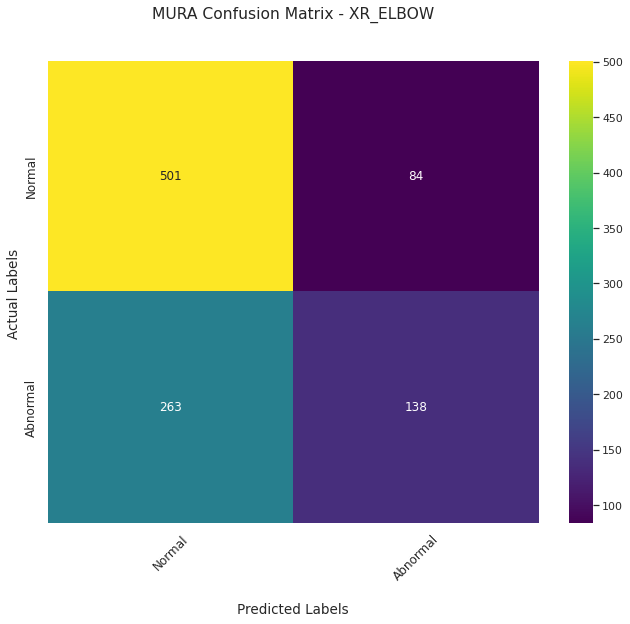




Found 1022 validated image filenames belonging to 2 classes.


XR_FINGER 


Metrics for the dev set:
loss        : 0.5992984175682068
f1          : 0.47305619716644287
pr_auc      : 0.6131998896598816
roc_auc     : 0.7236149311065674
precision   : 0.5977011322975159
recall      : 0.39593908190727234
binary_acc  : 0.664383590221405
tp          : 156.0
fp          : 105.0
tn          : 523.0
fn          : 238.0
cohen_kappa : 0.2440926432609558

Precision, recall, F1 scores for each class(dev set)
              precision    recall  f1-score   support

      Normal       0.69      0.83      0.75       628
    Abnormal       0.60      0.40      0.48       394

    accuracy                           0.66      1022
   macro avg       0.64      0.61      0.61      1022
weighted avg       0.65      0.66      0.65      1022


Precision Recall AUC score for the normal class(dev set):
0.8032804706332128

Precision Recall AUC score for the abnormal class(dev set):
0.6128515595970431

Macro-avera

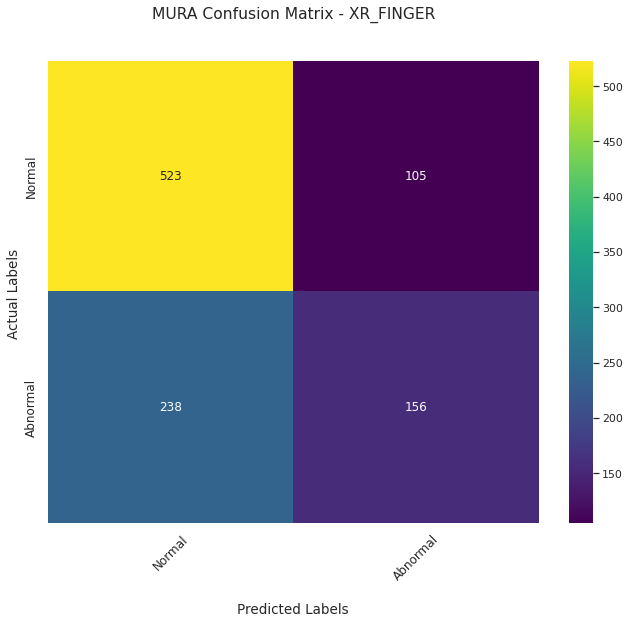




Found 365 validated image filenames belonging to 2 classes.


XR_FOREARM


Metrics for the dev set:
loss        : 0.6384977698326111
f1          : 0.40133774280548096
pr_auc      : 0.518521249294281
roc_auc     : 0.6559208631515503
precision   : 0.5243902206420898
recall      : 0.32575756311416626
binary_acc  : 0.6493150591850281
tp          : 43.0
fp          : 39.0
tn          : 194.0
fn          : 89.0
cohen_kappa : 0.1725407838821411

Precision, recall, F1 scores for each class(dev set)
              precision    recall  f1-score   support

      Normal       0.69      0.83      0.75       233
    Abnormal       0.52      0.33      0.40       132

    accuracy                           0.65       365
   macro avg       0.60      0.58      0.58       365
weighted avg       0.63      0.65      0.63       365


Precision Recall AUC score for the normal class(dev set):
0.7588123816111206

Precision Recall AUC score for the abnormal class(dev set):
0.5174457924646725

Macro-averaged 

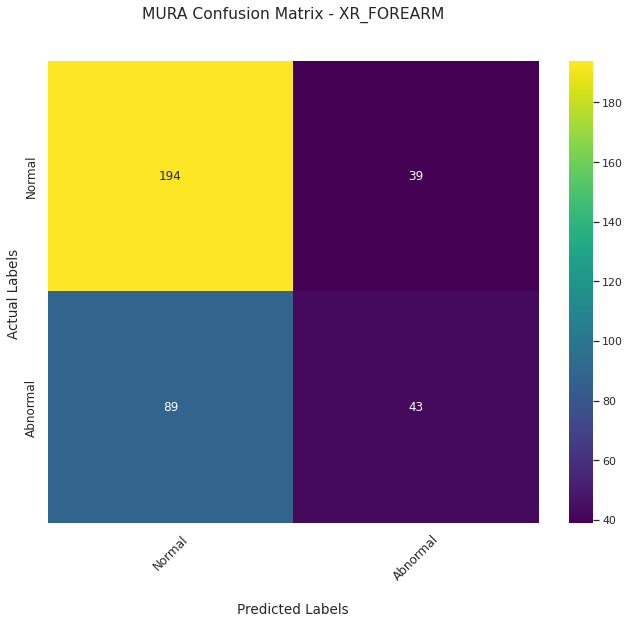




Found 1109 validated image filenames belonging to 2 classes.


XR_HAND   


Metrics for the dev set:
loss        : 0.5856180191040039
f1          : 0.20021040737628937
pr_auc      : 0.3833189308643341
roc_auc     : 0.6285328269004822
precision   : 0.5070422291755676
recall      : 0.12121212482452393
binary_acc  : 0.7330929040908813
tp          : 36.0
fp          : 35.0
tn          : 777.0
fn          : 261.0
cohen_kappa : 0.10295182466506958

Precision, recall, F1 scores for each class(dev set)
              precision    recall  f1-score   support

      Normal       0.75      0.96      0.84       812
    Abnormal       0.51      0.12      0.20       297

    accuracy                           0.73      1109
   macro avg       0.63      0.54      0.52      1109
weighted avg       0.68      0.73      0.67      1109


Precision Recall AUC score for the normal class(dev set):
0.809864099858828

Precision Recall AUC score for the abnormal class(dev set):
0.3830976193965111

Macro-averag

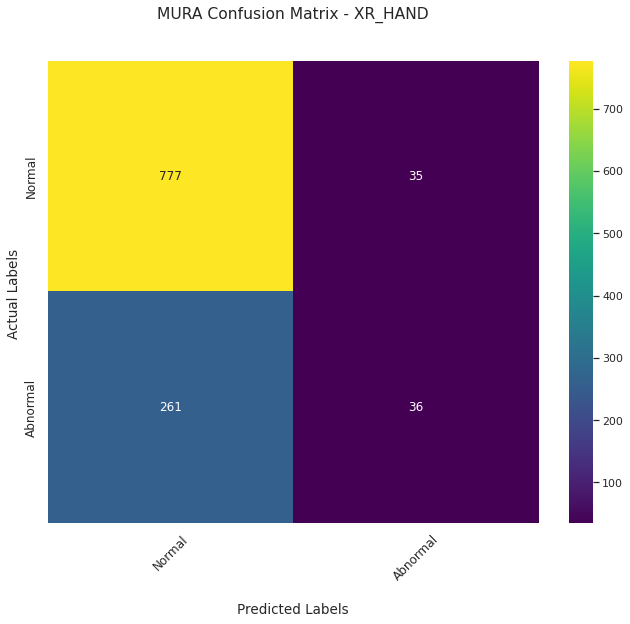




Found 254 validated image filenames belonging to 2 classes.


XR_HUMERUS


Metrics for the dev set:
loss        : 0.7257170081138611
f1          : 0.4965553283691406
pr_auc      : 0.5609734058380127
roc_auc     : 0.6004042029380798
precision   : 0.5698924660682678
recall      : 0.4416666626930237
binary_acc  : 0.5787401795387268
tp          : 53.0
fp          : 40.0
tn          : 94.0
fn          : 67.0
cohen_kappa : 0.1448618769645691

Precision, recall, F1 scores for each class(dev set)
              precision    recall  f1-score   support

      Normal       0.58      0.70      0.64       134
    Abnormal       0.57      0.44      0.50       120

    accuracy                           0.58       254
   macro avg       0.58      0.57      0.57       254
weighted avg       0.58      0.58      0.57       254


Precision Recall AUC score for the normal class(dev set):
0.6102562400305336

Precision Recall AUC score for the abnormal class(dev set):
0.5613537401988793

Macro-averaged Pr

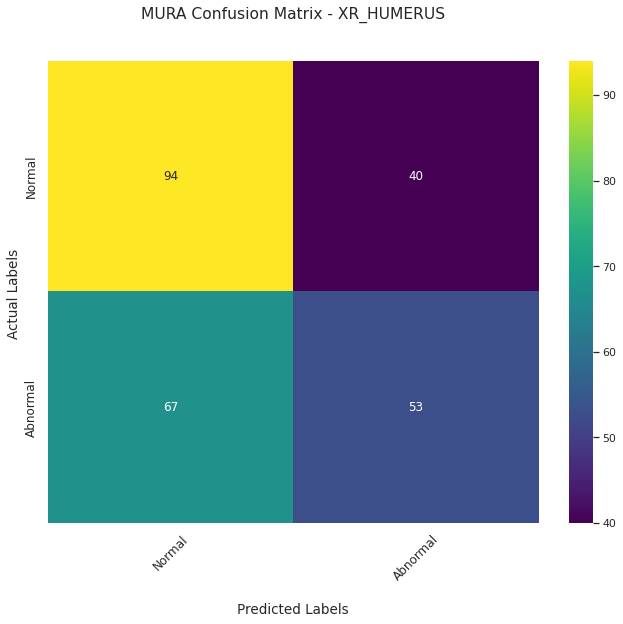




Found 1676 validated image filenames belonging to 2 classes.


XR_SHOULDER


Metrics for the dev set:
loss        : 0.6368947625160217
f1          : 0.5838654637336731
pr_auc      : 0.6964539885520935
roc_auc     : 0.6941057443618774
precision   : 0.671875
recall      : 0.5155875086784363
binary_acc  : 0.6336515545845032
tp          : 430.0
fp          : 210.0
tn          : 632.0
fn          : 404.0
cohen_kappa : 0.2664757966995239

Precision, recall, F1 scores for each class(dev set)
              precision    recall  f1-score   support

      Normal       0.61      0.75      0.67       842
    Abnormal       0.67      0.52      0.58       834

    accuracy                           0.63      1676
   macro avg       0.64      0.63      0.63      1676
weighted avg       0.64      0.63      0.63      1676


Precision Recall AUC score for the normal class(dev set):
0.6599913869010139

Precision Recall AUC score for the abnormal class(dev set):
0.6965405399811392

Macro-averaged Precis

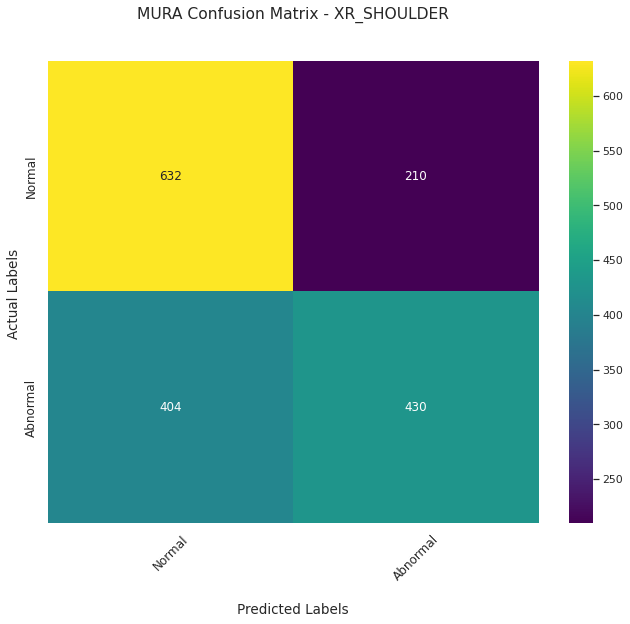




Found 1950 validated image filenames belonging to 2 classes.


XR_WRIST  


Metrics for the dev set:
loss        : 0.5882697701454163
f1          : 0.5819582939147949
pr_auc      : 0.6837589144706726
roc_auc     : 0.7442746162414551
precision   : 0.6388059854507446
recall      : 0.537013828754425
binary_acc  : 0.6866666674613953
tp          : 428.0
fp          : 242.0
tn          : 911.0
fn          : 369.0
cohen_kappa : 0.3353767991065979

Precision, recall, F1 scores for each class(dev set)
              precision    recall  f1-score   support

      Normal       0.71      0.79      0.75      1153
    Abnormal       0.64      0.54      0.58       797

    accuracy                           0.69      1950
   macro avg       0.68      0.66      0.67      1950
weighted avg       0.68      0.69      0.68      1950


Precision Recall AUC score for the normal class(dev set):
0.7929091729008937

Precision Recall AUC score for the abnormal class(dev set):
0.6834052453364676

Macro-average

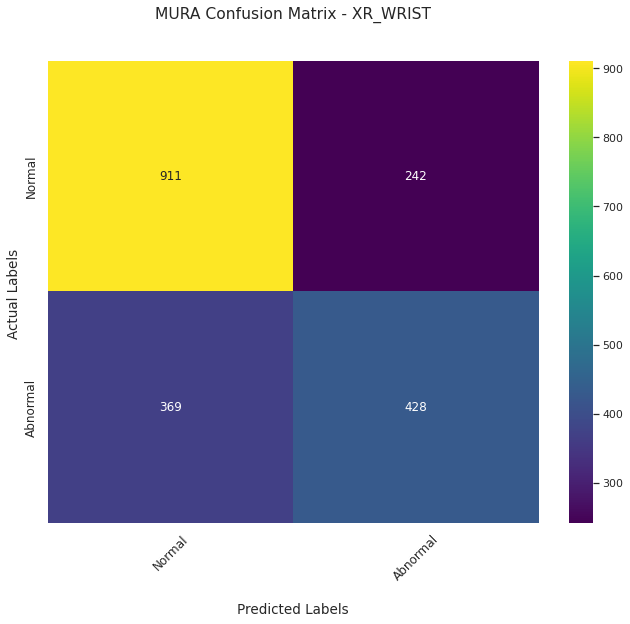

In [ ]:
report(dev, 'dev', 'rgb', MURA_CNN, dev_test_datagen, chosen_metrics)

Found 465 validated image filenames belonging to 2 classes.


XR_ELBOW  


Metrics for the test set:
loss        : 0.6550635695457458
f1          : 0.26699507236480713
pr_auc      : 0.6853823065757751
roc_auc     : 0.692099928855896
precision   : 0.6880000233650208
recall      : 0.373913049697876
binary_acc  : 0.6064516305923462
tp          : 86.0
fp          : 39.0
tn          : 196.0
fn          : 144.0
cohen_kappa : 0.20897042751312256

Precision, recall, F1 scores for each class(test set)
              precision    recall  f1-score   support

      Normal       0.58      0.83      0.68       235
    Abnormal       0.69      0.37      0.48       230

    accuracy                           0.61       465
   macro avg       0.63      0.60      0.58       465
weighted avg       0.63      0.61      0.58       465


Precision Recall AUC score for the normal class(test set):
0.6838376895492981

Precision Recall AUC score for the abnormal class(test set):
0.6856311043933132

Macro-averaged

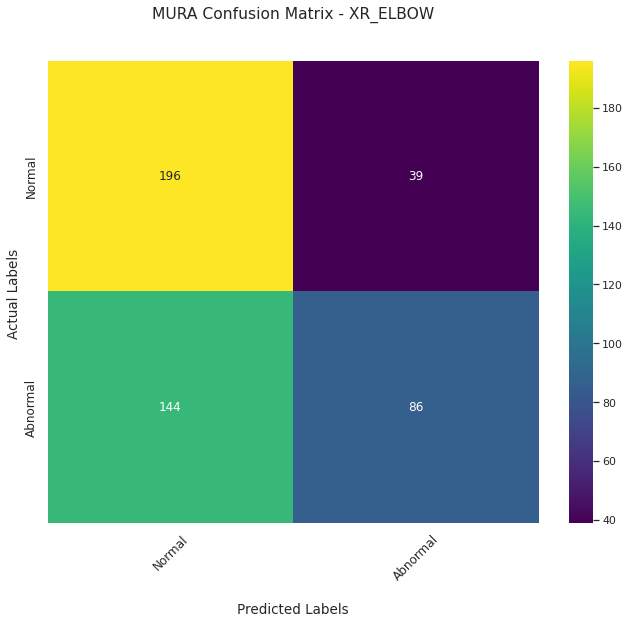




Found 461 validated image filenames belonging to 2 classes.


XR_FINGER 


Metrics for the test set:
loss        : 0.673194944858551
f1          : 0.30499792098999023
pr_auc      : 0.765532910823822
roc_auc     : 0.7334462404251099
precision   : 0.811965823173523
recall      : 0.38461539149284363
binary_acc  : 0.622559666633606
tp          : 95.0
fp          : 22.0
tn          : 192.0
fn          : 152.0
cohen_kappa : 0.27082163095474243

Precision, recall, F1 scores for each class(test set)
              precision    recall  f1-score   support

      Normal       0.56      0.90      0.69       214
    Abnormal       0.81      0.38      0.52       247

    accuracy                           0.62       461
   macro avg       0.69      0.64      0.61       461
weighted avg       0.69      0.62      0.60       461


Precision Recall AUC score for the normal class(test set):
0.6730387781755686

Precision Recall AUC score for the abnormal class(test set):
0.7654430983645155

Macro-averag

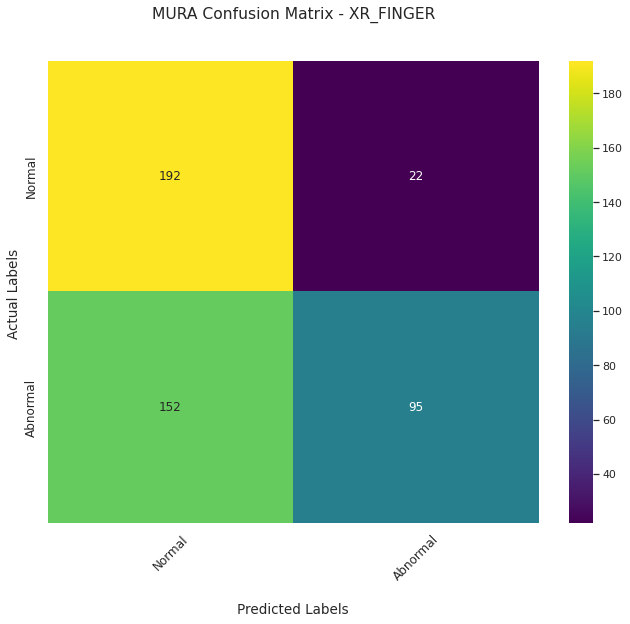




Found 301 validated image filenames belonging to 2 classes.


XR_FOREARM


Metrics for the test set:
loss        : 0.7115534543991089
f1          : 0.3370547294616699
pr_auc      : 0.6717346906661987
roc_auc     : 0.6752759218215942
precision   : 0.7333333492279053
recall      : 0.3642384111881256
binary_acc  : 0.6146179437637329
tp          : 55.0
fp          : 20.0
tn          : 130.0
fn          : 96.0
cohen_kappa : 0.23051834106445312

Precision, recall, F1 scores for each class(test set)
              precision    recall  f1-score   support

      Normal       0.58      0.87      0.69       150
    Abnormal       0.73      0.36      0.49       151

    accuracy                           0.61       301
   macro avg       0.65      0.62      0.59       301
weighted avg       0.65      0.61      0.59       301


Precision Recall AUC score for the normal class(test set):
0.6612077646634104

Precision Recall AUC score for the abnormal class(test set):
0.6718990929128181

Macro-avera

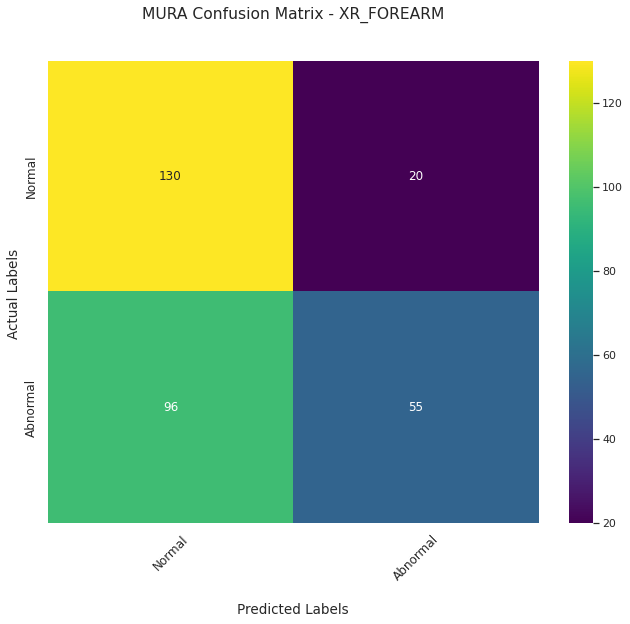




Found 460 validated image filenames belonging to 2 classes.


XR_HAND   


Metrics for the test set:
loss        : 0.7131115198135376
f1          : 0.1381828486919403
pr_auc      : 0.5604802966117859
roc_auc     : 0.6411292552947998
precision   : 0.5925925970077515
recall      : 0.16931216418743134
binary_acc  : 0.6108695864677429
tp          : 32.0
fp          : 22.0
tn          : 249.0
fn          : 157.0
cohen_kappa : 0.09880918264389038

Precision, recall, F1 scores for each class(test set)
              precision    recall  f1-score   support

      Normal       0.61      0.92      0.74       271
    Abnormal       0.59      0.17      0.26       189

    accuracy                           0.61       460
   macro avg       0.60      0.54      0.50       460
weighted avg       0.60      0.61      0.54       460


Precision Recall AUC score for the normal class(test set):
0.7105419174663125

Precision Recall AUC score for the abnormal class(test set):
0.5607533137429935

Macro-ave

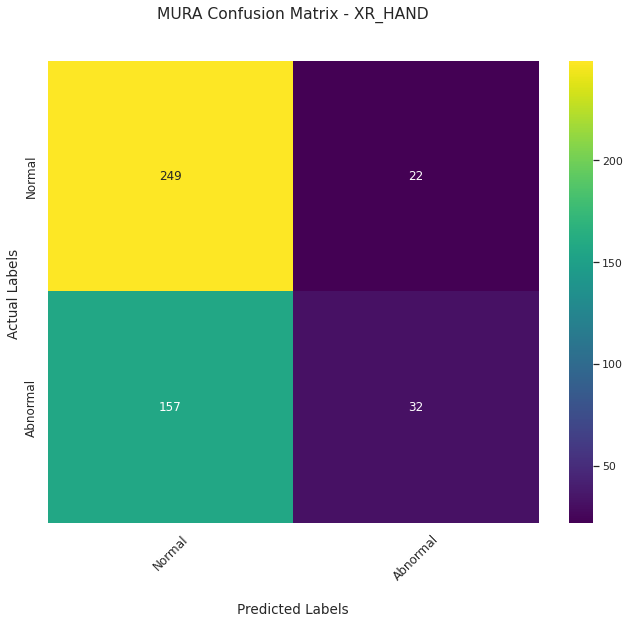




Found 288 validated image filenames belonging to 2 classes.


XR_HUMERUS


Metrics for the test set:
loss        : 0.7083802819252014
f1          : 0.25293347239494324
pr_auc      : 0.616592526435852
roc_auc     : 0.6301640868186951
precision   : 0.6235294342041016
recall      : 0.37857142090797424
binary_acc  : 0.5868055820465088
tp          : 53.0
fp          : 32.0
tn          : 116.0
fn          : 87.0
cohen_kappa : 0.16409754753112793

Precision, recall, F1 scores for each class(test set)
              precision    recall  f1-score   support

      Normal       0.57      0.78      0.66       148
    Abnormal       0.62      0.38      0.47       140

    accuracy                           0.59       288
   macro avg       0.60      0.58      0.57       288
weighted avg       0.60      0.59      0.57       288


Precision Recall AUC score for the normal class(test set):
0.6229959436182317

Precision Recall AUC score for the abnormal class(test set):
0.6160901994640431

Macro-aver

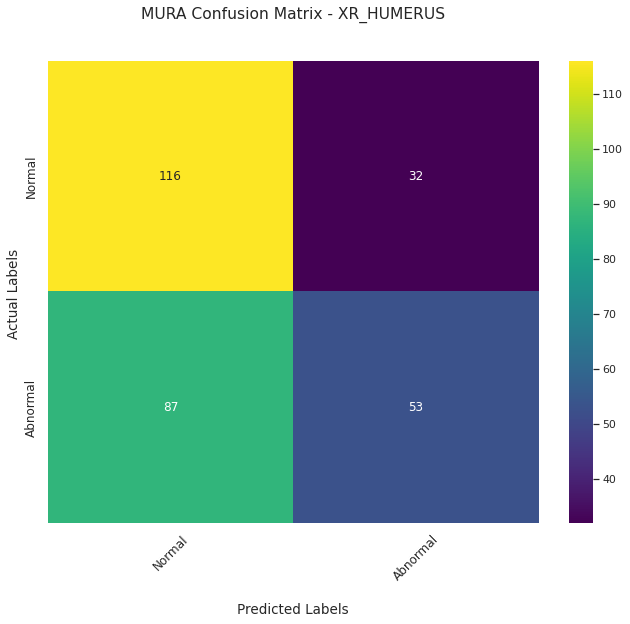




Found 563 validated image filenames belonging to 2 classes.


XR_SHOULDER


Metrics for the test set:
loss        : 0.6653303503990173
f1          : 0.3596893548965454
pr_auc      : 0.6631492972373962
roc_auc     : 0.6469771862030029
precision   : 0.6984127163887024
recall      : 0.4748201370239258
binary_acc  : 0.6394315958023071
tp          : 132.0
fp          : 57.0
tn          : 228.0
fn          : 146.0
cohen_kappa : 0.27590489387512207

Precision, recall, F1 scores for each class(test set)
              precision    recall  f1-score   support

      Normal       0.61      0.80      0.69       285
    Abnormal       0.70      0.47      0.57       278

    accuracy                           0.64       563
   macro avg       0.65      0.64      0.63       563
weighted avg       0.65      0.64      0.63       563


Precision Recall AUC score for the normal class(test set):
0.6028951221793668

Precision Recall AUC score for the abnormal class(test set):
0.6632786311595626

Macro-av

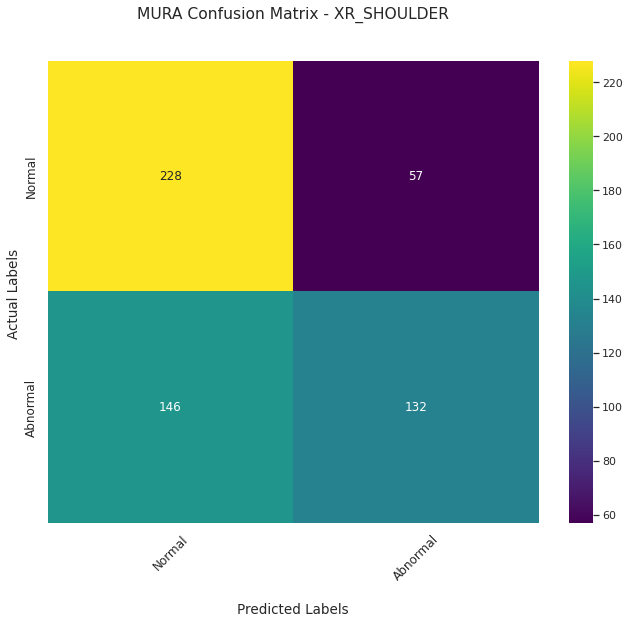




Found 659 validated image filenames belonging to 2 classes.


XR_WRIST  


Metrics for the test set:
loss        : 0.6436912417411804
f1          : 0.31422314047813416
pr_auc      : 0.6556110978126526
roc_auc     : 0.704106867313385
precision   : 0.6283186078071594
recall      : 0.4813559353351593
binary_acc  : 0.6403641700744629
tp          : 142.0
fp          : 84.0
tn          : 280.0
fn          : 153.0
cohen_kappa : 0.25626784563064575

Precision, recall, F1 scores for each class(test set)
              precision    recall  f1-score   support

      Normal       0.65      0.77      0.70       364
    Abnormal       0.63      0.48      0.55       295

    accuracy                           0.64       659
   macro avg       0.64      0.63      0.62       659
weighted avg       0.64      0.64      0.63       659


Precision Recall AUC score for the normal class(test set):
0.7417405319018231

Precision Recall AUC score for the abnormal class(test set):
0.6554911091478464

Macro-ave

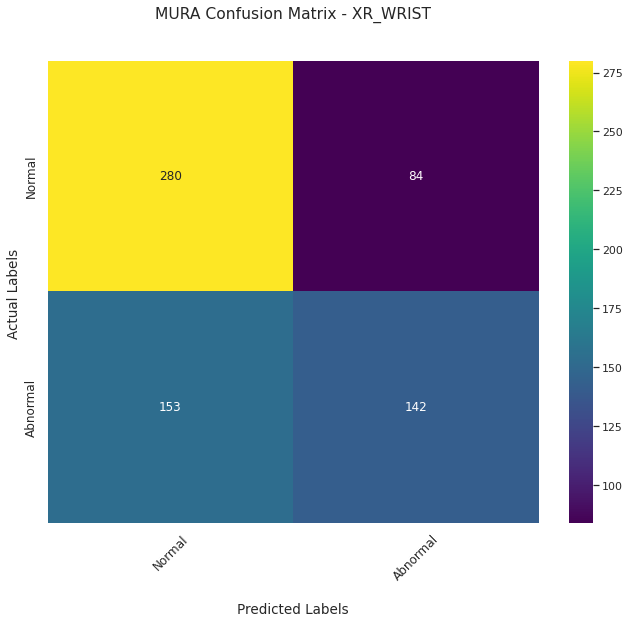

In [ ]:
report(test, 'test', 'rgb', MURA_CNN, dev_test_datagen, chosen_metrics)

In [ ]:
clean_up(model=model)

#### ResNet50 with rotation ONLY of the train set

In [ ]:
callbacks = [ReduceLROnPlateau(monitor="val_loss", patience=2, cooldown=2), 
        EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=5, restore_best_weights=True)]
                                                                          # If False, the model weights obtained at the last step of training are used.
                                                                          # else, restores weights from the best epoch in that set.

In [ ]:
res_datagen_train = ImageDataGenerator(rescale=1/255, 
                                   rotation_range=30,
                                  #  horizontal_flip=True,
                                  #  vertical_flip=True,
                                   preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

train_generator = res_datagen_train.flow_from_dataframe(dataframe=train, directory=None,
                                              x_col="Paths", y_col="Label",         # 1_hot_labels and categorical
                                              target_size=(224,224), class_mode="binary",
                                              batch_size=128, shuffle=True, color_mode = "rgb", seed=11, fill_mode='constant',
                                              )

# per = np.random.permutation(train_generator.n)
# train_generator.index_array = per
# classes = train_generator.classes[per]
# train_generator.index_array

Found 29446 validated image filenames belonging to 2 classes.


In [ ]:
res_datagen_dev_test = ImageDataGenerator(rescale=1/255,
                                          preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

dev_generator = res_datagen_dev_test.flow_from_dataframe(dataframe=dev, directory=None,
                                              x_col="Paths", y_col="Label",
                                              target_size=(224,224), class_mode="binary",
                                              batch_size=128, shuffle=False, color_mode = "rgb", seed=11, fill_mode='constant',
                                              )

test_generator = res_datagen_dev_test.flow_from_dataframe(dataframe=test, directory=None,
                                              x_col="Paths", y_col="Label",
                                              target_size=(224,224), class_mode="binary",
                                              batch_size=128, shuffle=False, color_mode = "rgb", seed=11, fill_mode='constant',
                                              )

Found 7362 validated image filenames belonging to 2 classes.
Found 3197 validated image filenames belonging to 2 classes.


In [ ]:
def train_res_model(
        upper_layers_epochs,
        full_network_epochs,
        batch_size,
        mlp_hidden_layers,
        mlp_hidden_activation,
        callbacks):
    
    np.random.seed(1234) # Define the seed for numpy to have reproducible experiments.
    set_seed(1234) # Define the seed for Tensorflow to have reproducible experiments.

    # input = Input(shape = (224,224,3), name='input')
    # example of loading the resnet50 model
    # load model
    res_model = ResNet50(include_top=False, weights = 'imagenet', pooling = 'max') # input_tensor=input,
    # max pooling because we want to emphasize the characteristics extracted (make them sharp)

    x = res_model.output
    #Define MLP layers.
    for i, units in enumerate(mlp_hidden_layers):
        x = Dense(
            units=units,
            kernel_initializer='glorot_uniform',
            activation=mlp_hidden_activation,
            name='Hidden-{0:d}'.format(i + 1)
        )(x)
        x = Dropout(rate=0.2)(x)
   
    
    # Define the output layer.
    output = Dense(
        units=1,
        activation="sigmoid",
        name='Output'
    )(x)

    # Define the model and train it.
    model = Model(inputs = res_model.input, outputs = output)

    #Freeze the resnet model
    # First train the upper layers for a few epochs
    
    for layer in res_model.layers:
        layer.trainable = False

    model.compile(optimizer = 'Adam',
              loss='binary_crossentropy', 
              metrics=chosen_metrics)
    
    upper_layers = model.fit(train_generator, 
                                epochs=upper_layers_epochs, 
                                callbacks=callbacks, 
                                validation_data=dev_generator, 
                                batch_size = 128,
                                verbose=1
                                )
       
    print('Finished training upper layers.')
    print('------------------')

    model.save('saved_model/MURA_ResNet50_1e4_hid512_run_pls')

    with open('MURA_ResNet50_1e4_hid512__history_dict_run_pls.pkl', 'wb') as file_pi:
      pickle.dump(upper_layers.history, file_pi, pickle.HIGHEST_PROTOCOL)

    #Unfreeze the resnet model and train the whole network with a low learning rate

    for layer in res_model.layers:
        layer.trainable = True
    
    model.compile(optimizer = keras.optimizers.Adam(learning_rate=1e-4), # use a very small learning rate, also could use 1e-5
              loss='binary_crossentropy', metrics=chosen_metrics)

    full_network = model.fit(train_generator, 
                                epochs=full_network_epochs, 
                                callbacks=callbacks, 
                                validation_data=dev_generator, 
                                batch_size = 128,
                                verbose=1
                                )
       
    print('Finished training full network.')
    print('------------------')

    model.summary() 
    return model, upper_layers, full_network

In [ ]:
resnet_model, res_upper, res_full = train_res_model(upper_layers_epochs=7,
                                                full_network_epochs=13,
                                                batch_size=128,
                                                mlp_hidden_layers=[512], # one hidden layer
                                                mlp_hidden_activation=ELU(alpha=0.2),
                                                callbacks=callbacks)

94781440/94765736 [==============================] - 0s 0us/step
Epoch 1/7
231/231 [==============================] - 587s 2s/step - loss: 0.8359 - pr_auc: 0.4260 - roc_auc: 0.5337 - precision: 0.4296 - recall: 0.2510 - binary_acc: 0.5627 - tp: 2986.0000 - fp: 3964.0000 - tn: 13584.0000 - fn: 8912.0000 - cohen_kappa: 0.0269 - f1: 0.2403 - val_loss: 0.6606 - val_pr_auc: 0.4811 - val_roc_auc: 0.5935 - val_precision: 0.6966 - val_recall: 0.0208 - val_binary_acc: 0.6007 - val_tp: 62.0000 - val_fp: 27.0000 - val_tn: 4360.0000 - val_fn: 2913.0000 - val_cohen_kappa: 0.0174 - val_f1: 0.0391 - lr: 0.0010
Epoch 2/7
231/231 [==============================] - 537s 2s/step - loss: 0.6669 - pr_auc: 0.4505 - roc_auc: 0.5585 - precision: 0.4737 - recall: 0.1270 - binary_acc: 0.5902 - tp: 1511.0000 - fp: 1679.0000 - tn: 15869.0000 - fn: 10387.0000 - cohen_kappa: 0.0355 - f1: 0.1585 - val_loss: 0.6592 - val_pr_auc: 0.4769 - val_roc_auc: 0.5902 - val_precision: 0.5767 - val_recall: 0.0366 - val_binary_ac

INFO:tensorflow:Assets written to: saved_model/MURA_ResNet50_1e4_hid512_run_pls/assets


INFO:tensorflow:Assets written to: saved_model/MURA_ResNet50_1e4_hid512_run_pls/assets


Epoch 1/13
231/231 [==============================] - 577s 2s/step - loss: 1.2661 - pr_auc: 0.5874 - roc_auc: 0.6926 - precision: 0.6267 - recall: 0.4631 - binary_acc: 0.6716 - tp: 6887.0000 - fp: 4102.0000 - tn: 17833.0000 - fn: 7986.0000 - cohen_kappa: 0.2882 - f1: 0.5817 - val_loss: 0.9487 - val_pr_auc: 0.3947 - val_roc_auc: 0.4992 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_binary_acc: 0.5959 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 4387.0000 - val_fn: 2975.0000 - val_cohen_kappa: 0.0000e+00 - val_f1: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/13
231/231 [==============================] - 567s 2s/step - loss: 0.5093 - pr_auc: 0.7776 - roc_auc: 0.8144 - precision: 0.7634 - recall: 0.5843 - binary_acc: 0.7588 - tp: 6952.0000 - fp: 2155.0000 - tn: 15393.0000 - fn: 4946.0000 - cohen_kappa: 0.4796 - f1: 0.6593 - val_loss: 0.7404 - val_pr_auc: 0.4352 - val_roc_auc: 0.5367 - val_precision: 0.4727 - val_recall: 0.0350 - val_binary_acc: 0.5943 - val_tp: 104.0000 - val_fp:

INFO:tensorflow:Assets written to: saved_model/MURA_ResNet50_1e4_hid512_run_pls2/assets


INFO:tensorflow:Assets written to: saved_model/MURA_ResNet50_1e4_hid512_run_pls2/assets


In [ ]:
# !mkdir -p saved_model
# with open('MURA_ResNet50_1e4_hid512__history_dict_run_pls1.pkl', 'wb') as file_pi:
#   pickle.dump(res_upper.history, file_pi, pickle.HIGHEST_PROTOCOL)

# resnet_model.save('saved_model/MURA_ResNet50_1e4_hid512_run_pls2')

# with open('MURA_ResNet50_1e4_hid512__history_dict_run_pls2.pkl', 'wb') as file_pi:
#       pickle.dump(res_full.history, file_pi, pickle.HIGHEST_PROTOCOL)

In [ ]:
MURA_ResNet50 = load_model('saved_model/MURA_ResNet50_1e4_hid512_run_pls2', custom_objects={'f1':f1})

with keras.utils.custom_object_scope({"f1": f1}):
  with open('MURA_ResNet50_1e4_hid512__history_dict_run_pls1.pkl', 'rb') as file:
    Res_MURA_upper = pickle.load(file)

with keras.utils.custom_object_scope({"f1": f1}):
  with open('MURA_ResNet50_1e4_hid512__history_dict_run_pls2.pkl', 'rb') as file:
    Res_MURA_full = pickle.load(file)

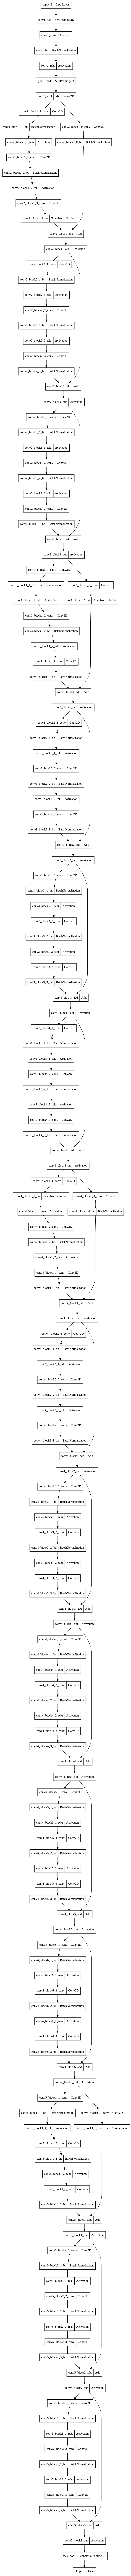

In [ ]:
tf.keras.utils.plot_model(MURA_ResNet50)

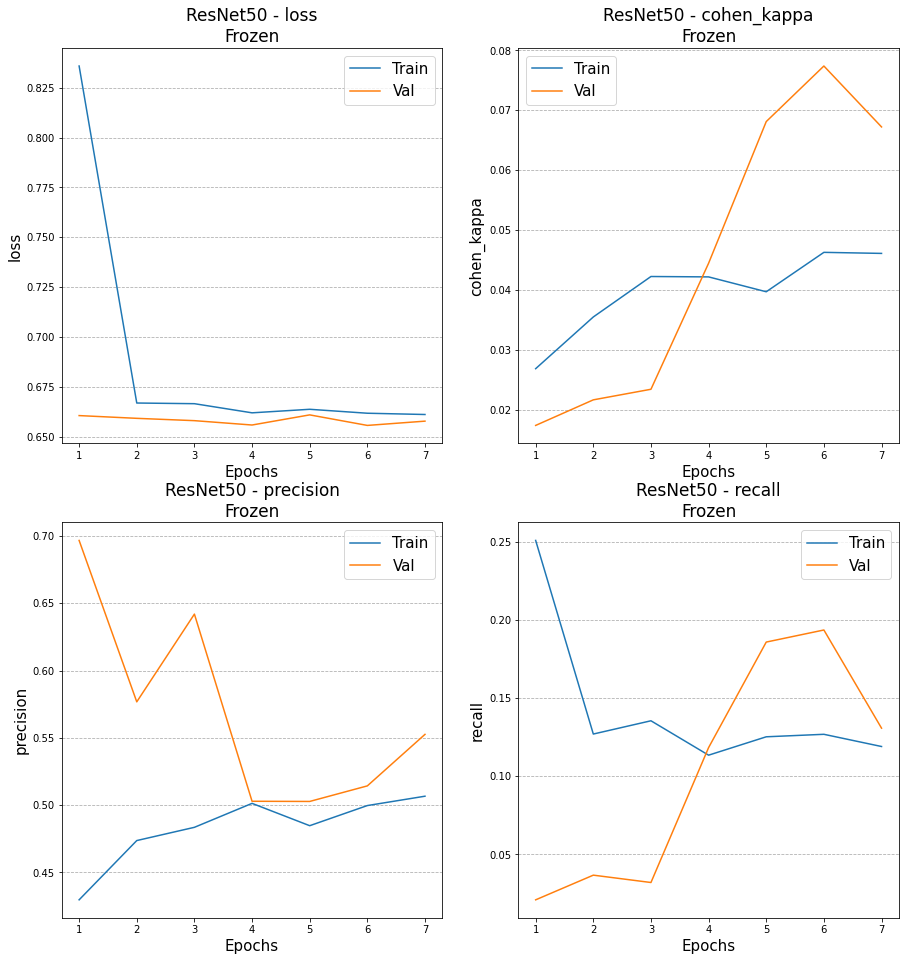

In [ ]:
plot_learning_curves(Res_MURA_upper, ['Train', 'Val'], '\nFrozen', 'ResNet50 - ')

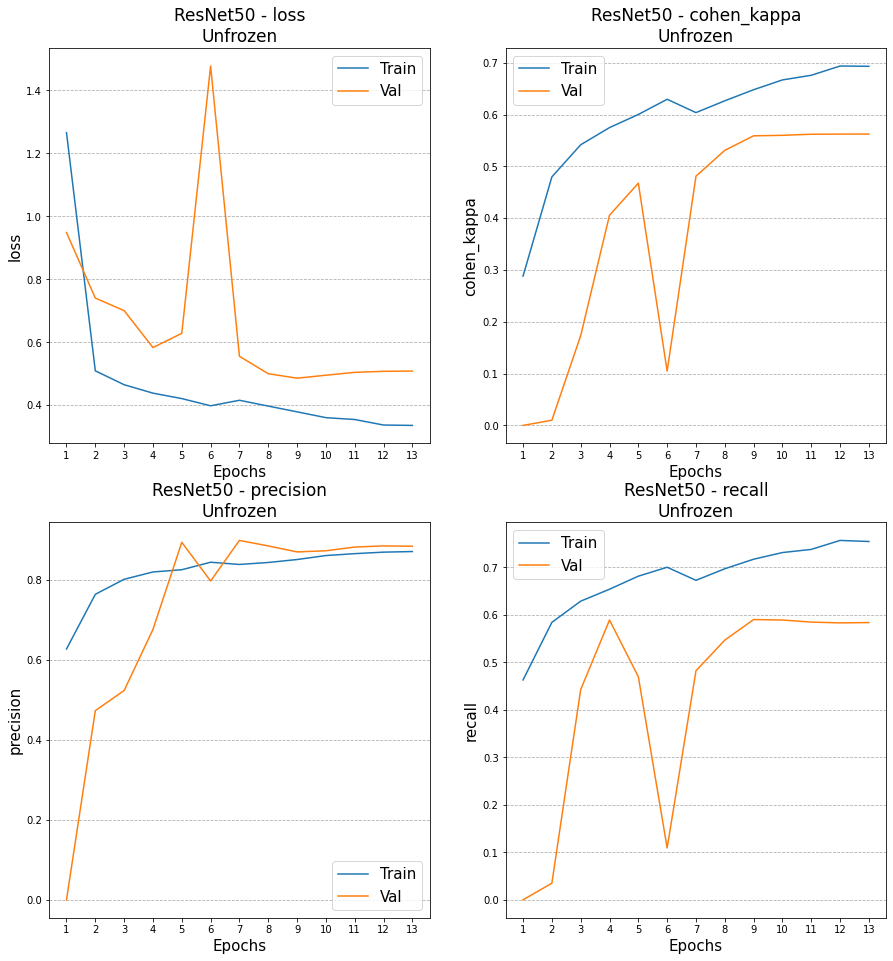

In [ ]:
plot_learning_curves(Res_MURA_full, ['Train', 'Val'], '\nUnfrozen', 'ResNet50 - ')

In [ ]:
eval_metrics([MURA_ResNet50], [train_generator], ['train'], chosen_metrics, False)

Metrics for the train set:
loss        : 0.32308295369148254
f1          : 0.8150548338890076
pr_auc      : 0.916577935218811
roc_auc     : 0.9274225234985352
precision   : 0.8794889450073242
recall      : 0.7636577486991882
binary_acc  : 0.8622223734855652
tp          : 9086.0
fp          : 1245.0
tn          : 16303.0
fn          : 2812.0
cohen_kappa : 0.7077147960662842


Metrics for the development set:
loss        : 0.5085574388504028
f1          : 0.7008183598518372
pr_auc      : 0.8409020304679871
roc_auc     : 0.8590704202651978
precision   : 0.8835198283195496
recall      : 0.5838655233383179
binary_acc  : 0.8007335066795349
tp          : 1737.0
fp          : 229.0
tn          : 4158.0
fn          : 1238.0
cohen_kappa : 0.5623599886894226


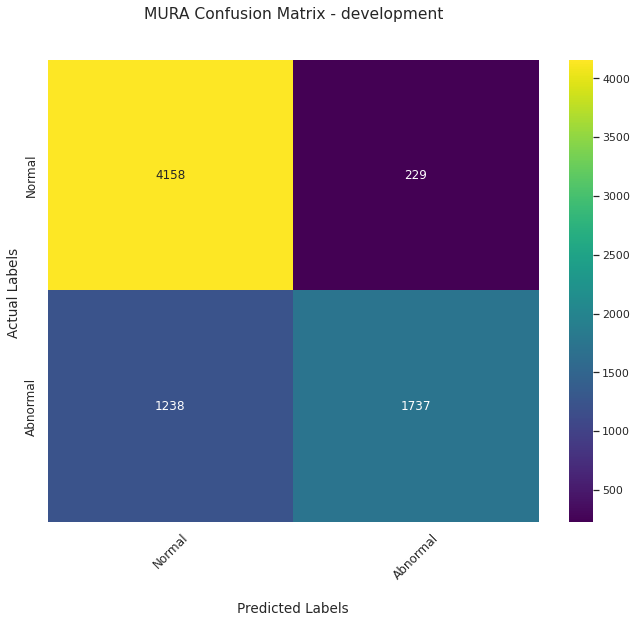

In [ ]:
eval_metrics([MURA_ResNet50], [dev_generator], ['development'], chosen_metrics, True)

Metrics for the test set:
loss        : 0.5913705229759216
f1          : 0.5295770764350891
pr_auc      : 0.8551012873649597
roc_auc     : 0.8528503179550171
precision   : 0.8987217545509338
recall      : 0.5973856449127197
binary_acc  : 0.7751016616821289
tp          : 914.0
fp          : 103.0
tn          : 1564.0
fn          : 616.0
cohen_kappa : 0.5430804491043091


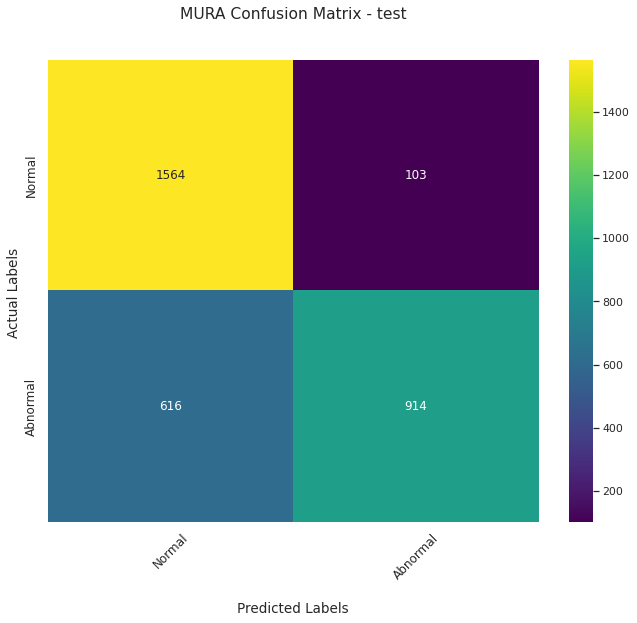

In [ ]:
eval_metrics([MURA_ResNet50], [test_generator], ['test'], chosen_metrics, True)

Found 3945 validated image filenames belonging to 2 classes.


XR_ELBOW  


Metrics for the train set:
loss        : 0.30087605118751526
f1          : 0.8336345553398132
pr_auc      : 0.9300233721733093
roc_auc     : 0.9353002309799194
precision   : 0.90101158618927
recall      : 0.776947021484375
binary_acc  : 0.874524712562561
tp          : 1247.0
fp          : 137.0
tn          : 2203.0
fn          : 358.0
cohen_kappa : 0.7342789173126221

Precision, recall, F1 scores for each class(train set)
              precision    recall  f1-score   support

      Normal       0.85      0.94      0.90      2340
    Abnormal       0.90      0.76      0.83      1605

    accuracy                           0.87      3945
   macro avg       0.88      0.85      0.86      3945
weighted avg       0.87      0.87      0.87      3945


Precision Recall AUC score for the normal class(train set):
0.9420759620725697

Precision Recall AUC score for the abnormal class(train set):
0.9256890901105735

Macro-av

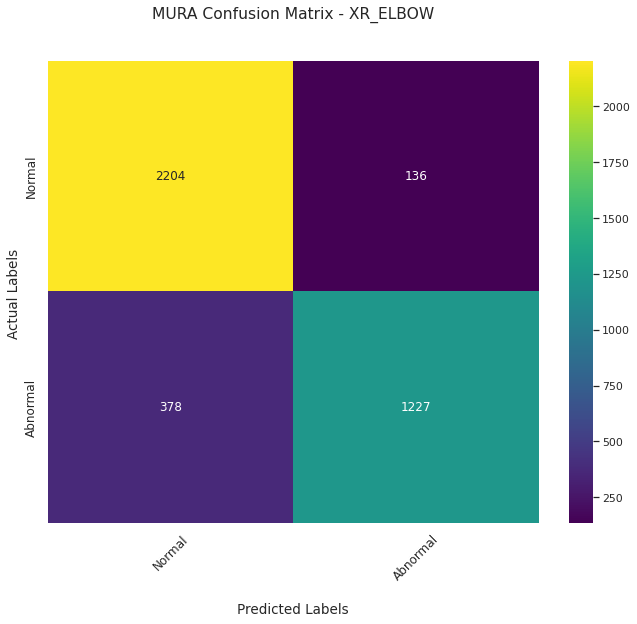




Found 4084 validated image filenames belonging to 2 classes.


XR_FINGER 


Metrics for the train set:
loss        : 0.309223473072052
f1          : 0.8165674805641174
pr_auc      : 0.9171959161758423
roc_auc     : 0.9337125420570374
precision   : 0.866382360458374
recall      : 0.774459958076477
binary_acc  : 0.8670421242713928
tp          : 1219.0
fp          : 188.0
tn          : 2322.0
fn          : 355.0
cohen_kappa : 0.7136780023574829

Precision, recall, F1 scores for each class(train set)
              precision    recall  f1-score   support

      Normal       0.87      0.93      0.90      2510
    Abnormal       0.88      0.77      0.82      1574

    accuracy                           0.87      4084
   macro avg       0.87      0.85      0.86      4084
weighted avg       0.87      0.87      0.87      4084


Precision Recall AUC score for the normal class(train set):
0.9510426953732458

Precision Recall AUC score for the abnormal class(train set):
0.9161104009522039

Macro

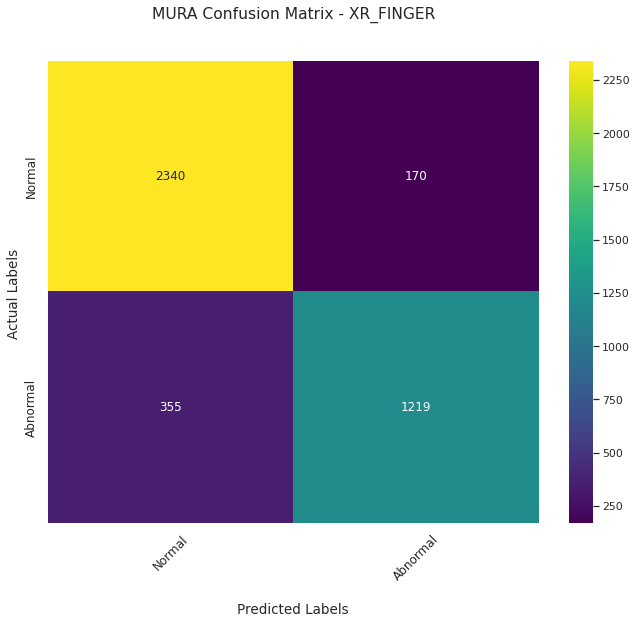




Found 1460 validated image filenames belonging to 2 classes.


XR_FOREARM


Metrics for the train set:
loss        : 0.2950524389743805
f1          : 0.8186933398246765
pr_auc      : 0.9168335795402527
roc_auc     : 0.9333846569061279
precision   : 0.8790496587753296
recall      : 0.7693761587142944
binary_acc  : 0.8780822157859802
tp          : 407.0
fp          : 56.0
tn          : 875.0
fn          : 122.0
cohen_kappa : 0.7288584113121033

Precision, recall, F1 scores for each class(train set)
              precision    recall  f1-score   support

      Normal       0.87      0.94      0.90       931
    Abnormal       0.87      0.76      0.81       529

    accuracy                           0.87      1460
   macro avg       0.87      0.85      0.86      1460
weighted avg       0.87      0.87      0.87      1460


Precision Recall AUC score for the normal class(train set):
0.9542475543904023

Precision Recall AUC score for the abnormal class(train set):
0.9152895434500115

Macro

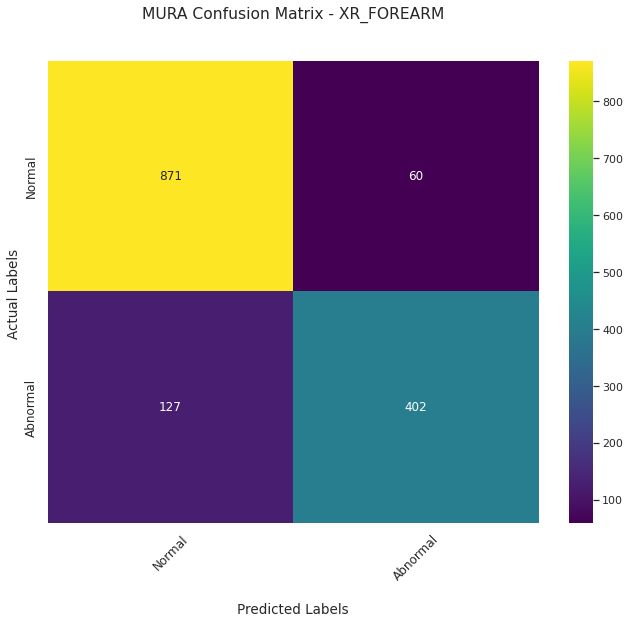




Found 4434 validated image filenames belonging to 2 classes.


XR_HAND   


Metrics for the train set:
loss        : 0.35953402519226074
f1          : 0.6695272922515869
pr_auc      : 0.7889264822006226
roc_auc     : 0.8775249123573303
precision   : 0.8539765477180481
recall      : 0.5518112778663635
binary_acc  : 0.8547586798667908
tp          : 655.0
fp          : 112.0
tn          : 3135.0
fn          : 532.0
cohen_kappa : 0.5827237367630005

Precision, recall, F1 scores for each class(train set)
              precision    recall  f1-score   support

      Normal       0.85      0.96      0.90      3247
    Abnormal       0.84      0.53      0.65      1187

    accuracy                           0.85      4434
   macro avg       0.85      0.75      0.78      4434
weighted avg       0.85      0.85      0.84      4434


Precision Recall AUC score for the normal class(train set):
0.944600642155087

Precision Recall AUC score for the abnormal class(train set):
0.7831393537753928

Mac

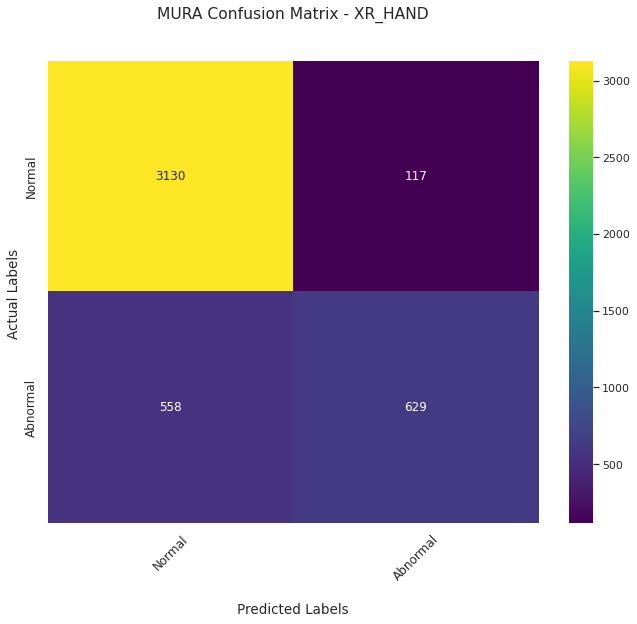




Found 1018 validated image filenames belonging to 2 classes.


XR_HUMERUS


Metrics for the train set:
loss        : 0.29497480392456055
f1          : 0.8726160526275635
pr_auc      : 0.9481114149093628
roc_auc     : 0.9449726939201355
precision   : 0.882478654384613
recall      : 0.8622129559516907
binary_acc  : 0.8811395168304443
tp          : 413.0
fp          : 55.0
tn          : 484.0
fn          : 66.0
cohen_kappa : 0.7611449956893921

Precision, recall, F1 scores for each class(train set)
              precision    recall  f1-score   support

      Normal       0.87      0.90      0.89       539
    Abnormal       0.89      0.85      0.87       479

    accuracy                           0.88      1018
   macro avg       0.88      0.88      0.88      1018
weighted avg       0.88      0.88      0.88      1018


Precision Recall AUC score for the normal class(train set):
0.9450983176617285

Precision Recall AUC score for the abnormal class(train set):
0.9458654997242514

Macro-

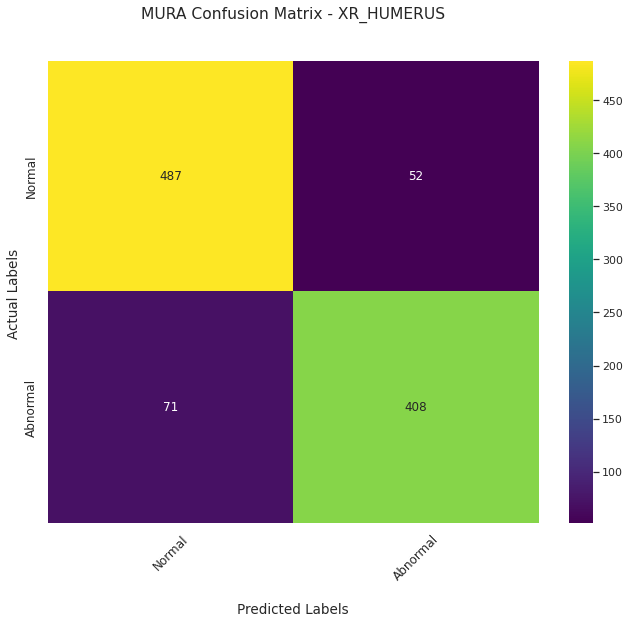




Found 6703 validated image filenames belonging to 2 classes.


XR_SHOULDER


Metrics for the train set:
loss        : 0.3761028051376343
f1          : 0.8229341506958008
pr_auc      : 0.9207725524902344
roc_auc     : 0.9094541668891907
precision   : 0.8588120937347412
recall      : 0.7936412692070007
binary_acc  : 0.8324630856513977
tp          : 2646.0
fp          : 435.0
tn          : 2934.0
fn          : 688.0
cohen_kappa : 0.6647849082946777

Precision, recall, F1 scores for each class(train set)
              precision    recall  f1-score   support

      Normal       0.81      0.87      0.84      3369
    Abnormal       0.86      0.79      0.82      3334

    accuracy                           0.83      6703
   macro avg       0.83      0.83      0.83      6703
weighted avg       0.83      0.83      0.83      6703


Precision Recall AUC score for the normal class(train set):
0.8979511916199423

Precision Recall AUC score for the abnormal class(train set):
0.9189330403224831

M

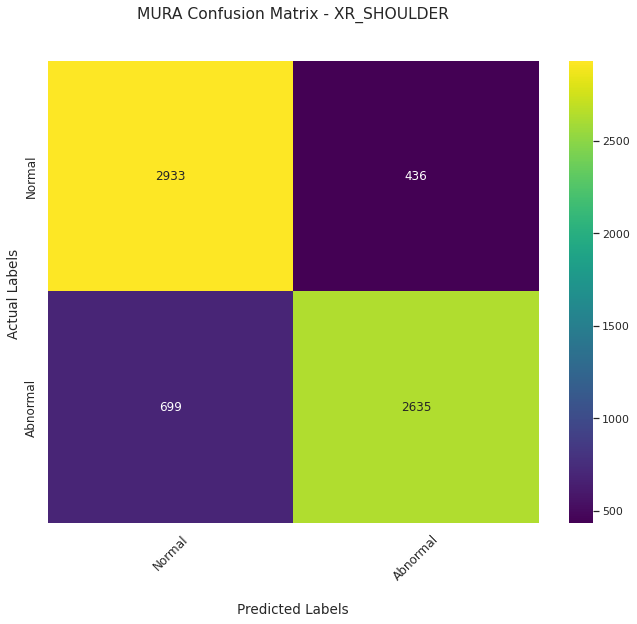




Found 7802 validated image filenames belonging to 2 classes.


XR_WRIST  


Metrics for the train set:
loss        : 0.2821831703186035
f1          : 0.8392670154571533
pr_auc      : 0.9379583597183228
roc_auc     : 0.9442736506462097
precision   : 0.8975818157196045
recall      : 0.7912225723266602
binary_acc  : 0.8777236342430115
tp          : 2524.0
fp          : 288.0
tn          : 4324.0
fn          : 666.0
cohen_kappa : 0.7423374652862549

Precision, recall, F1 scores for each class(train set)
              precision    recall  f1-score   support

      Normal       0.87      0.94      0.91      4612
    Abnormal       0.90      0.80      0.85      3190

    accuracy                           0.88      7802
   macro avg       0.89      0.87      0.88      7802
weighted avg       0.89      0.88      0.88      7802


Precision Recall AUC score for the normal class(train set):
0.9550649150625926

Precision Recall AUC score for the abnormal class(train set):
0.9397754980936563

Ma

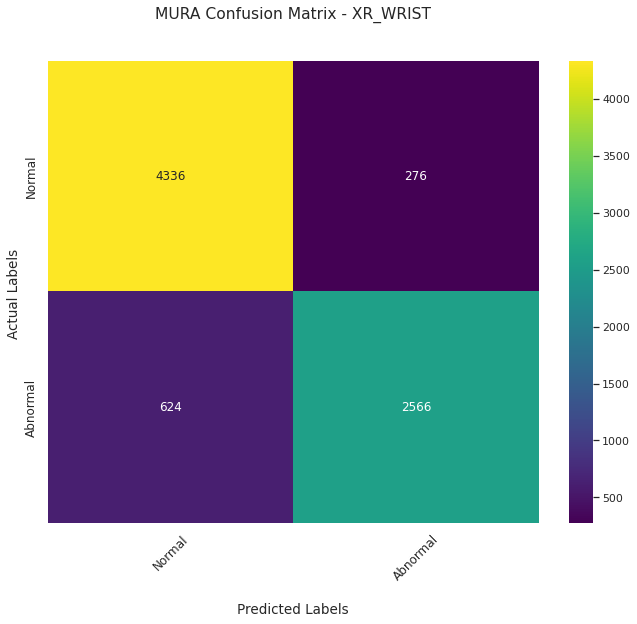

In [ ]:
report(train, 'train', 'rgb', MURA_ResNet50, res_datagen_train, chosen_metrics)

Found 986 validated image filenames belonging to 2 classes.


XR_ELBOW  


Metrics for the dev set:
loss        : 0.5211729407310486
f1          : 0.713392972946167
pr_auc      : 0.8572208285331726
roc_auc     : 0.8578319549560547
precision   : 0.9352226853370667
recall      : 0.576059877872467
binary_acc  : 0.8113590478897095
tp          : 231.0
fp          : 16.0
tn          : 569.0
fn          : 170.0
cohen_kappa : 0.5839794278144836

Precision, recall, F1 scores for each class(dev set)
              precision    recall  f1-score   support

      Normal       0.77      0.97      0.86       585
    Abnormal       0.94      0.58      0.71       401

    accuracy                           0.81       986
   macro avg       0.85      0.77      0.79       986
weighted avg       0.84      0.81      0.80       986


Precision Recall AUC score for the normal class(dev set):
0.8418784037153118

Precision Recall AUC score for the abnormal class(dev set):
0.8577181616261509

Macro-averaged Prec

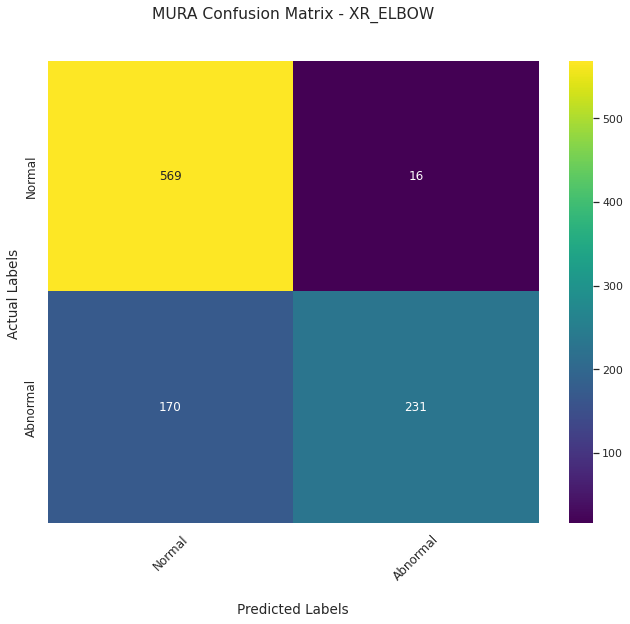




Found 1022 validated image filenames belonging to 2 classes.


XR_FINGER 


Metrics for the dev set:
loss        : 0.578126847743988
f1          : 0.6386492848396301
pr_auc      : 0.7863194942474365
roc_auc     : 0.8320528864860535
precision   : 0.8423236608505249
recall      : 0.5152284502983093
binary_acc  : 0.7759295701980591
tp          : 203.0
fp          : 38.0
tn          : 590.0
fn          : 191.0
cohen_kappa : 0.490182101726532

Precision, recall, F1 scores for each class(dev set)
              precision    recall  f1-score   support

      Normal       0.76      0.94      0.84       628
    Abnormal       0.84      0.52      0.64       394

    accuracy                           0.78      1022
   macro avg       0.80      0.73      0.74      1022
weighted avg       0.79      0.78      0.76      1022


Precision Recall AUC score for the normal class(dev set):
0.8652981981991135

Precision Recall AUC score for the abnormal class(dev set):
0.7824588063918121

Macro-averaged 

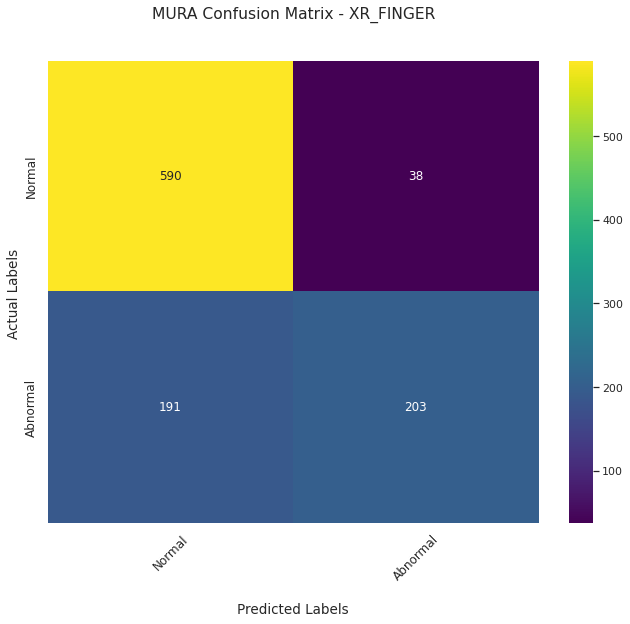




Found 365 validated image filenames belonging to 2 classes.


XR_FOREARM


Metrics for the dev set:
loss        : 0.5347341895103455
f1          : 0.7073934078216553
pr_auc      : 0.8041847348213196
roc_auc     : 0.8497366309165955
precision   : 0.895348846912384
recall      : 0.5833333134651184
binary_acc  : 0.8246575593948364
tp          : 77.0
fp          : 9.0
tn          : 224.0
fn          : 55.0
cohen_kappa : 0.5892096757888794

Precision, recall, F1 scores for each class(dev set)
              precision    recall  f1-score   support

      Normal       0.80      0.96      0.88       233
    Abnormal       0.90      0.58      0.71       132

    accuracy                           0.82       365
   macro avg       0.85      0.77      0.79       365
weighted avg       0.84      0.82      0.81       365


Precision Recall AUC score for the normal class(dev set):
0.875798280563898

Precision Recall AUC score for the abnormal class(dev set):
0.8105868836055092

Macro-averaged Prec

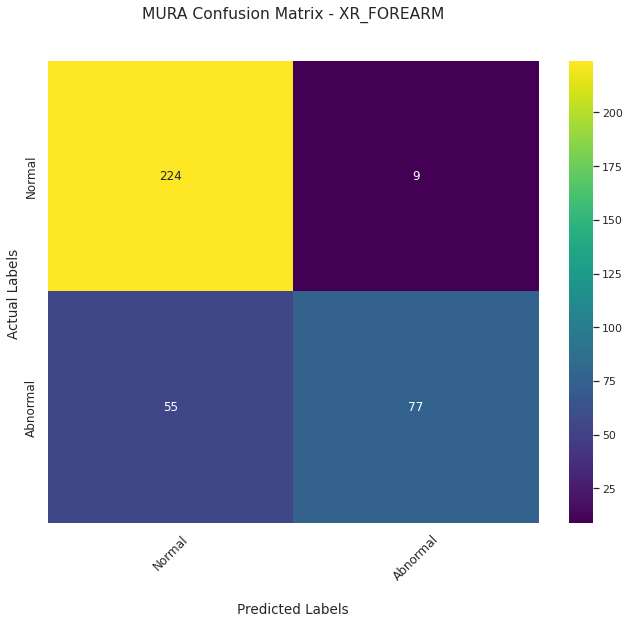




Found 1109 validated image filenames belonging to 2 classes.


XR_HAND   


Metrics for the dev set:
loss        : 0.5624781847000122
f1          : 0.3845376670360565
pr_auc      : 0.628352165222168
roc_auc     : 0.772047221660614
precision   : 0.8505747318267822
recall      : 0.24915824830532074
binary_acc  : 0.7871956825256348
tp          : 74.0
fp          : 13.0
tn          : 799.0
fn          : 223.0
cohen_kappa : 0.3005361557006836

Precision, recall, F1 scores for each class(dev set)
              precision    recall  f1-score   support

      Normal       0.78      0.98      0.87       812
    Abnormal       0.85      0.25      0.39       297

    accuracy                           0.79      1109
   macro avg       0.82      0.62      0.63      1109
weighted avg       0.80      0.79      0.74      1109


Precision Recall AUC score for the normal class(dev set):
0.8749216224571352

Precision Recall AUC score for the abnormal class(dev set):
0.6276204356352355

Macro-averaged 

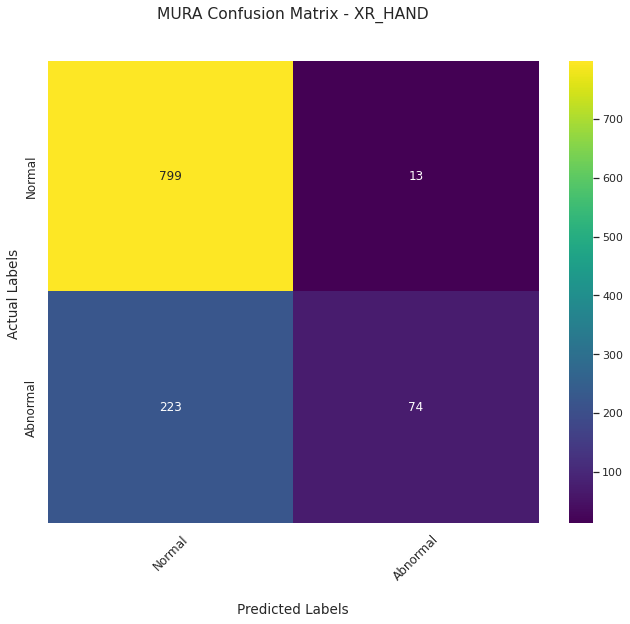




Found 254 validated image filenames belonging to 2 classes.


XR_HUMERUS


Metrics for the dev set:
loss        : 0.5282452702522278
f1          : 0.740208089351654
pr_auc      : 0.8508081436157227
roc_auc     : 0.8645833730697632
precision   : 0.8494623899459839
recall      : 0.6583333611488342
binary_acc  : 0.7834645509719849
tp          : 79.0
fp          : 14.0
tn          : 120.0
fn          : 41.0
cohen_kappa : 0.5604429841041565

Precision, recall, F1 scores for each class(dev set)
              precision    recall  f1-score   support

      Normal       0.75      0.90      0.81       134
    Abnormal       0.85      0.66      0.74       120

    accuracy                           0.78       254
   macro avg       0.80      0.78      0.78       254
weighted avg       0.79      0.78      0.78       254


Precision Recall AUC score for the normal class(dev set):
0.8511499340263744

Precision Recall AUC score for the abnormal class(dev set):
0.8471004075231021

Macro-averaged Pr

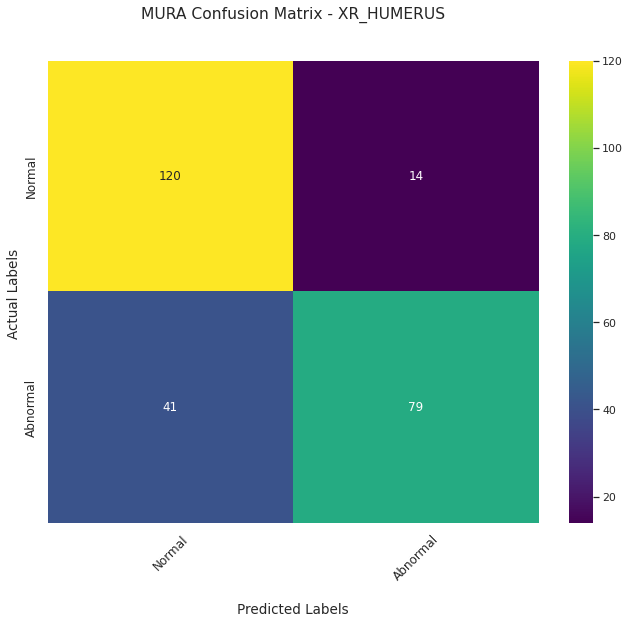




Found 1676 validated image filenames belonging to 2 classes.


XR_SHOULDER


Metrics for the dev set:
loss        : 0.5023258328437805
f1          : 0.7302427291870117
pr_auc      : 0.8590526580810547
roc_auc     : 0.8491009473800659
precision   : 0.8455657362937927
recall      : 0.6630695462226868
binary_acc  : 0.7720763683319092
tp          : 553.0
fp          : 101.0
tn          : 741.0
fn          : 281.0
cohen_kappa : 0.5436744689941406

Precision, recall, F1 scores for each class(dev set)
              precision    recall  f1-score   support

      Normal       0.73      0.88      0.80       842
    Abnormal       0.85      0.66      0.74       834

    accuracy                           0.77      1676
   macro avg       0.79      0.77      0.77      1676
weighted avg       0.79      0.77      0.77      1676


Precision Recall AUC score for the normal class(dev set):
0.8224979333880358

Precision Recall AUC score for the abnormal class(dev set):
0.8591897664790669

Macro-avera

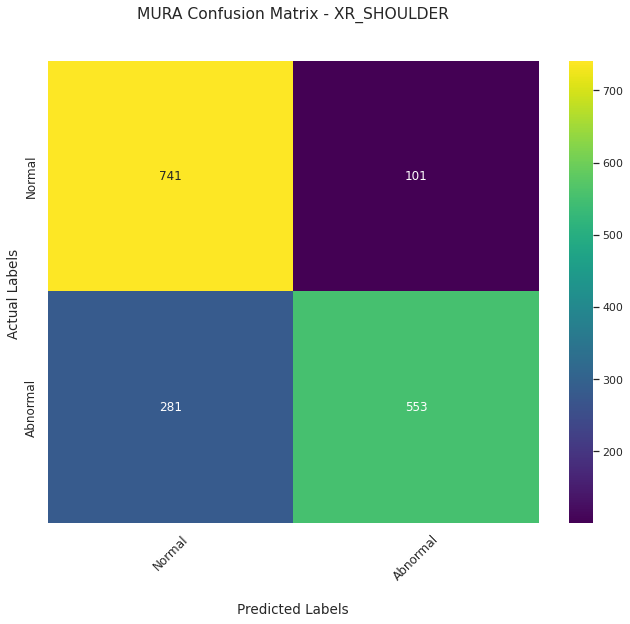




Found 1950 validated image filenames belonging to 2 classes.


XR_WRIST  


Metrics for the dev set:
loss        : 0.4329429268836975
f1          : 0.7670623660087585
pr_auc      : 0.8934203386306763
roc_auc     : 0.898363471031189
precision   : 0.9318996667861938
recall      : 0.6524466872215271
binary_acc  : 0.8384615182876587
tp          : 520.0
fp          : 38.0
tn          : 1115.0
fn          : 277.0
cohen_kappa : 0.6495603322982788

Precision, recall, F1 scores for each class(dev set)
              precision    recall  f1-score   support

      Normal       0.80      0.97      0.88      1153
    Abnormal       0.93      0.65      0.77       797

    accuracy                           0.84      1950
   macro avg       0.87      0.81      0.82      1950
weighted avg       0.85      0.84      0.83      1950


Precision Recall AUC score for the normal class(dev set):
0.9062801375192032

Precision Recall AUC score for the abnormal class(dev set):
0.8938369947614626

Macro-average

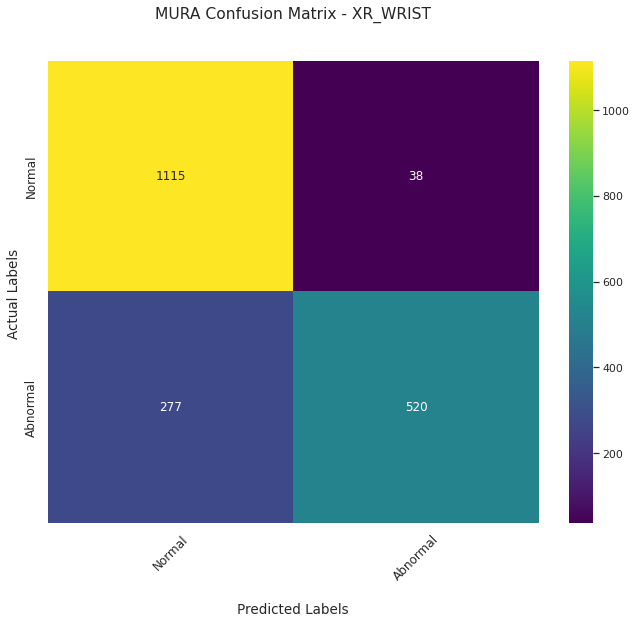

In [ ]:
report(dev, 'dev', 'rgb', MURA_ResNet50, res_datagen_dev_test, chosen_metrics)

Found 465 validated image filenames belonging to 2 classes.


XR_ELBOW  


Metrics for the test set:
loss        : 0.46721115708351135
f1          : 0.3999561071395874
pr_auc      : 0.9213480949401855
roc_auc     : 0.8989084362983704
precision   : 0.95652174949646
recall      : 0.6695652008056641
binary_acc  : 0.8215053677558899
tp          : 154.0
fp          : 7.0
tn          : 228.0
fn          : 76.0
cohen_kappa : 0.6418263912200928

Precision, recall, F1 scores for each class(test set)
              precision    recall  f1-score   support

      Normal       0.75      0.97      0.85       235
    Abnormal       0.96      0.67      0.79       230

    accuracy                           0.82       465
   macro avg       0.85      0.82      0.82       465
weighted avg       0.85      0.82      0.82       465


Precision Recall AUC score for the normal class(test set):
0.8509453169930725

Precision Recall AUC score for the abnormal class(test set):
0.9213934519438921

Macro-averaged P

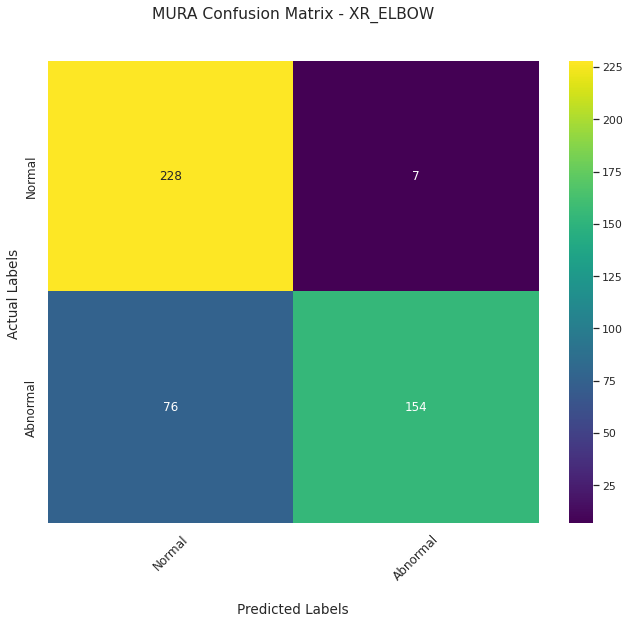




Found 461 validated image filenames belonging to 2 classes.


XR_FINGER 


Metrics for the test set:
loss        : 0.696222722530365
f1          : 0.42798689007759094
pr_auc      : 0.8695826530456543
roc_auc     : 0.8293068408966064
precision   : 0.9054054021835327
recall      : 0.5425100922584534
binary_acc  : 0.7245119214057922
tp          : 134.0
fp          : 14.0
tn          : 200.0
fn          : 113.0
cohen_kappa : 0.46278780698776245

Precision, recall, F1 scores for each class(test set)
              precision    recall  f1-score   support

      Normal       0.64      0.93      0.76       214
    Abnormal       0.91      0.54      0.68       247

    accuracy                           0.72       461
   macro avg       0.77      0.74      0.72       461
weighted avg       0.78      0.72      0.72       461


Precision Recall AUC score for the normal class(test set):
0.7717732362621872

Precision Recall AUC score for the abnormal class(test set):
0.869296509923813

Macro-aver

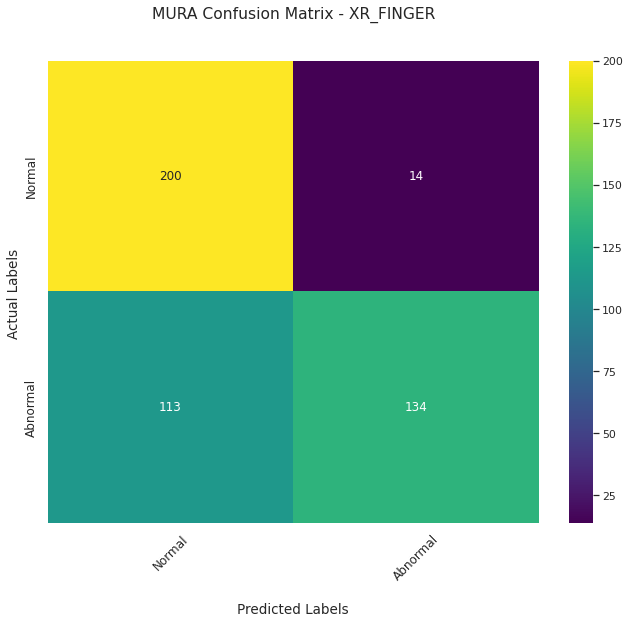




Found 301 validated image filenames belonging to 2 classes.


XR_FOREARM


Metrics for the test set:
loss        : 0.622978925704956
f1          : 0.49472641944885254
pr_auc      : 0.9048169851303101
roc_auc     : 0.8703311085700989
precision   : 0.9883720874786377
recall      : 0.5629138946533203
binary_acc  : 0.7774086594581604
tp          : 85.0
fp          : 1.0
tn          : 149.0
fn          : 66.0
cohen_kappa : 0.5554502606391907

Precision, recall, F1 scores for each class(test set)
              precision    recall  f1-score   support

      Normal       0.69      0.99      0.82       150
    Abnormal       0.99      0.56      0.72       151

    accuracy                           0.78       301
   macro avg       0.84      0.78      0.77       301
weighted avg       0.84      0.78      0.77       301


Precision Recall AUC score for the normal class(test set):
0.8171918417296201

Precision Recall AUC score for the abnormal class(test set):
0.9051173708075562

Macro-average

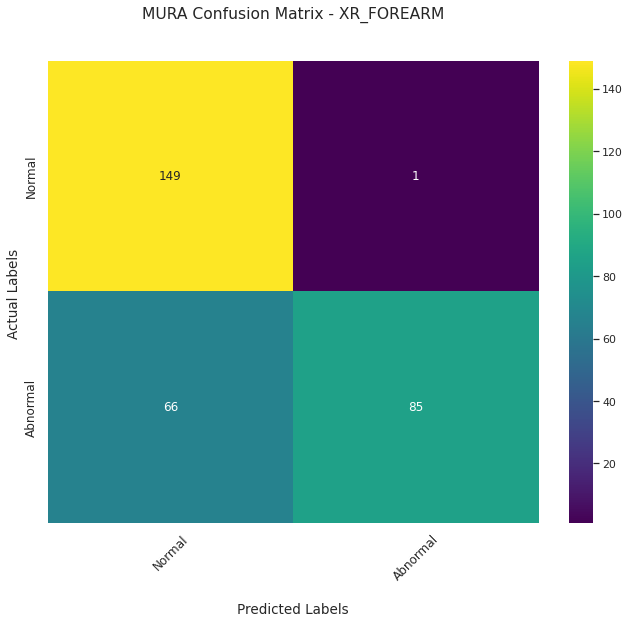




Found 460 validated image filenames belonging to 2 classes.


XR_HAND   


Metrics for the test set:
loss        : 0.72184157371521
f1          : 0.23618535697460175
pr_auc      : 0.7944485545158386
roc_auc     : 0.8164743185043335
precision   : 0.8970588445663452
recall      : 0.32275131344795227
binary_acc  : 0.70652174949646
tp          : 61.0
fp          : 7.0
tn          : 264.0
fn          : 128.0
cohen_kappa : 0.32876479625701904

Precision, recall, F1 scores for each class(test set)
              precision    recall  f1-score   support

      Normal       0.67      0.97      0.80       271
    Abnormal       0.90      0.32      0.47       189

    accuracy                           0.71       460
   macro avg       0.79      0.65      0.64       460
weighted avg       0.77      0.71      0.66       460


Precision Recall AUC score for the normal class(test set):
0.8263896166264721

Precision Recall AUC score for the abnormal class(test set):
0.7943950389133152

Macro-average

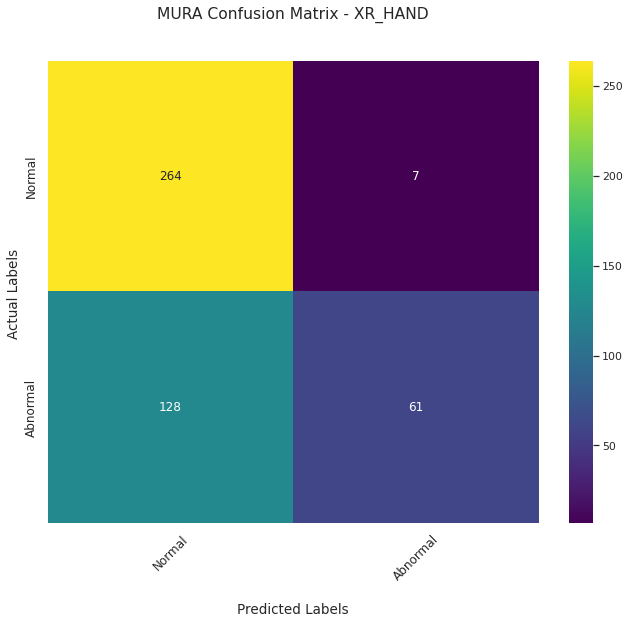




Found 288 validated image filenames belonging to 2 classes.


XR_HUMERUS


Metrics for the test set:
loss        : 0.47117048501968384
f1          : 0.4927690923213959
pr_auc      : 0.8568223118782043
roc_auc     : 0.896645724773407
precision   : 0.8790322542190552
recall      : 0.7785714268684387
binary_acc  : 0.8402777910232544
tp          : 109.0
fp          : 15.0
tn          : 133.0
fn          : 31.0
cohen_kappa : 0.6793183088302612

Precision, recall, F1 scores for each class(test set)
              precision    recall  f1-score   support

      Normal       0.81      0.90      0.85       148
    Abnormal       0.88      0.78      0.83       140

    accuracy                           0.84       288
   macro avg       0.85      0.84      0.84       288
weighted avg       0.84      0.84      0.84       288


Precision Recall AUC score for the normal class(test set):
0.9103368894788425

Precision Recall AUC score for the abnormal class(test set):
0.849616315541572

Macro-averag

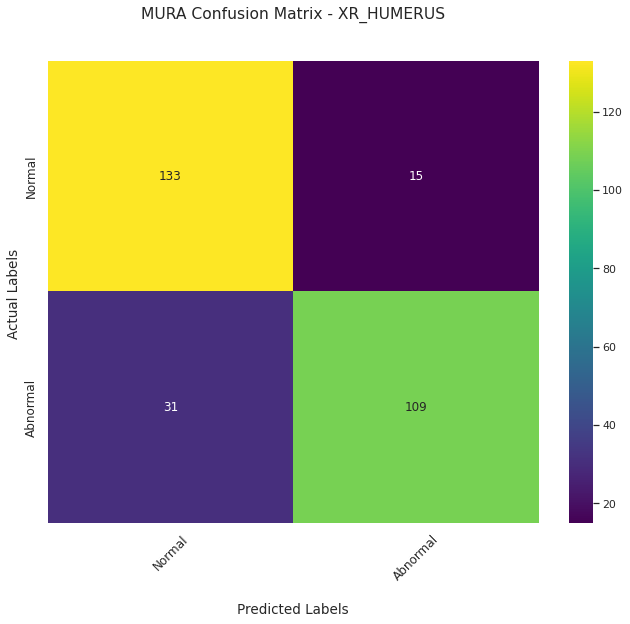




Found 563 validated image filenames belonging to 2 classes.


XR_SHOULDER


Metrics for the test set:
loss        : 0.5827168822288513
f1          : 0.46226826310157776
pr_auc      : 0.8049687147140503
roc_auc     : 0.8176512122154236
precision   : 0.800000011920929
recall      : 0.6906474828720093
binary_acc  : 0.7619893550872803
tp          : 192.0
fp          : 48.0
tn          : 237.0
fn          : 86.0
cohen_kappa : 0.5231044888496399

Precision, recall, F1 scores for each class(test set)
              precision    recall  f1-score   support

      Normal       0.73      0.83      0.78       285
    Abnormal       0.80      0.69      0.74       278

    accuracy                           0.76       563
   macro avg       0.77      0.76      0.76       563
weighted avg       0.77      0.76      0.76       563


Precision Recall AUC score for the normal class(test set):
0.7873522078259284

Precision Recall AUC score for the abnormal class(test set):
0.8097301132339946

Macro-aver

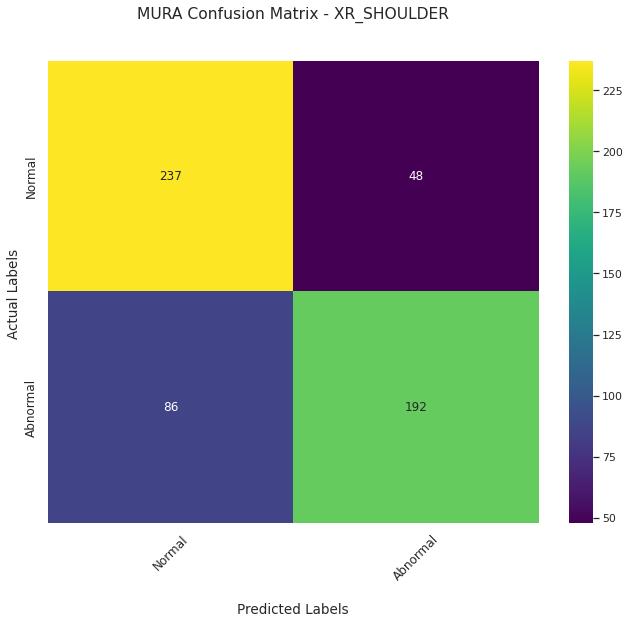




Found 659 validated image filenames belonging to 2 classes.


XR_WRIST  


Metrics for the test set:
loss        : 0.5600445866584778
f1          : 0.37847545742988586
pr_auc      : 0.8655678033828735
roc_auc     : 0.878254771232605
precision   : 0.942105233669281
recall      : 0.6067796349525452
binary_acc  : 0.8072837591171265
tp          : 179.0
fp          : 11.0
tn          : 353.0
fn          : 116.0
cohen_kappa : 0.5966894030570984

Precision, recall, F1 scores for each class(test set)
              precision    recall  f1-score   support

      Normal       0.75      0.97      0.85       364
    Abnormal       0.94      0.61      0.74       295

    accuracy                           0.81       659
   macro avg       0.85      0.79      0.79       659
weighted avg       0.84      0.81      0.80       659


Precision Recall AUC score for the normal class(test set):
0.8772729132323267

Precision Recall AUC score for the abnormal class(test set):
0.8671764402776324

Macro-avera

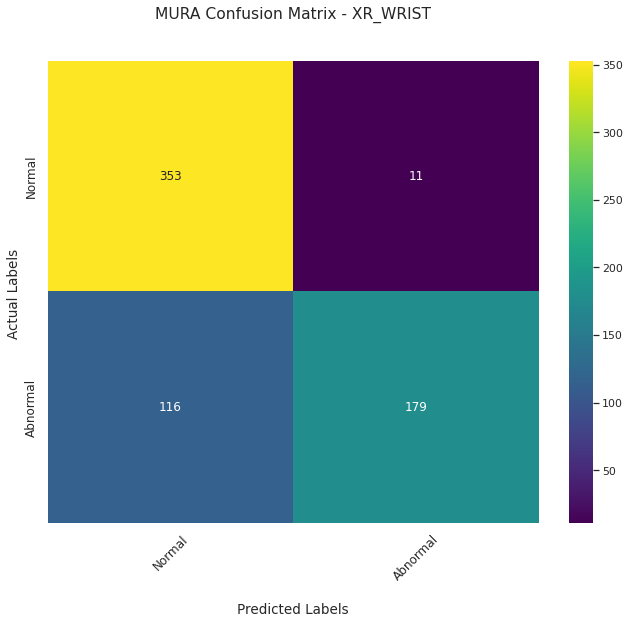

In [ ]:
report(test, 'test', 'rgb', MURA_ResNet50, res_datagen_dev_test, chosen_metrics)

#### ResNet50 with the same rotation of ALL sets

In [ ]:
callbacks = [ReduceLROnPlateau(monitor="val_loss", patience=2, cooldown=2), 
        EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=5, restore_best_weights=True)]
                                                                          # If False, the model weights obtained at the last step of training are used.
                                                                          # else, restores weights from the best epoch in that set.

In [ ]:
# pickle_safe=True, workers = 1, shuffle=False. Please, explain what they do in simple words. Also, why model.evaluate and model.predict give slightly different outputs??? Let's discuss

datagen_same_for_all = ImageDataGenerator(rescale=1/255, rotation_range=30, preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

train_generator = datagen_same_for_all.flow_from_dataframe(dataframe=train, directory=None,
                                              x_col="Paths", y_col="Label",         # 1_hot_labels and categorical
                                              target_size=(224,224), class_mode="binary",
                                              batch_size=128, shuffle=True, color_mode = "rgb", seed=11, fill_mode='constant')

dev_generator = datagen_same_for_all.flow_from_dataframe(dataframe=dev, directory=None,
                                              x_col="Paths", y_col="Label",
                                              target_size=(224,224), class_mode="binary",
                                              batch_size=128, shuffle=False, color_mode = "rgb", seed=11, fill_mode='constant')

test_generator = datagen_same_for_all.flow_from_dataframe(dataframe=test, directory=None,
                                              x_col="Paths", y_col="Label",
                                              target_size=(224,224), class_mode="binary",
                                              batch_size=128, shuffle=False, color_mode = "rgb", seed=11, fill_mode='constant')

Found 29446 validated image filenames belonging to 2 classes.
Found 7362 validated image filenames belonging to 2 classes.
Found 3197 validated image filenames belonging to 2 classes.


In [ ]:
def train_res_model(
        upper_layers_epochs,
        full_network_epochs,
        batch_size,
        mlp_hidden_layers,
        mlp_hidden_activation,
        callbacks):
    
    np.random.seed(1234) # Define the seed for numpy to have reproducible experiments.
    set_seed(1234) # Define the seed for Tensorflow to have reproducible experiments.

    # input = Input(shape = (224,224,3), name='input')
    # example of loading the resnet50 model
    # load model
    res_model = ResNet50(include_top=False, weights = 'imagenet', pooling = 'max') # input_tensor=input,
    # max pooling because we want to emphasize the characteristics extracted (make them sharp)

    x = res_model.output
    #Define MLP layers.
    for i, units in enumerate(mlp_hidden_layers):
        x = Dense(
            units=units,
            kernel_initializer='glorot_uniform',
            activation=mlp_hidden_activation,
            name='Hidden-{0:d}'.format(i + 1)
        )(x)
        x = Dropout(rate=0.2)(x)
   
    
    # Define the output layer.
    output = Dense(
        units=1,
        activation="sigmoid",
        name='Output'
    )(x)

    # Define the model and train it.
    model = Model(inputs = res_model.input, outputs = output)

    #Freeze the resnet model
    # First train the upper layers for a few epochs
    
    for layer in res_model.layers:
        layer.trainable = False

    model.compile(optimizer = 'Adam',
              loss='binary_crossentropy', 
              metrics=chosen_metrics)
    
    upper_layers = model.fit(train_generator, 
                                epochs=upper_layers_epochs, 
                                callbacks=callbacks, 
                                validation_data=dev_generator, 
                                batch_size = 128,
                                verbose=1
                                )
       
    print('Finished training upper layers.')
    print('------------------')

    #Unfreeze the resnet model and train the whole network with a low learning rate

    for layer in res_model.layers:
        layer.trainable = True
    
    model.compile(optimizer = keras.optimizers.Adam(learning_rate=1e-4), #use a very small learning rate. WAS 1e-5!!!!!!!!
              loss='binary_crossentropy', metrics=chosen_metrics)

    full_network = model.fit(train_generator, 
                                epochs=full_network_epochs, 
                                callbacks=callbacks, 
                                validation_data=dev_generator, 
                                batch_size = 128,
                                verbose=1
                                )
       
    print('Finished training full network.')
    print('------------------')

    model.summary() 
    return model, upper_layers, full_network

In [ ]:
# model save # history upper, history bottom
resnet_model, res_upper, res_full = train_res_model(upper_layers_epochs=7,
                                                full_network_epochs=13,
                                                batch_size=128,
                                                mlp_hidden_layers=[512], # one hidden layers
                                                mlp_hidden_activation=ELU(alpha=0.2),
                                                callbacks=callbacks)

Epoch 1/7
231/231 [==============================] - 1001s 4s/step - loss: 0.8205 - pr_auc: 0.4244 - roc_auc: 0.5309 - precision: 0.4313 - recall: 0.2534 - binary_acc: 0.5633 - tp: 3015.0000 - fp: 3975.0000 - tn: 13573.0000 - fn: 8883.0000 - cohen_kappa: 0.0288 - f1: 0.2440 - val_loss: 0.6708 - val_pr_auc: 0.4752 - val_roc_auc: 0.5892 - val_precision: 0.5397 - val_recall: 0.0776 - val_binary_acc: 0.6005 - val_tp: 231.0000 - val_fp: 197.0000 - val_tn: 4190.0000 - val_fn: 2744.0000 - val_cohen_kappa: 0.0380 - val_f1: 0.1328 - lr: 0.0010
Epoch 2/7
231/231 [==============================] - 573s 2s/step - loss: 0.6672 - pr_auc: 0.4458 - roc_auc: 0.5520 - precision: 0.4778 - recall: 0.0886 - binary_acc: 0.5926 - tp: 1054.0000 - fp: 1152.0000 - tn: 16396.0000 - fn: 10844.0000 - cohen_kappa: 0.0264 - f1: 0.1149 - val_loss: 0.6597 - val_pr_auc: 0.4752 - val_roc_auc: 0.5895 - val_precision: 0.6500 - val_recall: 0.0218 - val_binary_acc: 0.6000 - val_tp: 65.0000 - val_fp: 35.0000 - val_tn: 4352.0

INFO:tensorflow:Assets written to: saved_model/MURA_ResNet50_all_same_preprocessing/assets


INFO:tensorflow:Assets written to: saved_model/MURA_ResNet50_all_same_preprocessing/assets


INFO:tensorflow:Assets written to: ram://563429ac-1f7e-4cbe-a1e4-b3c589302a83/assets


INFO:tensorflow:Assets written to: ram://563429ac-1f7e-4cbe-a1e4-b3c589302a83/assets


INFO:tensorflow:Assets written to: ram://7157e614-5fe1-4b98-9863-3c4b9e2e2ad2/assets


INFO:tensorflow:Assets written to: ram://7157e614-5fe1-4b98-9863-3c4b9e2e2ad2/assets


In [ ]:
# resnet_model.save('saved_model/MURA_ResNet50_all_same_preprocessing')

# with open('MURA_ResNet50_all_same_preprocessing_dict_upper.pkl', 'wb') as file_pi:
#       pickle.dump(res_upper, file_pi, pickle.HIGHEST_PROTOCOL)

# with open('MURA_ResNet50_all_same_preprocessing_dict_full.pkl', 'wb') as file_pi:
#       pickle.dump(res_full, file_pi, pickle.HIGHEST_PROTOCOL)

In [ ]:
MURA_ResNet50_same = load_model('saved_model/MURA_ResNet50_all_same_preprocessing', custom_objects={'f1':f1})

with keras.utils.custom_object_scope({"f1": f1}):
  with open('MURA_ResNet50_all_same_preprocessing_dict_upper.pkl', 'rb') as file:
    Res_MURA_upper_same = pickle.load(file)

with keras.utils.custom_object_scope({"f1": f1}):
  with open('MURA_ResNet50_all_same_preprocessing_dict_full.pkl', 'rb') as file:
    Res_MURA_full_same = pickle.load(file)

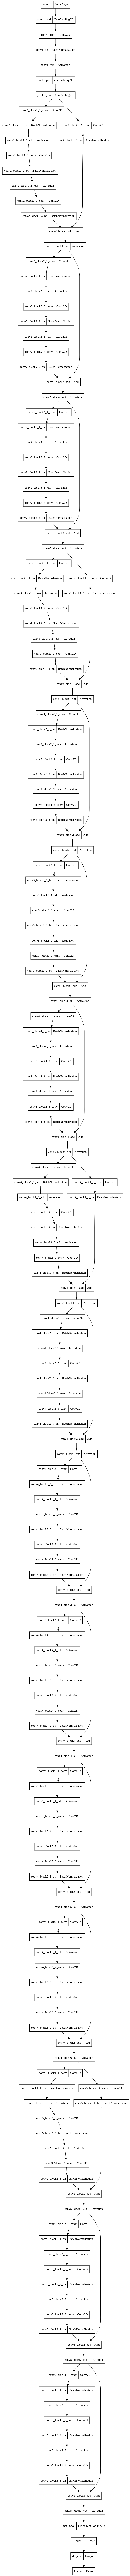

In [ ]:
tf.keras.utils.plot_model(MURA_ResNet50_same)

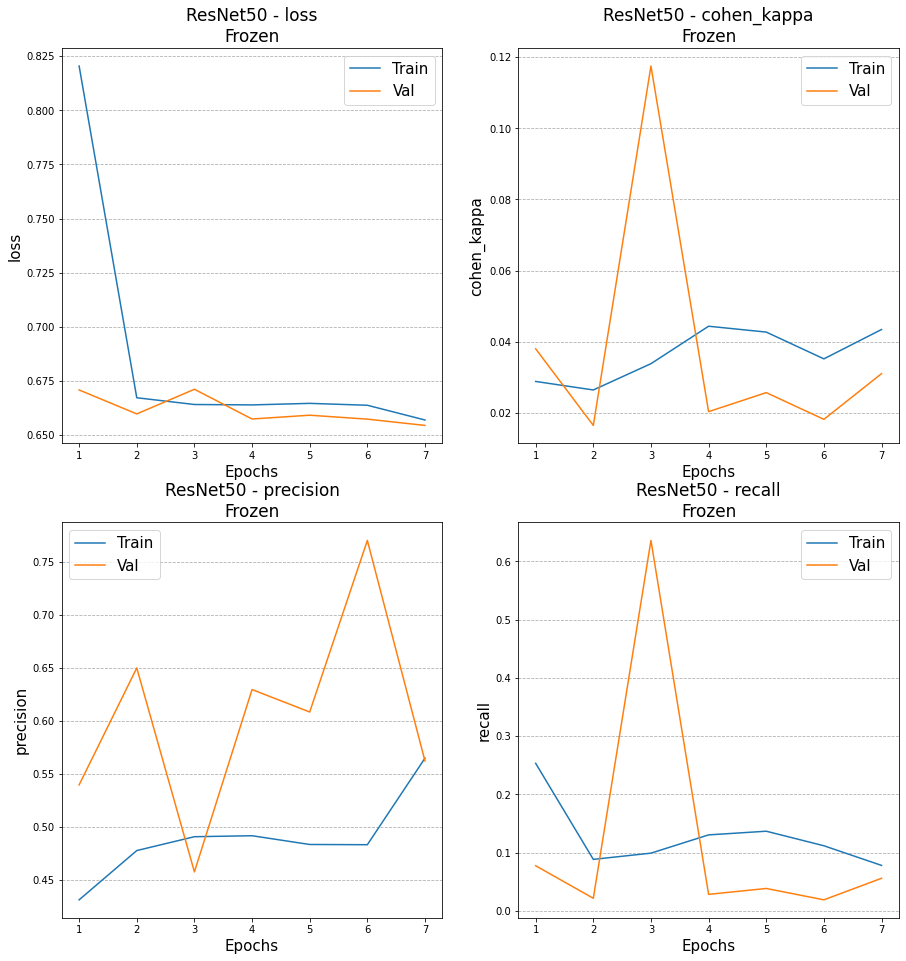

In [ ]:
plot_learning_curves(Res_MURA_upper_same.history, ['Train', 'Val'], '\nFrozen', 'ResNet50 - ')

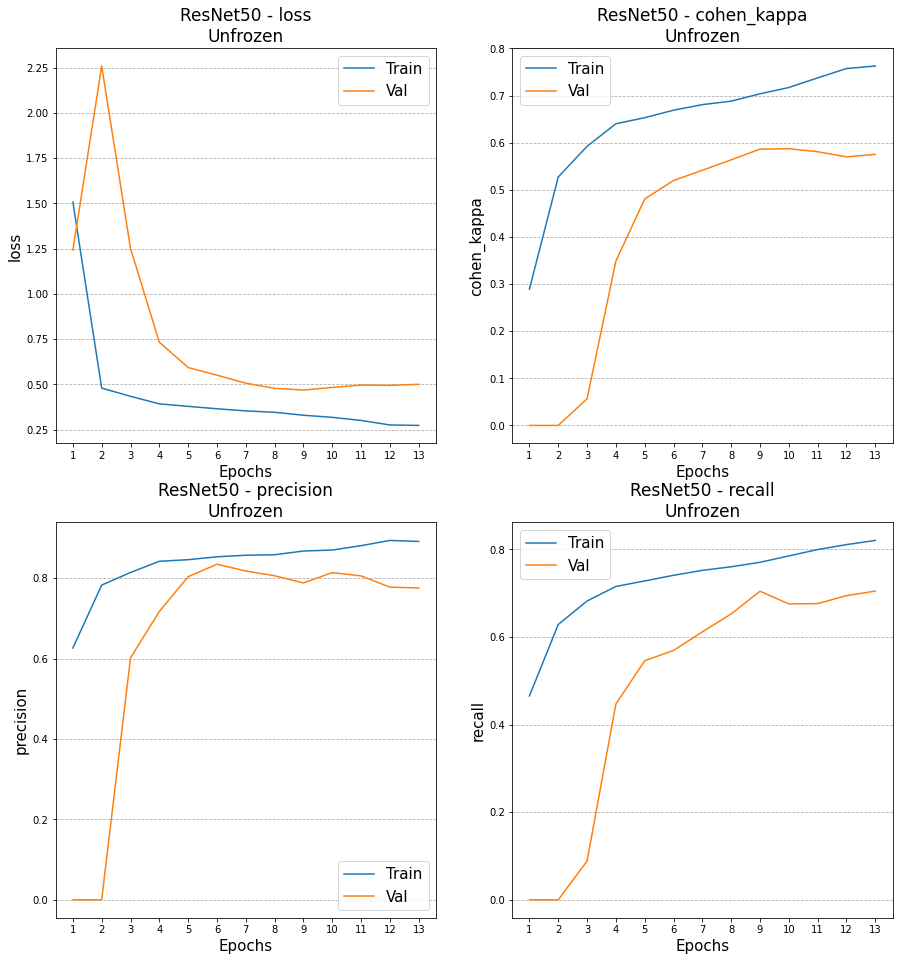

In [ ]:
plot_learning_curves(Res_MURA_full_same.history, ['Train', 'Val'], '\nUnfrozen', 'ResNet50 - ')

In [ ]:
eval_metrics([MURA_ResNet50_same], [train_generator], ['train'], chosen_metrics, False)

Metrics for the train set:
loss        : 0.2512376606464386
f1          : 0.8672240972518921
pr_auc      : 0.9498579502105713
roc_auc     : 0.957888126373291
precision   : 0.9074801206588745
recall      : 0.8350983262062073
binary_acc  : 0.8989676237106323
tp          : 9936.0
fp          : 1013.0
tn          : 16535.0
fn          : 1962.0
cohen_kappa : 0.7874826192855835


Metrics for the development set:
loss        : 0.4947594702243805
f1          : 0.7399058938026428
pr_auc      : 0.8328132033348083
roc_auc     : 0.8584548234939575
precision   : 0.7760263681411743
recall      : 0.711596667766571
binary_acc  : 0.8004618287086487
tp          : 2117.0
fp          : 611.0
tn          : 3776.0
fn          : 858.0
cohen_kappa : 0.5800719857215881


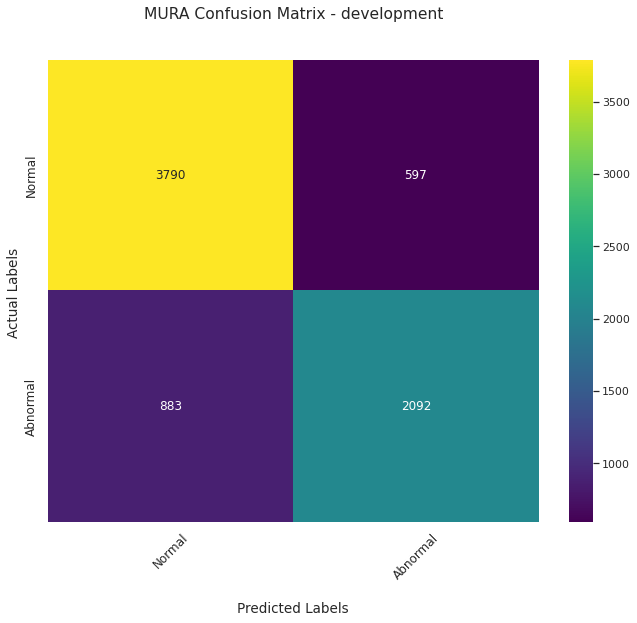

In [ ]:
eval_metrics([MURA_ResNet50_same], [dev_generator], ['development'], chosen_metrics, True)

Metrics for the test set:
loss        : 0.537723183631897
f1          : 0.5733949542045593
pr_auc      : 0.8569533228874207
roc_auc     : 0.8518131971359253
precision   : 0.8113636374473572
recall      : 0.699999988079071
binary_acc  : 0.7785423994064331
tp          : 1071.0
fp          : 249.0
tn          : 1418.0
fn          : 459.0
cohen_kappa : 0.5537530779838562


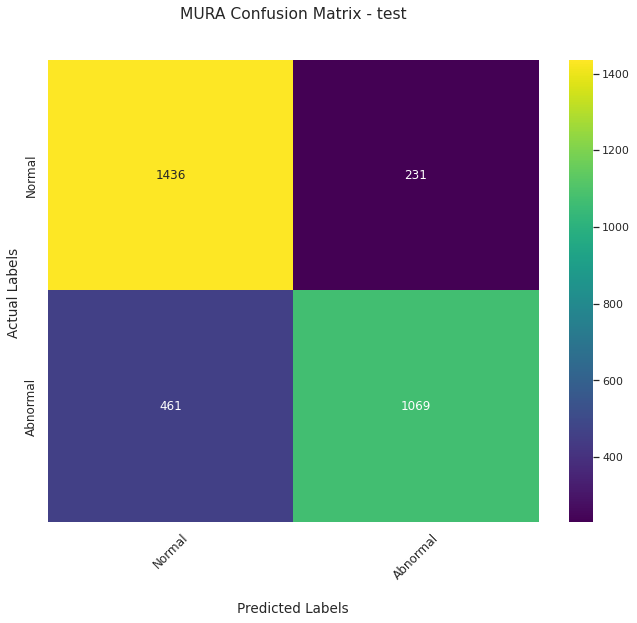

In [ ]:
eval_metrics([MURA_ResNet50_same], [test_generator], ['test'], chosen_metrics, True)

Found 3945 validated image filenames belonging to 2 classes.


XR_ELBOW  


Metrics for the train set:
loss        : 0.23816338181495667
f1          : 0.8831214904785156
pr_auc      : 0.9552631378173828
roc_auc     : 0.959659218788147
precision   : 0.9298486709594727
recall      : 0.8423675894737244
binary_acc  : 0.9100126624107361
tp          : 1352.0
fp          : 102.0
tn          : 2238.0
fn          : 253.0
cohen_kappa : 0.8107572197914124

Precision, recall, F1 scores for each class(train set)
              precision    recall  f1-score   support

      Normal       0.89      0.95      0.92      2340
    Abnormal       0.93      0.84      0.88      1605

    accuracy                           0.91      3945
   macro avg       0.91      0.89      0.90      3945
weighted avg       0.91      0.91      0.91      3945


Precision Recall AUC score for the normal class(train set):
0.9653815639531742

Precision Recall AUC score for the abnormal class(train set):
0.9555375416384685

Macro

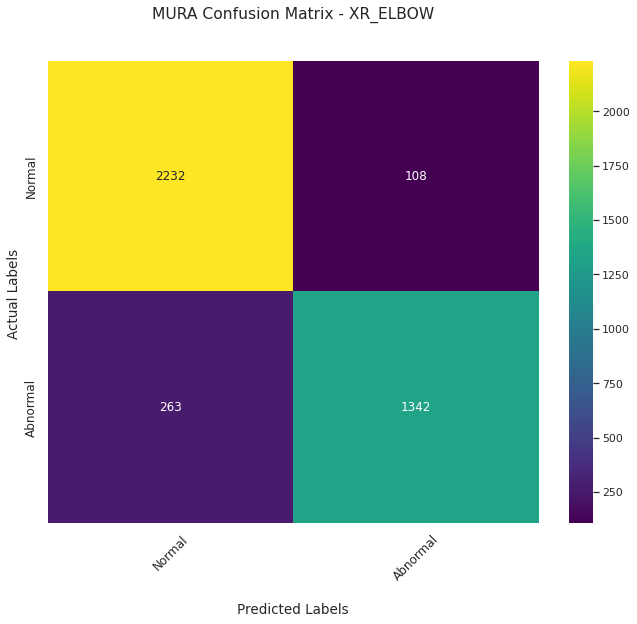




Found 4084 validated image filenames belonging to 2 classes.


XR_FINGER 


Metrics for the train set:
loss        : 0.24224375188350677
f1          : 0.8671035170555115
pr_auc      : 0.9499116539955139
roc_auc     : 0.9609957933425903
precision   : 0.9112508893013
recall      : 0.828462541103363
binary_acc  : 0.9027913808822632
tp          : 1304.0
fp          : 127.0
tn          : 2383.0
fn          : 270.0
cohen_kappa : 0.7912687063217163

Precision, recall, F1 scores for each class(train set)
              precision    recall  f1-score   support

      Normal       0.90      0.95      0.92      2510
    Abnormal       0.91      0.84      0.87      1574

    accuracy                           0.90      4084
   macro avg       0.91      0.89      0.90      4084
weighted avg       0.90      0.90      0.90      4084


Precision Recall AUC score for the normal class(train set):
0.9686111943333262

Precision Recall AUC score for the abnormal class(train set):
0.946368345590596

Macro-

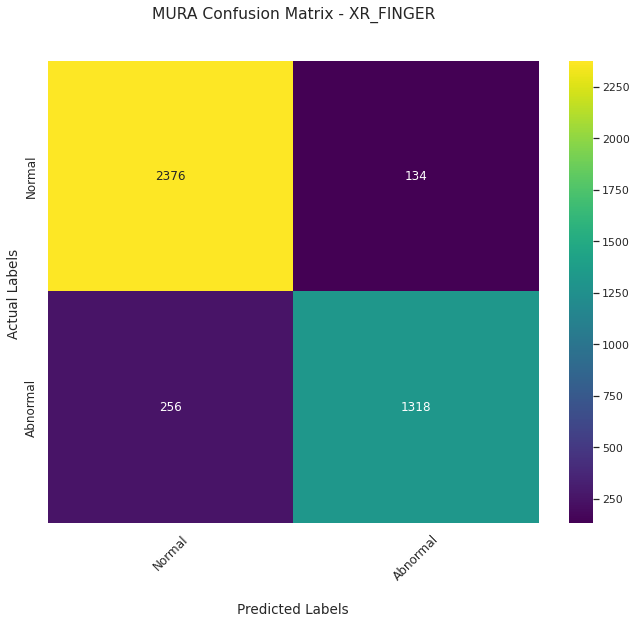




Found 1460 validated image filenames belonging to 2 classes.


XR_FOREARM


Metrics for the train set:
loss        : 0.2232341170310974
f1          : 0.8810349106788635
pr_auc      : 0.9502371549606323
roc_auc     : 0.961945116519928
precision   : 0.9213250279426575
recall      : 0.8412098288536072
binary_acc  : 0.9164383411407471
tp          : 445.0
fp          : 38.0
tn          : 893.0
fn          : 84.0
cohen_kappa : 0.8157073259353638

Precision, recall, F1 scores for each class(train set)
              precision    recall  f1-score   support

      Normal       0.92      0.97      0.94       931
    Abnormal       0.93      0.85      0.89       529

    accuracy                           0.92      1460
   macro avg       0.93      0.91      0.91      1460
weighted avg       0.92      0.92      0.92      1460


Precision Recall AUC score for the normal class(train set):
0.9765349779983985

Precision Recall AUC score for the abnormal class(train set):
0.957690673360194

Macro-av

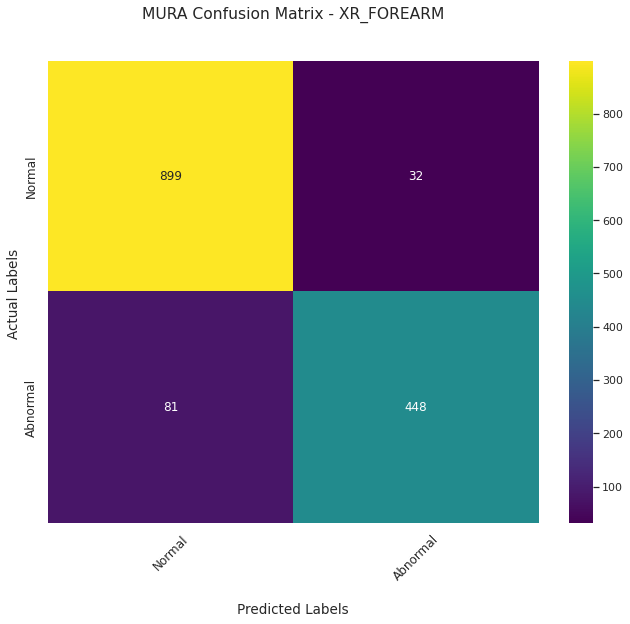




Found 4434 validated image filenames belonging to 2 classes.


XR_HAND   


Metrics for the train set:
loss        : 0.2836158275604248
f1          : 0.7504217028617859
pr_auc      : 0.8675594329833984
roc_auc     : 0.929077684879303
precision   : 0.8693743348121643
recall      : 0.6672282814979553
binary_acc  : 0.8840776085853577
tp          : 792.0
fp          : 119.0
tn          : 3128.0
fn          : 395.0
cohen_kappa : 0.6807935237884521

Precision, recall, F1 scores for each class(train set)
              precision    recall  f1-score   support

      Normal       0.89      0.97      0.93      3247
    Abnormal       0.88      0.66      0.76      1187

    accuracy                           0.89      4434
   macro avg       0.88      0.82      0.84      4434
weighted avg       0.89      0.89      0.88      4434


Precision Recall AUC score for the normal class(train set):
0.9712463674953942

Precision Recall AUC score for the abnormal class(train set):
0.8708820166035599

Macr

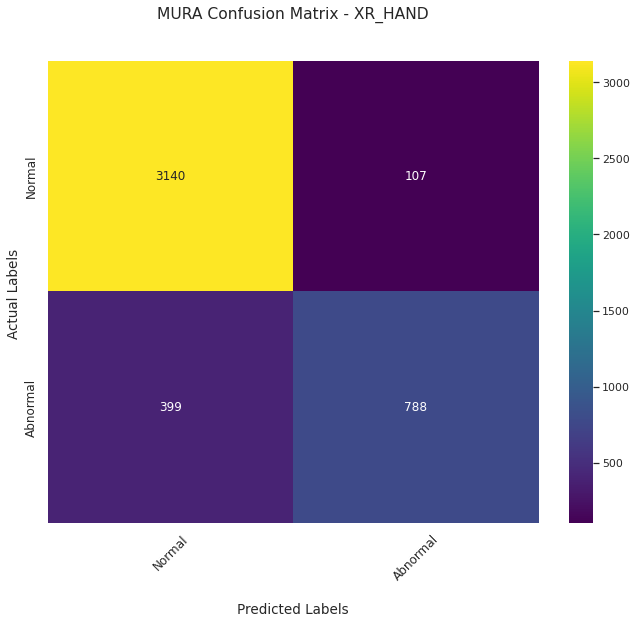




Found 1018 validated image filenames belonging to 2 classes.


XR_HUMERUS


Metrics for the train set:
loss        : 0.21452033519744873
f1          : 0.9017839431762695
pr_auc      : 0.9713144302368164
roc_auc     : 0.9733907580375671
precision   : 0.9071729779243469
recall      : 0.8977035284042358
binary_acc  : 0.9086443781852722
tp          : 430.0
fp          : 44.0
tn          : 495.0
fn          : 49.0
cohen_kappa : 0.816545307636261

Precision, recall, F1 scores for each class(train set)
              precision    recall  f1-score   support

      Normal       0.92      0.94      0.93       539
    Abnormal       0.93      0.90      0.92       479

    accuracy                           0.92      1018
   macro avg       0.92      0.92      0.92      1018
weighted avg       0.92      0.92      0.92      1018


Precision Recall AUC score for the normal class(train set):
0.9758880907224364

Precision Recall AUC score for the abnormal class(train set):
0.9750019863912377

Macro-

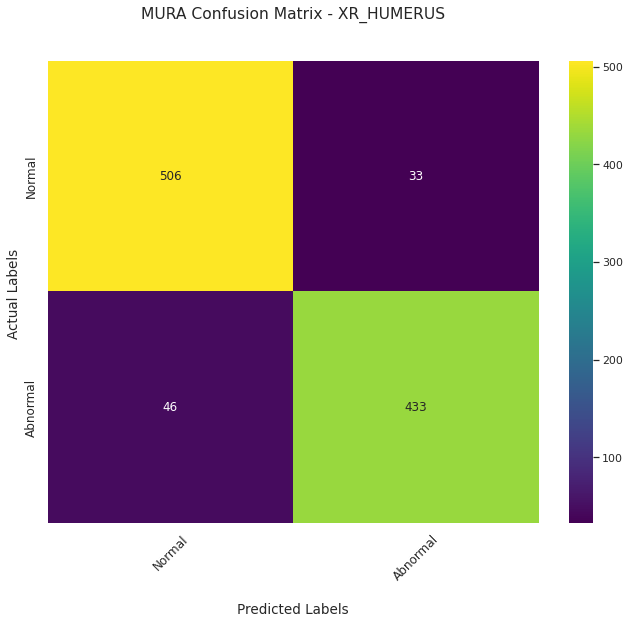




Found 6703 validated image filenames belonging to 2 classes.


XR_SHOULDER


Metrics for the train set:
loss        : 0.27332940697669983
f1          : 0.8799978494644165
pr_auc      : 0.9598265886306763
roc_auc     : 0.9555308222770691
precision   : 0.9072132110595703
recall      : 0.8563287258148193
binary_acc  : 0.884976863861084
tp          : 2855.0
fp          : 292.0
tn          : 3077.0
fn          : 479.0
cohen_kappa : 0.769880473613739

Precision, recall, F1 scores for each class(train set)
              precision    recall  f1-score   support

      Normal       0.87      0.91      0.89      3369
    Abnormal       0.90      0.86      0.88      3334

    accuracy                           0.88      6703
   macro avg       0.89      0.88      0.88      6703
weighted avg       0.89      0.88      0.88      6703


Precision Recall AUC score for the normal class(train set):
0.9495470703975077

Precision Recall AUC score for the abnormal class(train set):
0.9585863145888717

Ma

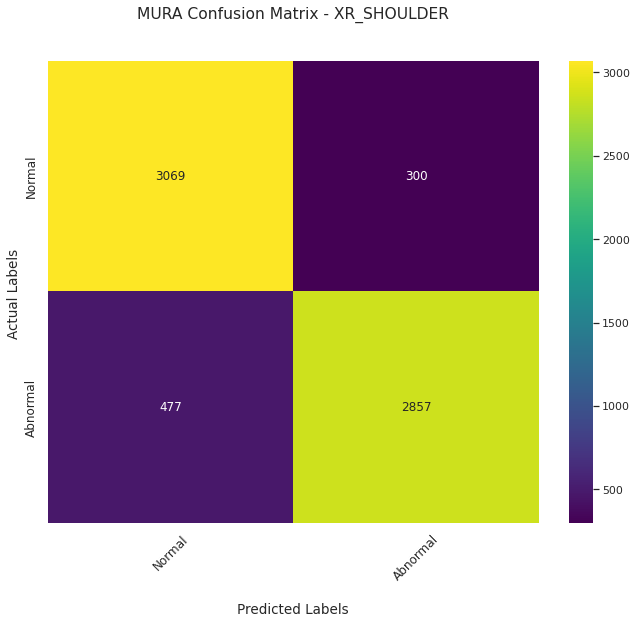




Found 7802 validated image filenames belonging to 2 classes.


XR_WRIST  


Metrics for the train set:
loss        : 0.23357392847537994
f1          : 0.8814578652381897
pr_auc      : 0.9571132063865662
roc_auc     : 0.9628844857215881
precision   : 0.9148721694946289
recall      : 0.8523510694503784
binary_acc  : 0.9072032570838928
tp          : 2719.0
fp          : 253.0
tn          : 4359.0
fn          : 471.0
cohen_kappa : 0.8059854507446289

Precision, recall, F1 scores for each class(train set)
              precision    recall  f1-score   support

      Normal       0.90      0.94      0.92      4612
    Abnormal       0.91      0.85      0.88      3190

    accuracy                           0.90      7802
   macro avg       0.90      0.90      0.90      7802
weighted avg       0.90      0.90      0.90      7802


Precision Recall AUC score for the normal class(train set):
0.9699842898552562

Precision Recall AUC score for the abnormal class(train set):
0.9566317992346337

M

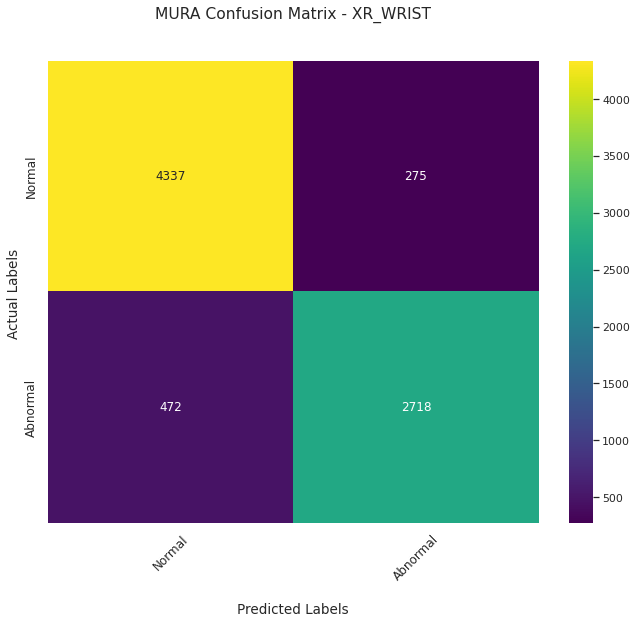

In [ ]:
report(train, 'train', 'rgb', MURA_ResNet50_same, datagen_same_for_all, chosen_metrics)

Found 986 validated image filenames belonging to 2 classes.


XR_ELBOW  


Metrics for the dev set:
loss        : 0.48856258392333984
f1          : 0.7577794194221497
pr_auc      : 0.8437402248382568
roc_auc     : 0.8574931025505066
precision   : 0.8096590638160706
recall      : 0.7107232213020325
binary_acc  : 0.8144016265869141
tp          : 285.0
fp          : 67.0
tn          : 518.0
fn          : 116.0
cohen_kappa : 0.6078747510910034

Precision, recall, F1 scores for each class(dev set)
              precision    recall  f1-score   support

      Normal       0.81      0.88      0.85       585
    Abnormal       0.80      0.71      0.75       401

    accuracy                           0.81       986
   macro avg       0.81      0.79      0.80       986
weighted avg       0.81      0.81      0.81       986


Precision Recall AUC score for the normal class(dev set):
0.8595591207839126

Precision Recall AUC score for the abnormal class(dev set):
0.8520676506869733

Macro-averaged P

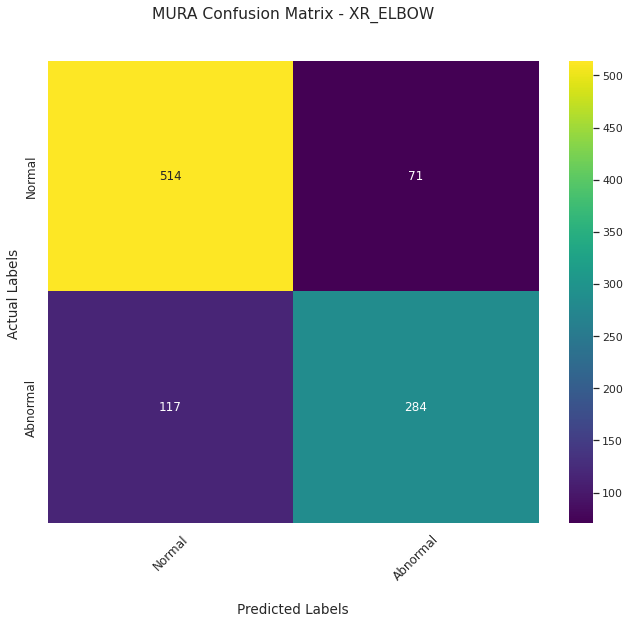




Found 1022 validated image filenames belonging to 2 classes.


XR_FINGER 


Metrics for the dev set:
loss        : 0.5830604434013367
f1          : 0.7097656726837158
pr_auc      : 0.7747011184692383
roc_auc     : 0.8321437835693359
precision   : 0.7369862794876099
recall      : 0.682741105556488
binary_acc  : 0.7837573289871216
tp          : 269.0
fp          : 96.0
tn          : 532.0
fn          : 125.0
cohen_kappa : 0.5372419357299805

Precision, recall, F1 scores for each class(dev set)
              precision    recall  f1-score   support

      Normal       0.81      0.85      0.83       628
    Abnormal       0.74      0.68      0.71       394

    accuracy                           0.79      1022
   macro avg       0.78      0.77      0.77      1022
weighted avg       0.78      0.79      0.78      1022


Precision Recall AUC score for the normal class(dev set):
0.8770076036901209

Precision Recall AUC score for the abnormal class(dev set):
0.7897025376961296

Macro-averaged

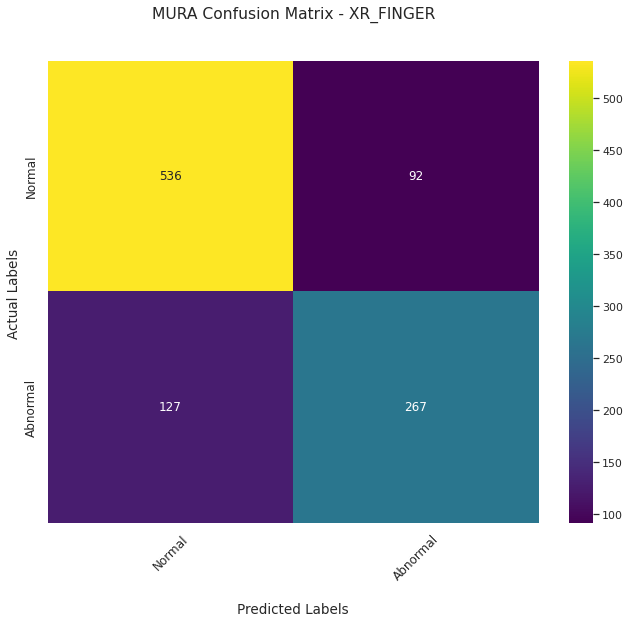




Found 365 validated image filenames belonging to 2 classes.


XR_FOREARM


Metrics for the dev set:
loss        : 0.5482003688812256
f1          : 0.7323735356330872
pr_auc      : 0.7987711429595947
roc_auc     : 0.8450383543968201
precision   : 0.7622950673103333
recall      : 0.7045454382896423
binary_acc  : 0.8136986494064331
tp          : 93.0
fp          : 29.0
tn          : 204.0
fn          : 39.0
cohen_kappa : 0.5897656679153442

Precision, recall, F1 scores for each class(dev set)
              precision    recall  f1-score   support

      Normal       0.83      0.90      0.86       233
    Abnormal       0.79      0.68      0.73       132

    accuracy                           0.82       365
   macro avg       0.81      0.79      0.80       365
weighted avg       0.82      0.82      0.82       365


Precision Recall AUC score for the normal class(dev set):
0.8833963841104189

Precision Recall AUC score for the abnormal class(dev set):
0.8130715867012122

Macro-averaged P

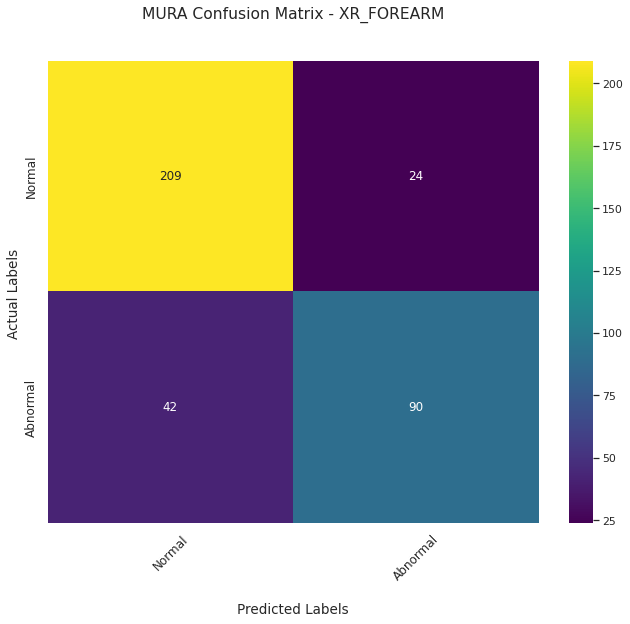




Found 1109 validated image filenames belonging to 2 classes.


XR_HAND   


Metrics for the dev set:
loss        : 0.5300342440605164
f1          : 0.5511491894721985
pr_auc      : 0.6007275581359863
roc_auc     : 0.7599474787712097
precision   : 0.6529680490493774
recall      : 0.48148149251937866
binary_acc  : 0.7926059365272522
tp          : 143.0
fp          : 76.0
tn          : 736.0
fn          : 154.0
cohen_kappa : 0.4231247305870056

Precision, recall, F1 scores for each class(dev set)
              precision    recall  f1-score   support

      Normal       0.82      0.88      0.85       812
    Abnormal       0.58      0.47      0.52       297

    accuracy                           0.77      1109
   macro avg       0.70      0.67      0.68      1109
weighted avg       0.76      0.77      0.76      1109


Precision Recall AUC score for the normal class(dev set):
0.8680905412065345

Precision Recall AUC score for the abnormal class(dev set):
0.597591451250621

Macro-average

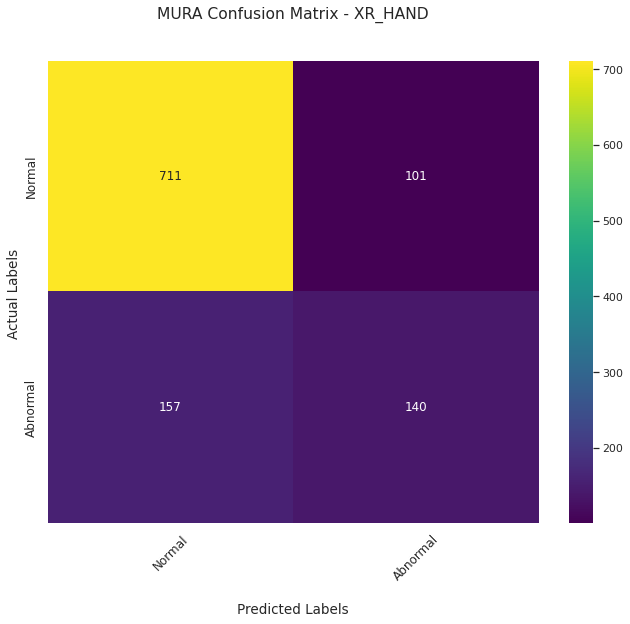




Found 254 validated image filenames belonging to 2 classes.


XR_HUMERUS


Metrics for the dev set:
loss        : 0.5868891477584839
f1          : 0.7597253322601318
pr_auc      : 0.818343997001648
roc_auc     : 0.8491292595863342
precision   : 0.7981651425361633
recall      : 0.7250000238418579
binary_acc  : 0.7834645509719849
tp          : 87.0
fp          : 22.0
tn          : 112.0
fn          : 33.0
cohen_kappa : 0.5635193586349487

Precision, recall, F1 scores for each class(dev set)
              precision    recall  f1-score   support

      Normal       0.77      0.87      0.82       134
    Abnormal       0.83      0.72      0.77       120

    accuracy                           0.80       254
   macro avg       0.80      0.79      0.80       254
weighted avg       0.80      0.80      0.80       254


Precision Recall AUC score for the normal class(dev set):
0.8595685919902092

Precision Recall AUC score for the abnormal class(dev set):
0.8307730680289274

Macro-averaged Pr

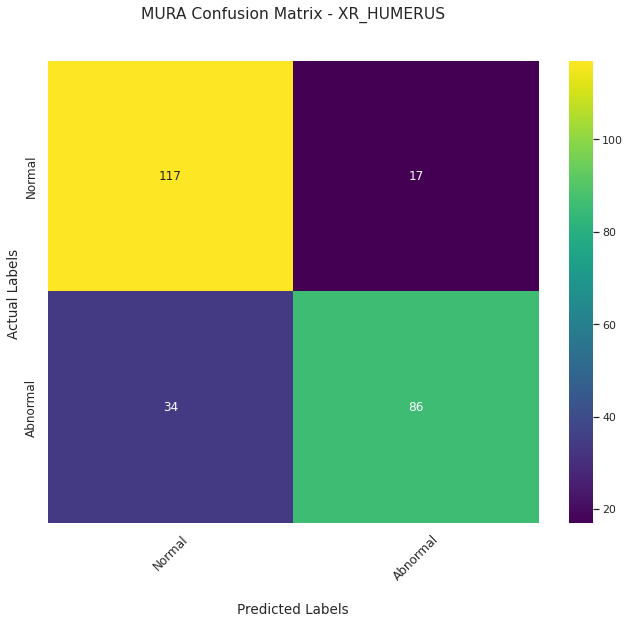




Found 1676 validated image filenames belonging to 2 classes.


XR_SHOULDER


Metrics for the dev set:
loss        : 0.5352290272712708
f1          : 0.7669768333435059
pr_auc      : 0.8473313450813293
roc_auc     : 0.8469856381416321
precision   : 0.7808564305305481
recall      : 0.743405282497406
binary_acc  : 0.7684963941574097
tp          : 620.0
fp          : 174.0
tn          : 668.0
fn          : 214.0
cohen_kappa : 0.5368767380714417

Precision, recall, F1 scores for each class(dev set)
              precision    recall  f1-score   support

      Normal       0.76      0.81      0.78       842
    Abnormal       0.79      0.74      0.76       834

    accuracy                           0.77      1676
   macro avg       0.77      0.77      0.77      1676
weighted avg       0.77      0.77      0.77      1676


Precision Recall AUC score for the normal class(dev set):
0.8172293632642388

Precision Recall AUC score for the abnormal class(dev set):
0.853466096219891

Macro-average

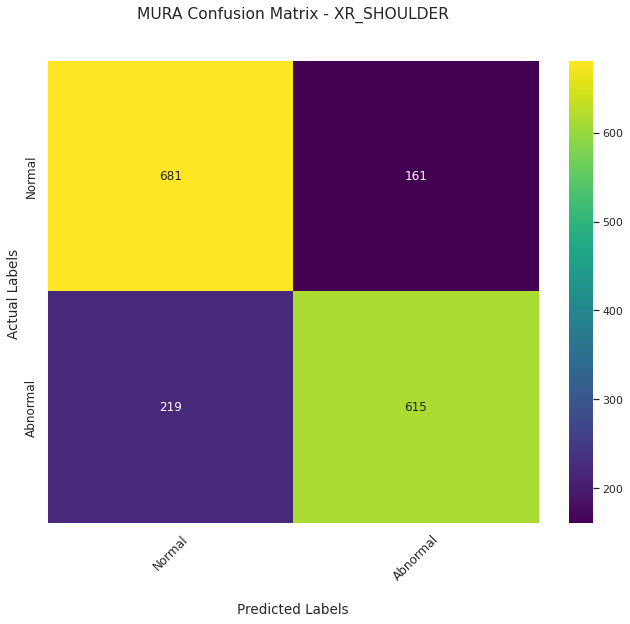




Found 1950 validated image filenames belonging to 2 classes.


XR_WRIST  


Metrics for the dev set:
loss        : 0.38500332832336426
f1          : 0.8117344975471497
pr_auc      : 0.8963107466697693
roc_auc     : 0.9028528332710266
precision   : 0.8243774771690369
recall      : 0.7892095446586609
binary_acc  : 0.8451281785964966
tp          : 629.0
fp          : 134.0
tn          : 1019.0
fn          : 168.0
cohen_kappa : 0.677452564239502

Precision, recall, F1 scores for each class(dev set)
              precision    recall  f1-score   support

      Normal       0.85      0.88      0.86      1153
    Abnormal       0.81      0.78      0.79       797

    accuracy                           0.84      1950
   macro avg       0.83      0.83      0.83      1950
weighted avg       0.83      0.84      0.83      1950


Precision Recall AUC score for the normal class(dev set):
0.9030539014252301

Precision Recall AUC score for the abnormal class(dev set):
0.887003380291969

Macro-averag

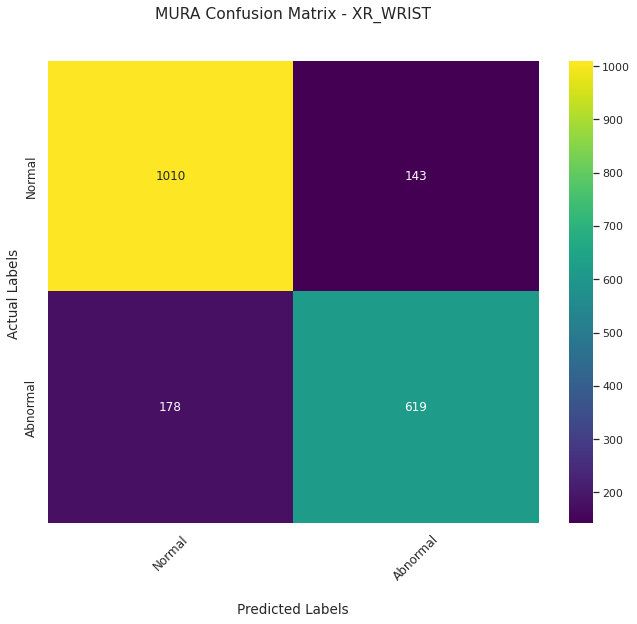

In [ ]:
report(dev, 'dev', 'rgb', MURA_ResNet50_same, datagen_same_for_all, chosen_metrics)

Found 465 validated image filenames belonging to 2 classes.


XR_ELBOW  


Metrics for the test set:
loss        : 0.44560858607292175
f1          : 0.4360359013080597
pr_auc      : 0.8973349332809448
roc_auc     : 0.8918038606643677
precision   : 0.8774510025978088
recall      : 0.7782608866691589
binary_acc  : 0.8365591168403625
tp          : 179.0
fp          : 25.0
tn          : 210.0
fn          : 51.0
cohen_kappa : 0.6726868748664856

Precision, recall, F1 scores for each class(test set)
              precision    recall  f1-score   support

      Normal       0.80      0.89      0.84       235
    Abnormal       0.87      0.78      0.82       230

    accuracy                           0.83       465
   macro avg       0.84      0.83      0.83       465
weighted avg       0.84      0.83      0.83       465


Precision Recall AUC score for the normal class(test set):
0.8762142732162355

Precision Recall AUC score for the abnormal class(test set):
0.9055989415563175

Macro-average

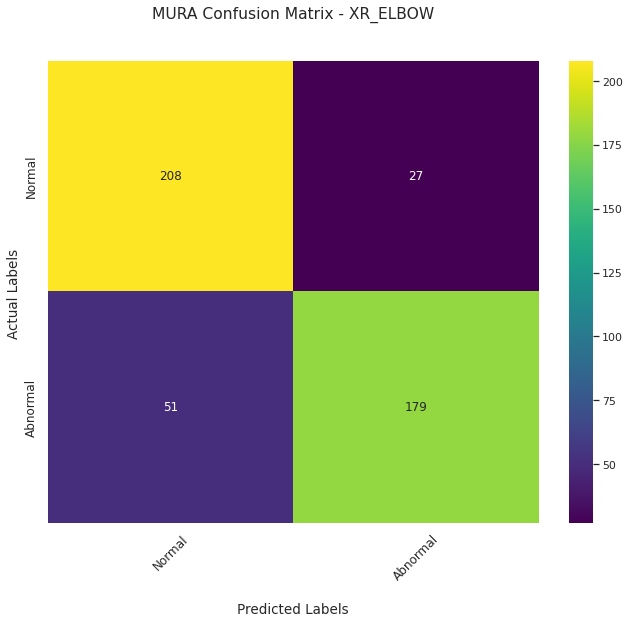




Found 461 validated image filenames belonging to 2 classes.


XR_FINGER 


Metrics for the test set:
loss        : 0.68376225233078
f1          : 0.42509669065475464
pr_auc      : 0.8446706533432007
roc_auc     : 0.81051105260849
precision   : 0.8061224222183228
recall      : 0.6396760940551758
binary_acc  : 0.7245119214057922
tp          : 158.0
fp          : 38.0
tn          : 176.0
fn          : 89.0
cohen_kappa : 0.4548645615577698

Precision, recall, F1 scores for each class(test set)
              precision    recall  f1-score   support

      Normal       0.69      0.86      0.77       214
    Abnormal       0.84      0.67      0.75       247

    accuracy                           0.76       461
   macro avg       0.77      0.76      0.76       461
weighted avg       0.77      0.76      0.76       461


Precision Recall AUC score for the normal class(test set):
0.774504794365771

Precision Recall AUC score for the abnormal class(test set):
0.8630271063885567

Macro-averaged 

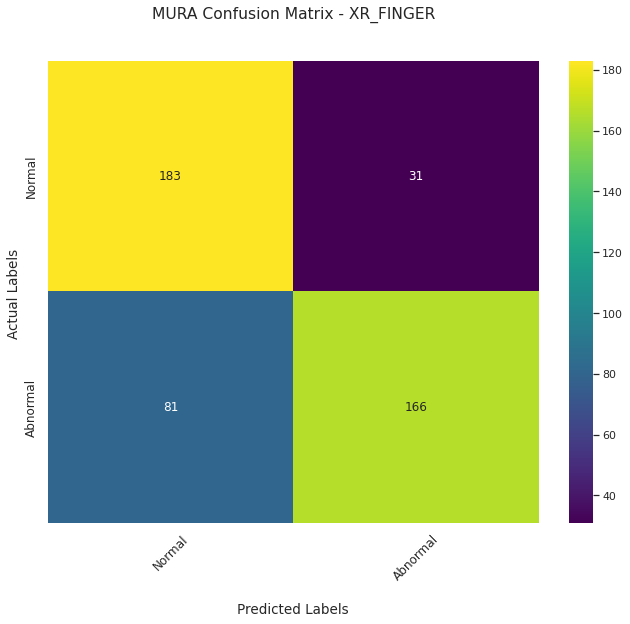




Found 301 validated image filenames belonging to 2 classes.


XR_FOREARM


Metrics for the test set:
loss        : 0.5777998566627502
f1          : 0.48366010189056396
pr_auc      : 0.8766583800315857
roc_auc     : 0.8433554172515869
precision   : 0.8828828930854797
recall      : 0.6490066051483154
binary_acc  : 0.7807309031486511
tp          : 98.0
fp          : 13.0
tn          : 137.0
fn          : 53.0
cohen_kappa : 0.5618438720703125

Precision, recall, F1 scores for each class(test set)
              precision    recall  f1-score   support

      Normal       0.71      0.90      0.79       150
    Abnormal       0.86      0.64      0.73       151

    accuracy                           0.77       301
   macro avg       0.79      0.77      0.76       301
weighted avg       0.79      0.77      0.76       301


Precision Recall AUC score for the normal class(test set):
0.8314056094703626

Precision Recall AUC score for the abnormal class(test set):
0.8857989588602238

Macro-avera

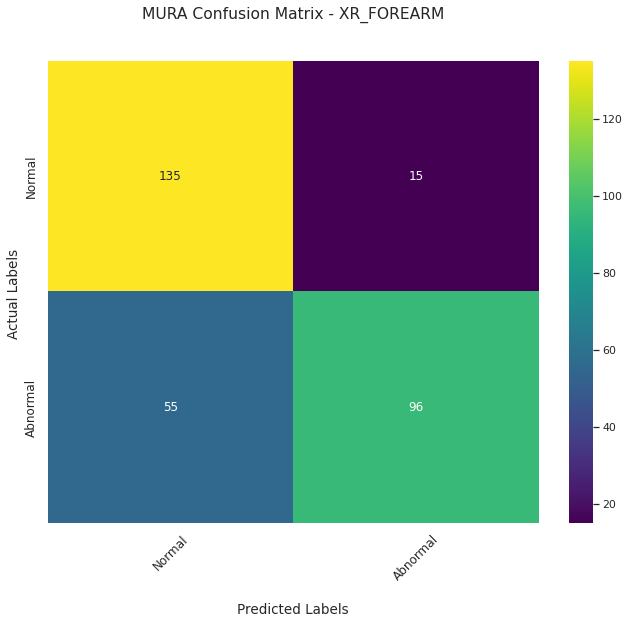




Found 460 validated image filenames belonging to 2 classes.


XR_HAND   


Metrics for the test set:
loss        : 0.5804099440574646
f1          : 0.3480137586593628
pr_auc      : 0.7889351844787598
roc_auc     : 0.812901496887207
precision   : 0.807692289352417
recall      : 0.5555555820465088
binary_acc  : 0.7630434632301331
tp          : 105.0
fp          : 25.0
tn          : 246.0
fn          : 84.0
cohen_kappa : 0.4862704873085022

Precision, recall, F1 scores for each class(test set)
              precision    recall  f1-score   support

      Normal       0.75      0.90      0.82       271
    Abnormal       0.79      0.57      0.66       189

    accuracy                           0.76       460
   macro avg       0.77      0.73      0.74       460
weighted avg       0.77      0.76      0.75       460


Precision Recall AUC score for the normal class(test set):
0.8194773117003952

Precision Recall AUC score for the abnormal class(test set):
0.7829225969440083

Macro-average

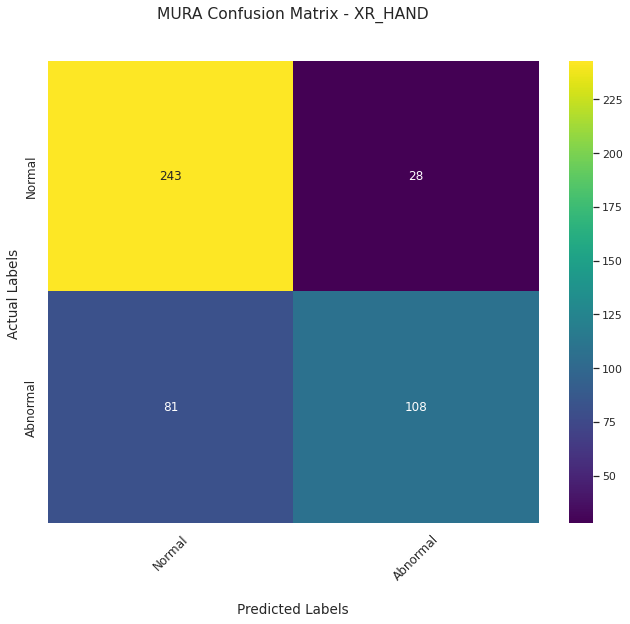




Found 288 validated image filenames belonging to 2 classes.


XR_HUMERUS


Metrics for the test set:
loss        : 0.5157217383384705
f1          : 0.4861283302307129
pr_auc      : 0.8651962280273438
roc_auc     : 0.8748552203178406
precision   : 0.8201438784599304
recall      : 0.8142856955528259
binary_acc  : 0.8229166865348816
tp          : 114.0
fp          : 25.0
tn          : 123.0
fn          : 26.0
cohen_kappa : 0.6454914212226868

Precision, recall, F1 scores for each class(test set)
              precision    recall  f1-score   support

      Normal       0.81      0.81      0.81       148
    Abnormal       0.80      0.79      0.80       140

    accuracy                           0.80       288
   macro avg       0.80      0.80      0.80       288
weighted avg       0.80      0.80      0.80       288


Precision Recall AUC score for the normal class(test set):
0.8552976900275793

Precision Recall AUC score for the abnormal class(test set):
0.8599689416465817

Macro-avera

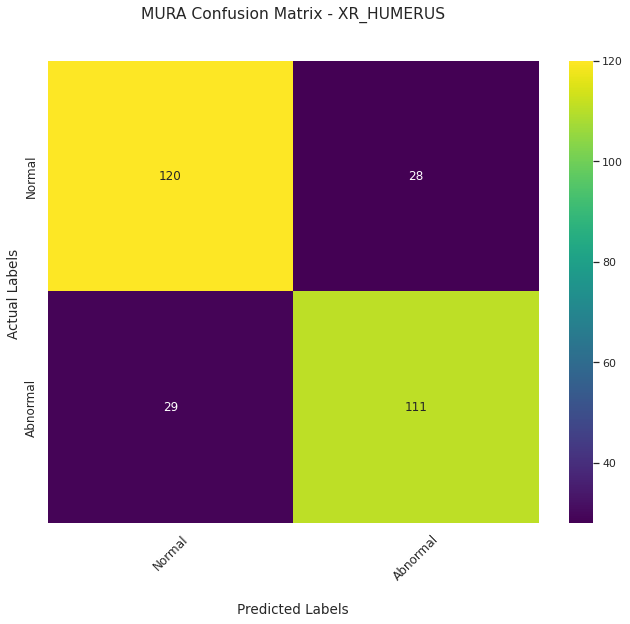




Found 563 validated image filenames belonging to 2 classes.


XR_SHOULDER


Metrics for the test set:
loss        : 0.5723248720169067
f1          : 0.46661537885665894
pr_auc      : 0.8342081904411316
roc_auc     : 0.8234506845474243
precision   : 0.7370370626449585
recall      : 0.7158273458480835
binary_acc  : 0.7335701584815979
tp          : 199.0
fp          : 71.0
tn          : 214.0
fn          : 79.0
cohen_kappa : 0.4668695330619812

Precision, recall, F1 scores for each class(test set)
              precision    recall  f1-score   support

      Normal       0.74      0.78      0.76       285
    Abnormal       0.76      0.72      0.74       278

    accuracy                           0.75       563
   macro avg       0.75      0.75      0.75       563
weighted avg       0.75      0.75      0.75       563


Precision Recall AUC score for the normal class(test set):
0.8040211620307145

Precision Recall AUC score for the abnormal class(test set):
0.8517576002341785

Macro-ave

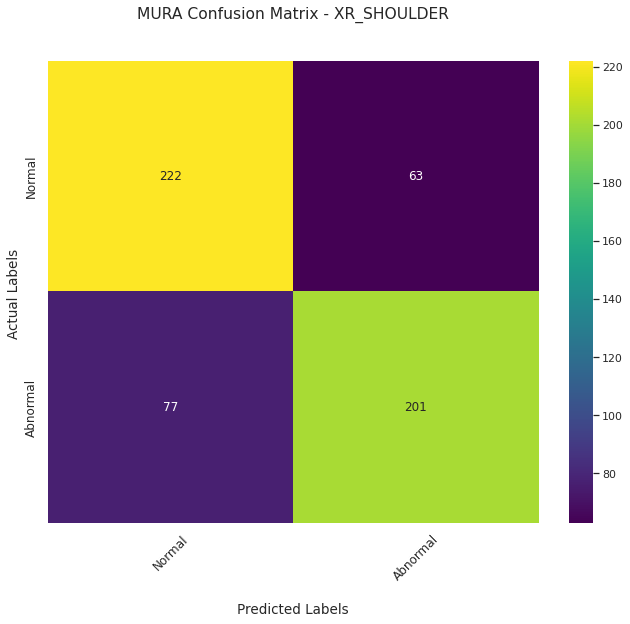




Found 659 validated image filenames belonging to 2 classes.


XR_WRIST  


Metrics for the test set:
loss        : 0.504831850528717
f1          : 0.40452030301094055
pr_auc      : 0.8622860312461853
roc_auc     : 0.8668699264526367
precision   : 0.8100775480270386
recall      : 0.7084745764732361
binary_acc  : 0.7951441407203674
tp          : 209.0
fp          : 49.0
tn          : 315.0
fn          : 86.0
cohen_kappa : 0.5807631015777588

Precision, recall, F1 scores for each class(test set)
              precision    recall  f1-score   support

      Normal       0.81      0.87      0.84       364
    Abnormal       0.83      0.74      0.78       295

    accuracy                           0.81       659
   macro avg       0.82      0.81      0.81       659
weighted avg       0.82      0.81      0.81       659


Precision Recall AUC score for the normal class(test set):
0.8759709750105095

Precision Recall AUC score for the abnormal class(test set):
0.8762916953692739

Macro-avera

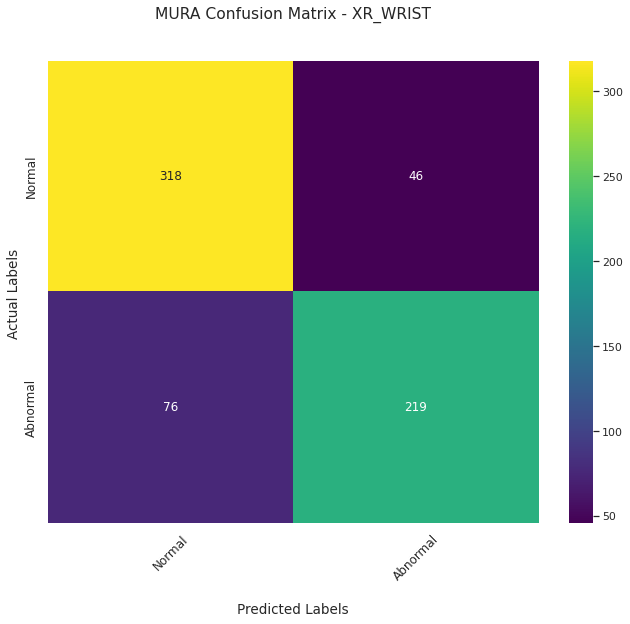

In [ ]:
report(test, 'test', 'rgb', MURA_ResNet50_same, datagen_same_for_all, chosen_metrics)

#### DensetNet169 with the same rotation of ALL sets

In [ ]:
callbacks = [ReduceLROnPlateau(monitor="val_loss", patience=2, cooldown=2), 
        EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=5, restore_best_weights=True)]
                                                                          # If False, the model weights obtained at the last step of training are used.
                                                                          # else, restores weights from the best epoch in that set.

In [ ]:
datagen = ImageDataGenerator(rescale=1/255, rotation_range=30,preprocessing_function=tf.keras.applications.densenet.preprocess_input)

train_generator = datagen.flow_from_dataframe(dataframe=train, directory=None,
                                              x_col="Paths", y_col="Label",         # 1_hot_labels and categorical
                                              target_size=(224,224), class_mode="binary",
                                              batch_size=32, shuffle=True, color_mode = "rgb", seed=11, fill_mode='constant',
                                              )

dev_generator = datagen.flow_from_dataframe(dataframe=dev, directory=None,
                                              x_col="Paths", y_col="Label",
                                              target_size=(224,224), class_mode="binary",
                                              batch_size=32, shuffle=False, color_mode = "rgb", seed=11, fill_mode='constant',
                                              )

test_generator = datagen.flow_from_dataframe(dataframe=test, directory=None,
                                              x_col="Paths", y_col="Label",
                                              target_size=(224,224), class_mode="binary",
                                              batch_size=32, shuffle=False, color_mode = "rgb", seed=11, fill_mode='constant',
                                             )

Found 29446 validated image filenames belonging to 2 classes.
Found 7362 validated image filenames belonging to 2 classes.
Found 3197 validated image filenames belonging to 2 classes.


In [ ]:
def train_densenet_model(
        upper_layers_epochs,
        full_network_epochs,
        mlp_hidden_layers,
        mlp_hidden_activation,
        callbacks):
    
    np.random.seed(1234) # Define the seed for numpy to have reproducible experiments.
    set_seed(1234) # Define the seed for Tensorflow to have reproducible experiments.

    # input = Input(shape = (224,224,3), name='input')
    # example of loading the resnet50 model
    # load model
    densenet = DenseNet169(
    include_top=False,  # do not include the fully-connected layer at the top of the network
    weights="imagenet",
    pooling="max",  # pooling mode for feature extraction
    ) # input_tensor=input,
    # max pooling because we want to emphasize the characteristics extracted (make them sharp)

    x = densenet.output
    #Define MLP layers.
    for i, units in enumerate(mlp_hidden_layers):
        x = Dense(
            units=units,
            kernel_initializer='glorot_uniform',
            activation=mlp_hidden_activation,
            name='Hidden-{0:d}'.format(i + 1)
        )(x)
        x = Dropout(rate=0.2)(x)
   
    
    # Define the output layer.
    output = Dense(
        units=1,
        activation="sigmoid",
        name='Output'
    )(x)

    # Define the model and train it.
    model = Model(inputs = densenet.input, outputs = output)

    #Freeze the resnet model
    #First train the upper layers for a few epochs
    
    for layer in densenet.layers:
        layer.trainable = False

    model.compile(optimizer = 'Adam',
              loss='binary_crossentropy', 
              metrics=chosen_metrics)
    
    hist_upper_layers = model.fit(train_generator, 
                                epochs=upper_layers_epochs, 
                                callbacks=callbacks, 
                                validation_data=dev_generator, 
                                batch_size = 32,
                                verbose=1
                                )
       
    print('Finished training upper layers.')
    print('------------------')

    #Unfreeze the resnet model and train the whole network with a low learning rate

    for layer in densenet.layers:
        layer.trainable = True
    
    model.compile(optimizer = keras.optimizers.Adam(learning_rate=1e-5), #use a very small learning rate.
              loss='binary_crossentropy', metrics=chosen_metrics)

    hist_full_network = model.fit(train_generator, 
                                epochs=full_network_epochs, 
                                callbacks=callbacks, 
                                validation_data=dev_generator, 
                                batch_size = 32,
                                verbose=1
                                )
       
    print('Finished training full network.')
    print('------------------')

    model.summary() 
    return model, hist_upper_layers, hist_full_network

In [ ]:
densenet_model, h_res_upper, h_res_full = train_densenet_model(upper_layers_epochs=5,
                                                full_network_epochs=15,
                                                mlp_hidden_layers=[512],#one hidden layers
                                                mlp_hidden_activation=ELU(alpha=0.2),
                                                callbacks=callbacks)

Epoch 1/5
921/921 [==============================] - 632s 669ms/step - loss: 0.6971 - pr_auc: 0.4317 - roc_auc: 0.5366 - precision: 0.4479 - recall: 0.1594 - binary_acc: 0.5810 - tp: 1897.0000 - fp: 2338.0000 - tn: 15210.0000 - fn: 10001.0000 - cohen_kappa: 0.0292 - f1: 0.1657 - val_loss: 0.6640 - val_pr_auc: 0.4925 - val_roc_auc: 0.6013 - val_precision: 0.7885 - val_recall: 0.0138 - val_binary_acc: 0.6000 - val_tp: 41.0000 - val_fp: 11.0000 - val_tn: 4376.0000 - val_fn: 2934.0000 - val_cohen_kappa: 0.0134 - val_f1: 0.0241 - lr: 0.0010
Epoch 2/5
921/921 [==============================] - 602s 654ms/step - loss: 0.6680 - pr_auc: 0.4542 - roc_auc: 0.5623 - precision: 0.4729 - recall: 0.1407 - binary_acc: 0.5894 - tp: 1674.0000 - fp: 1866.0000 - tn: 15682.0000 - fn: 10224.0000 - cohen_kappa: 0.0387 - f1: 0.1545 - val_loss: 0.6594 - val_pr_auc: 0.4908 - val_roc_auc: 0.5950 - val_precision: 0.7872 - val_recall: 0.0124 - val_binary_acc: 0.5996 - val_tp: 37.0000 - val_fp: 10.0000 - val_tn: 43

In [ ]:
# !mkdir -p saved_model
# densenet_model.save('saved_model/MURA_densenet_model_new')

# with open('MURA_DenseNet_model_history_dict_new_upper.pkl', 'wb') as file_pi:
#         pickle.dump(h_res_upper, file_pi, pickle.HIGHEST_PROTOCOL)
# with open('MURA_DenseNet_model_history_dict_new_full.pkl', 'wb') as file_pi:
#         pickle.dump(h_res_full, file_pi, pickle.HIGHEST_PROTOCOL)

In [ ]:
# MURA_DenseNet169 = load_model('saved_model/MURA_densenet_model_new', custom_objects={'f1':f1})

# with keras.utils.custom_object_scope({"f1": f1}):
#   with open('MURA_DenseNet_model_history_dict_new_upper.pkl', 'rb') as file:
#     Dense_MURA_upper = pickle.load(file)

# with keras.utils.custom_object_scope({"f1": f1}):
#   with open('MURA_DenseNet_model_history_dict_new_full.pkl', 'rb') as file:
#     Dense_MURA_full = pickle.load(file)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.562379 to fit



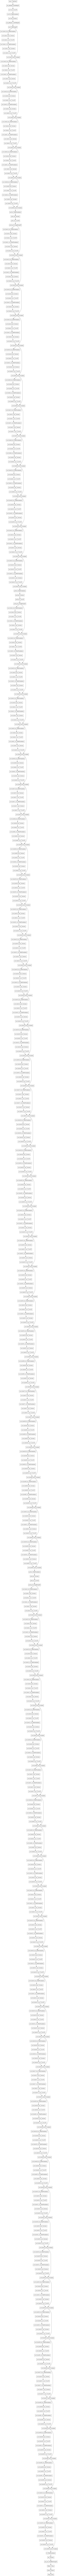

In [ ]:
tf.keras.utils.plot_model(MURA_DenseNet169)

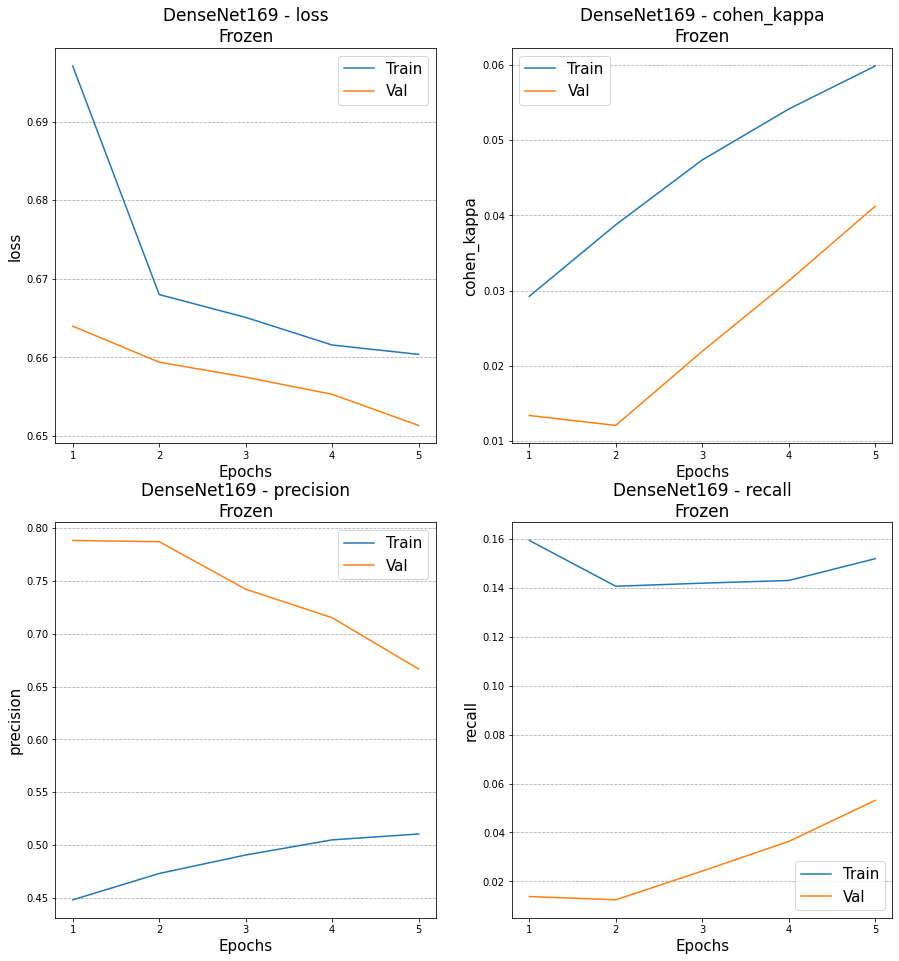

In [ ]:
plot_learning_curves(Dense_MURA_upper.history, ['Train', 'Val'], '\nFrozen', 'DenseNet169 - ')

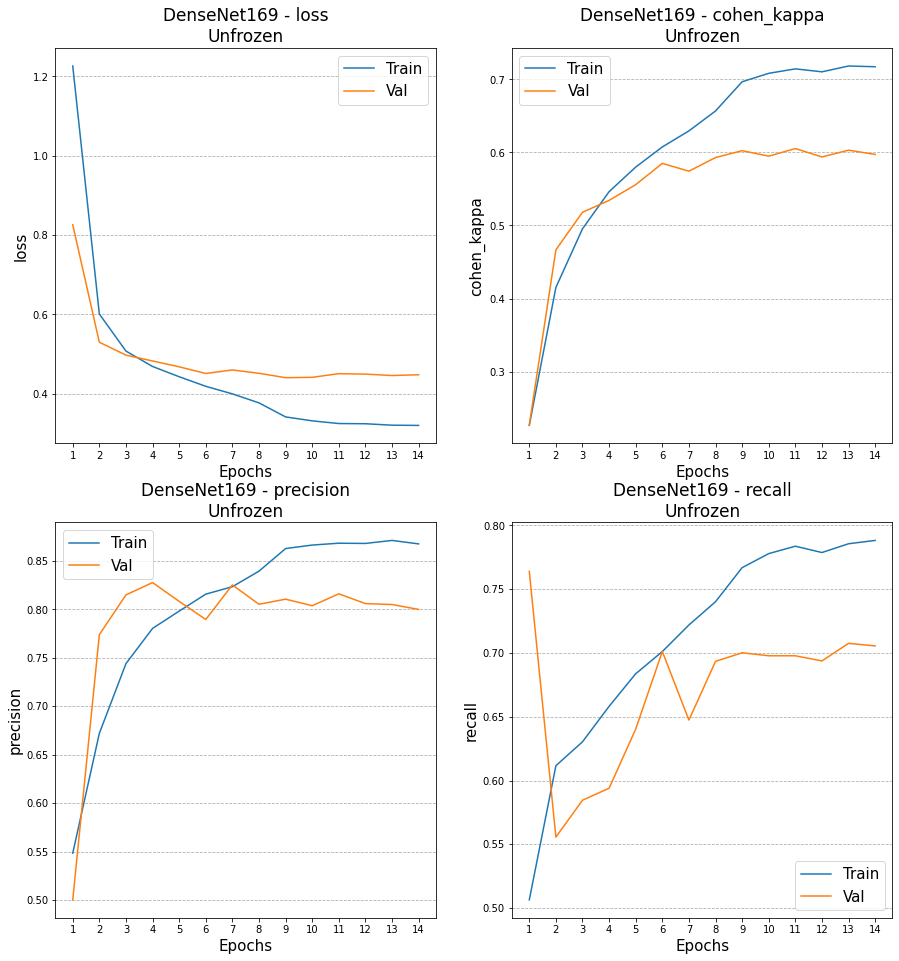

In [ ]:
plot_learning_curves(Dense_MURA_full.history, ['Train', 'Val'], '\nUnfrozen', 'DenseNet169 - ')

In [ ]:
eval_metrics([MURA_DenseNet169], [train_generator], ['train'], chosen_metrics, False)

Metrics for the train set:
loss        : 0.3052501082420349
f1          : 0.8247694969177246
pr_auc      : 0.9258275032043457
roc_auc     : 0.9381667375564575
precision   : 0.8848852515220642
recall      : 0.7843335270881653
binary_acc  : 0.8716294169425964
tp          : 9332.0
fp          : 1214.0
tn          : 16334.0
fn          : 2566.0
cohen_kappa : 0.7284780740737915


Metrics for the development set:
loss        : 0.43991994857788086
f1          : 0.7399377226829529
pr_auc      : 0.8469424843788147
roc_auc     : 0.8712266683578491
precision   : 0.8076175451278687
recall      : 0.698487401008606
binary_acc  : 0.8109209537506104
tp          : 2078.0
fp          : 495.0
tn          : 3892.0
fn          : 897.0
cohen_kappa : 0.5986726880073547


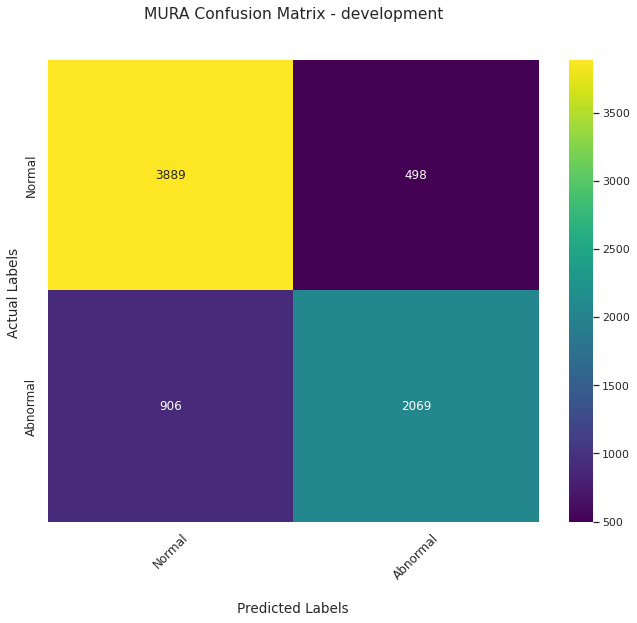

In [ ]:
eval_metrics([MURA_DenseNet169], [dev_generator], ['development'], chosen_metrics, True)

Metrics for the test set:
loss        : 0.49504590034484863
f1          : 0.4525482952594757
pr_auc      : 0.8637577891349792
roc_auc     : 0.8555094599723816
precision   : 0.8278816342353821
recall      : 0.6947712302207947
binary_acc  : 0.784798264503479
tp          : 1063.0
fp          : 221.0
tn          : 1446.0
fn          : 467.0
cohen_kappa : 0.5659368634223938


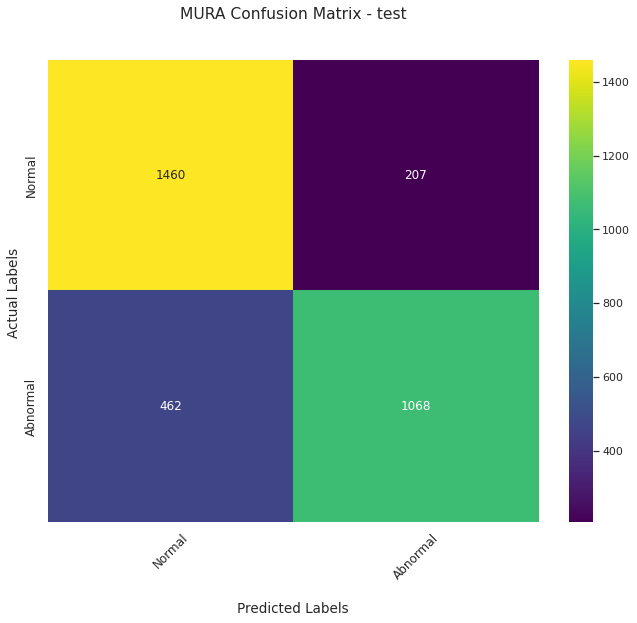

In [ ]:
eval_metrics([MURA_DenseNet169], [test_generator], ['test'], chosen_metrics, True)

Found 3945 validated image filenames belonging to 2 classes.


XR_ELBOW  


Metrics for the train set:
loss        : 0.2926415205001831
f1          : 0.8442890644073486
pr_auc      : 0.9330694675445557
roc_auc     : 0.941308319568634
precision   : 0.9148471355438232
recall      : 0.7831775546073914
binary_acc  : 0.8821292519569397
tp          : 1257.0
fp          : 117.0
tn          : 2223.0
fn          : 348.0
cohen_kappa : 0.7501333355903625

Precision, recall, F1 scores for each class(train set)
              precision    recall  f1-score   support

      Normal       0.87      0.96      0.91      2340
    Abnormal       0.93      0.79      0.85      1605

    accuracy                           0.89      3945
   macro avg       0.90      0.87      0.88      3945
weighted avg       0.89      0.89      0.88      3945


Precision Recall AUC score for the normal class(train set):
0.9525686098278716

Precision Recall AUC score for the abnormal class(train set):
0.9350107354034861

Macro-

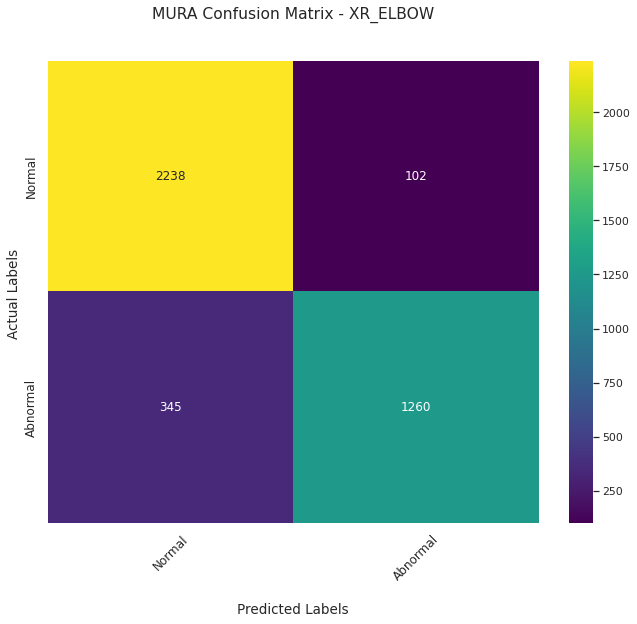




Found 4084 validated image filenames belonging to 2 classes.


XR_FINGER 


Metrics for the train set:
loss        : 0.2980363667011261
f1          : 0.8249547481536865
pr_auc      : 0.924712061882019
roc_auc     : 0.9411413669586182
precision   : 0.8805755376815796
recall      : 0.7776365876197815
binary_acc  : 0.8736532926559448
tp          : 1224.0
fp          : 166.0
tn          : 2344.0
fn          : 350.0
cohen_kappa : 0.727354884147644

Precision, recall, F1 scores for each class(train set)
              precision    recall  f1-score   support

      Normal       0.87      0.94      0.90      2510
    Abnormal       0.89      0.77      0.82      1574

    accuracy                           0.87      4084
   macro avg       0.88      0.85      0.86      4084
weighted avg       0.88      0.87      0.87      4084


Precision Recall AUC score for the normal class(train set):
0.9599023875079844

Precision Recall AUC score for the abnormal class(train set):
0.9250830035504444

Macr

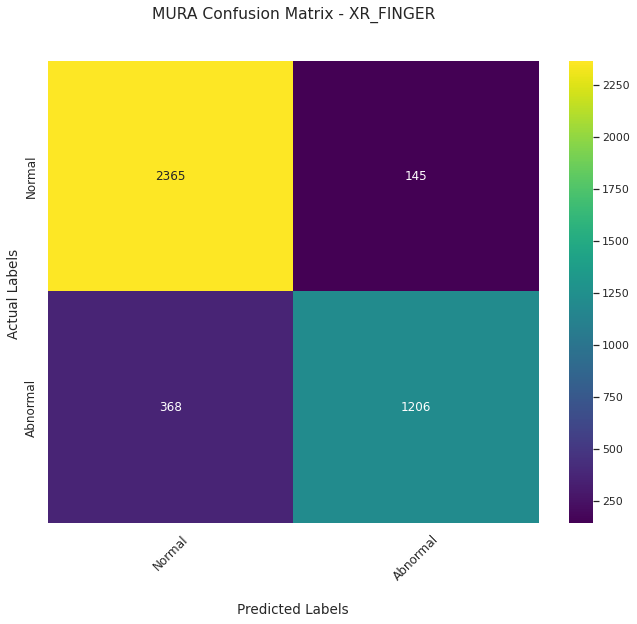




Found 1460 validated image filenames belonging to 2 classes.


XR_FOREARM


Metrics for the train set:
loss        : 0.24864605069160461
f1          : 0.8504074215888977
pr_auc      : 0.9390919208526611
roc_auc     : 0.9544333815574646
precision   : 0.9271523356437683
recall      : 0.7939508557319641
binary_acc  : 0.9027397036552429
tp          : 420.0
fp          : 33.0
tn          : 898.0
fn          : 109.0
cohen_kappa : 0.7827849984169006

Precision, recall, F1 scores for each class(train set)
              precision    recall  f1-score   support

      Normal       0.89      0.96      0.93       931
    Abnormal       0.93      0.79      0.85       529

    accuracy                           0.90      1460
   macro avg       0.91      0.88      0.89      1460
weighted avg       0.90      0.90      0.90      1460


Precision Recall AUC score for the normal class(train set):
0.96871962951719

Precision Recall AUC score for the abnormal class(train set):
0.9344552672435337

Macro-

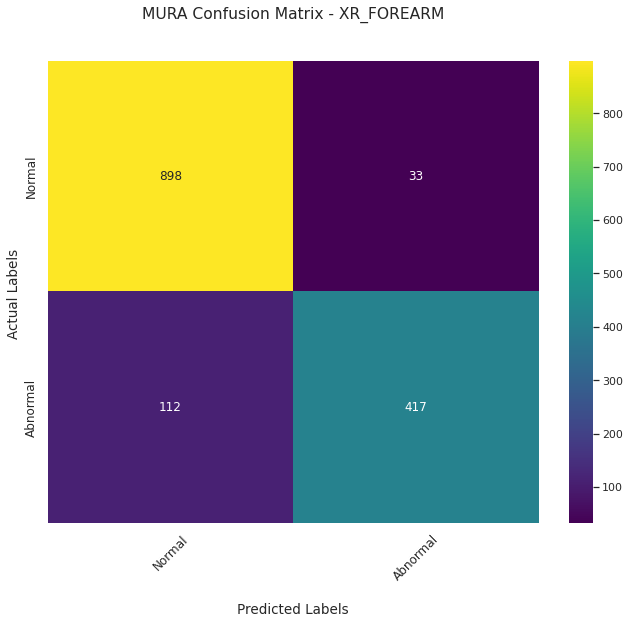




Found 4434 validated image filenames belonging to 2 classes.


XR_HAND   


Metrics for the train set:
loss        : 0.33746516704559326
f1          : 0.6937796473503113
pr_auc      : 0.8171545267105103
roc_auc     : 0.8972175121307373
precision   : 0.854523241519928
recall      : 0.5888795256614685
binary_acc  : 0.8631032705307007
tp          : 699.0
fp          : 119.0
tn          : 3128.0
fn          : 488.0
cohen_kappa : 0.6126445531845093

Precision, recall, F1 scores for each class(train set)
              precision    recall  f1-score   support

      Normal       0.86      0.96      0.91      3247
    Abnormal       0.85      0.58      0.69      1187

    accuracy                           0.86      4434
   macro avg       0.86      0.77      0.80      4434
weighted avg       0.86      0.86      0.85      4434


Precision Recall AUC score for the normal class(train set):
0.950735023347621

Precision Recall AUC score for the abnormal class(train set):
0.8182720660485362

Macr

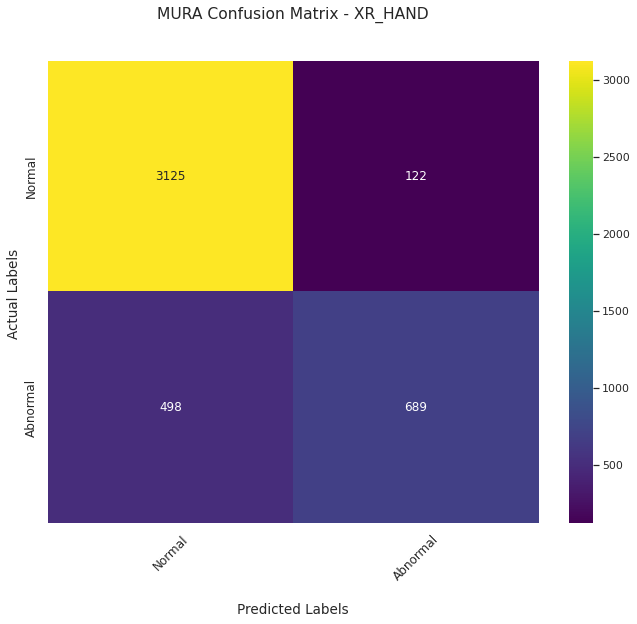




Found 1018 validated image filenames belonging to 2 classes.


XR_HUMERUS


Metrics for the train set:
loss        : 0.27073583006858826
f1          : 0.8820552229881287
pr_auc      : 0.951543390750885
roc_auc     : 0.9573225378990173
precision   : 0.8912580013275146
recall      : 0.8726513385772705
binary_acc  : 0.8899803757667542
tp          : 418.0
fp          : 51.0
tn          : 488.0
fn          : 61.0
cohen_kappa : 0.7789368033409119

Precision, recall, F1 scores for each class(train set)
              precision    recall  f1-score   support

      Normal       0.89      0.91      0.90       539
    Abnormal       0.90      0.87      0.88       479

    accuracy                           0.89      1018
   macro avg       0.89      0.89      0.89      1018
weighted avg       0.89      0.89      0.89      1018


Precision Recall AUC score for the normal class(train set):
0.9549833826397659

Precision Recall AUC score for the abnormal class(train set):
0.9483772820082373

Macro-

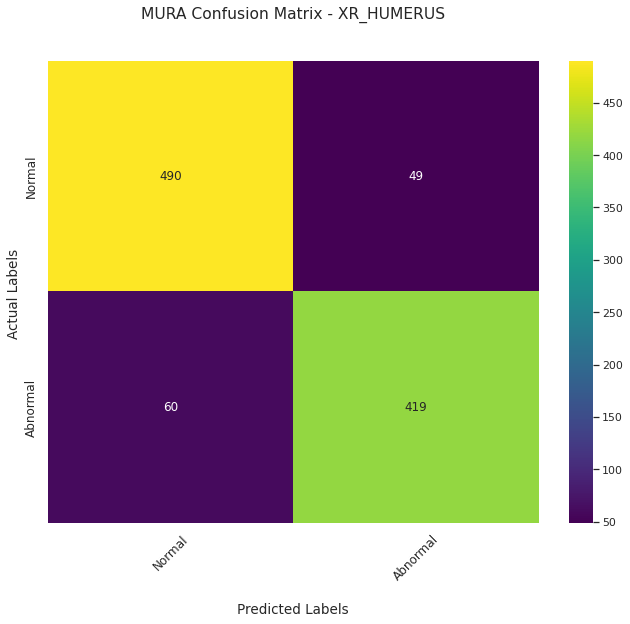




Found 6703 validated image filenames belonging to 2 classes.


XR_SHOULDER


Metrics for the train set:
loss        : 0.3473109304904938
f1          : 0.8421856164932251
pr_auc      : 0.9317572712898254
roc_auc     : 0.926019012928009
precision   : 0.8660995364189148
recall      : 0.824535071849823
binary_acc  : 0.849321186542511
tp          : 2749.0
fp          : 425.0
tn          : 2944.0
fn          : 585.0
cohen_kappa : 0.698559045791626

Precision, recall, F1 scores for each class(train set)
              precision    recall  f1-score   support

      Normal       0.84      0.87      0.85      3369
    Abnormal       0.86      0.83      0.84      3334

    accuracy                           0.85      6703
   macro avg       0.85      0.85      0.85      6703
weighted avg       0.85      0.85      0.85      6703


Precision Recall AUC score for the normal class(train set):
0.9208784496693678

Precision Recall AUC score for the abnormal class(train set):
0.9300833077105429

Macro

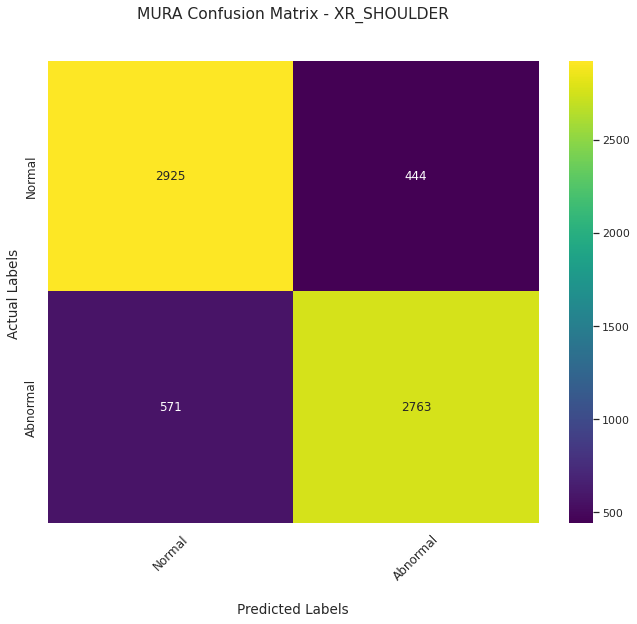




Found 7802 validated image filenames belonging to 2 classes.


XR_WRIST  


Metrics for the train set:
loss        : 0.2720779478549957
f1          : 0.8566522002220154
pr_auc      : 0.9427241086959839
roc_auc     : 0.9494684338569641
precision   : 0.9161037802696228
recall      : 0.8078370094299316
binary_acc  : 0.8911817669868469
tp          : 2577.0
fp          : 236.0
tn          : 4376.0
fn          : 613.0
cohen_kappa : 0.770707905292511

Precision, recall, F1 scores for each class(train set)
              precision    recall  f1-score   support

      Normal       0.88      0.95      0.91      4612
    Abnormal       0.91      0.81      0.86      3190

    accuracy                           0.89      7802
   macro avg       0.90      0.88      0.88      7802
weighted avg       0.89      0.89      0.89      7802


Precision Recall AUC score for the normal class(train set):
0.958156070919939

Precision Recall AUC score for the abnormal class(train set):
0.9418535029671141

Macr

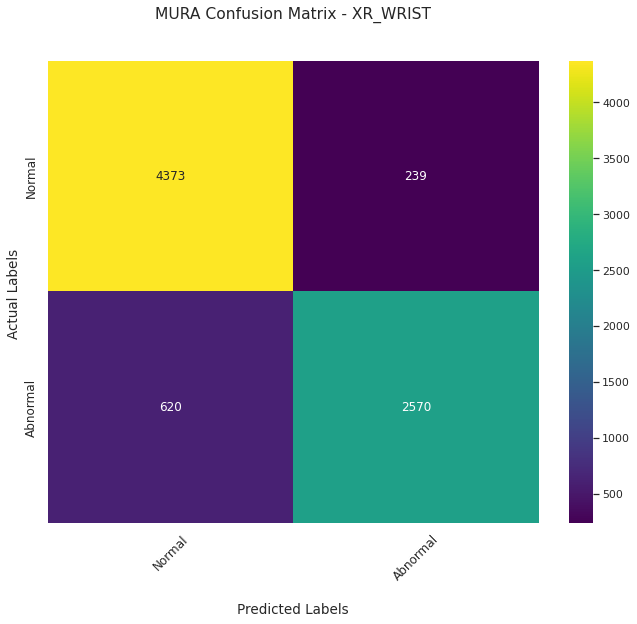

In [ ]:
report(train, 'train', 'rgb', MURA_DenseNet169, datagen, chosen_metrics)

Found 986 validated image filenames belonging to 2 classes.


XR_ELBOW  


Metrics for the dev set:
loss        : 0.4161354899406433
f1          : 0.7647508382797241
pr_auc      : 0.8681408166885376
roc_auc     : 0.8751518726348877
precision   : 0.8501529097557068
recall      : 0.6932668089866638
binary_acc  : 0.8255578279495239
tp          : 278.0
fp          : 49.0
tn          : 536.0
fn          : 123.0
cohen_kappa : 0.6277235746383667

Precision, recall, F1 scores for each class(dev set)
              precision    recall  f1-score   support

      Normal       0.81      0.91      0.86       585
    Abnormal       0.84      0.69      0.76       401

    accuracy                           0.82       986
   macro avg       0.83      0.80      0.81       986
weighted avg       0.82      0.82      0.82       986


Precision Recall AUC score for the normal class(dev set):
0.8895656236594316

Precision Recall AUC score for the abnormal class(dev set):
0.8670873678479656

Macro-averaged Pr

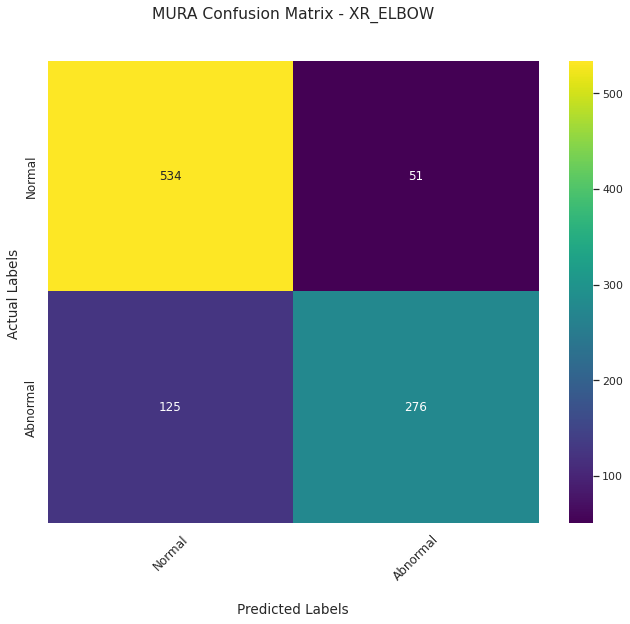




Found 1022 validated image filenames belonging to 2 classes.


XR_FINGER 


Metrics for the dev set:
loss        : 0.5036678910255432
f1          : 0.6949976682662964
pr_auc      : 0.7888655662536621
roc_auc     : 0.8466204404830933
precision   : 0.7798742055892944
recall      : 0.6294416189193726
binary_acc  : 0.7886496782302856
tp          : 248.0
fp          : 70.0
tn          : 558.0
fn          : 146.0
cohen_kappa : 0.5372851490974426

Precision, recall, F1 scores for each class(dev set)
              precision    recall  f1-score   support

      Normal       0.79      0.87      0.83       628
    Abnormal       0.76      0.63      0.69       394

    accuracy                           0.78      1022
   macro avg       0.77      0.75      0.76      1022
weighted avg       0.78      0.78      0.78      1022


Precision Recall AUC score for the normal class(dev set):
0.8710429612938199

Precision Recall AUC score for the abnormal class(dev set):
0.7870755709712824

Macro-average

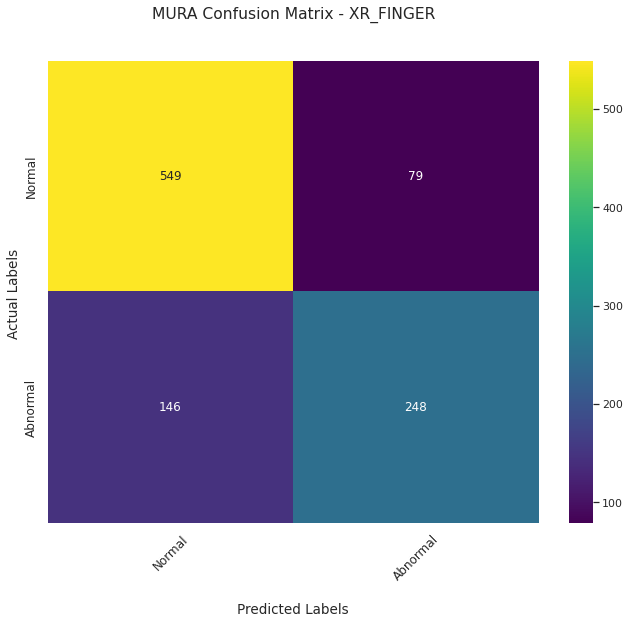




Found 365 validated image filenames belonging to 2 classes.


XR_FOREARM


Metrics for the dev set:
loss        : 0.4631688892841339
f1          : 0.7639581561088562
pr_auc      : 0.7953213453292847
roc_auc     : 0.8584828972816467
precision   : 0.8584905862808228
recall      : 0.689393937587738
binary_acc  : 0.8465753197669983
tp          : 91.0
fp          : 15.0
tn          : 218.0
fn          : 41.0
cohen_kappa : 0.6528886556625366

Precision, recall, F1 scores for each class(dev set)
              precision    recall  f1-score   support

      Normal       0.85      0.93      0.89       233
    Abnormal       0.86      0.72      0.78       132

    accuracy                           0.85       365
   macro avg       0.86      0.83      0.84       365
weighted avg       0.85      0.85      0.85       365


Precision Recall AUC score for the normal class(dev set):
0.872969564563081

Precision Recall AUC score for the abnormal class(dev set):
0.7884628285432903

Macro-averaged Pre

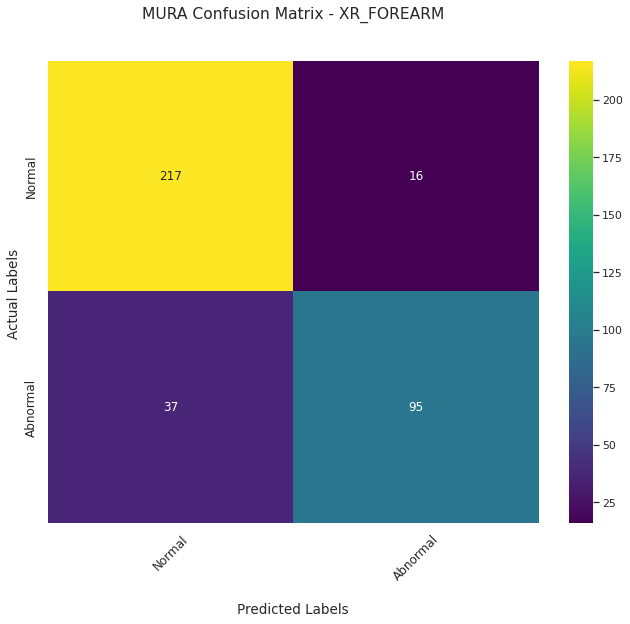




Found 1109 validated image filenames belonging to 2 classes.


XR_HAND   


Metrics for the dev set:
loss        : 0.4924013018608093
f1          : 0.5306565761566162
pr_auc      : 0.6148843765258789
roc_auc     : 0.7738053202629089
precision   : 0.6476190686225891
recall      : 0.4579124450683594
binary_acc  : 0.7880973815917969
tp          : 136.0
fp          : 74.0
tn          : 738.0
fn          : 161.0
cohen_kappa : 0.40433990955352783

Precision, recall, F1 scores for each class(dev set)
              precision    recall  f1-score   support

      Normal       0.82      0.92      0.86       812
    Abnormal       0.66      0.45      0.53       297

    accuracy                           0.79      1109
   macro avg       0.74      0.68      0.70      1109
weighted avg       0.78      0.79      0.78      1109


Precision Recall AUC score for the normal class(dev set):
0.8687540403784448

Precision Recall AUC score for the abnormal class(dev set):
0.619834099951493

Macro-average

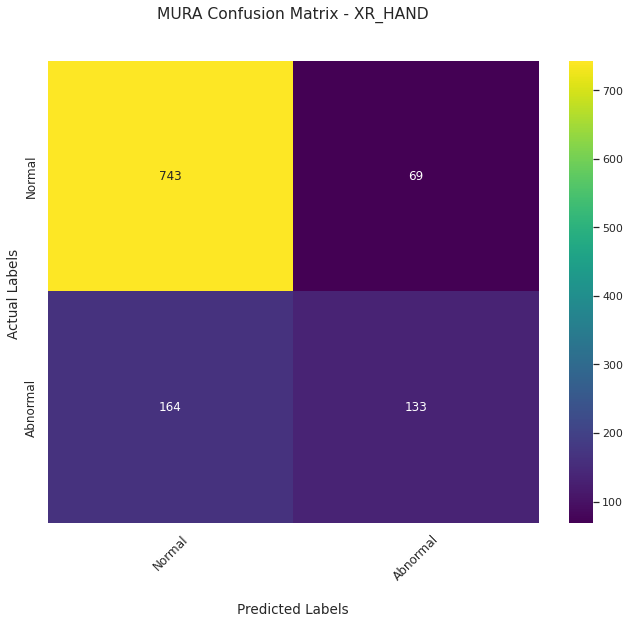




Found 254 validated image filenames belonging to 2 classes.


XR_HUMERUS


Metrics for the dev set:
loss        : 0.47493577003479004
f1          : 0.7805308699607849
pr_auc      : 0.86930912733078
roc_auc     : 0.8722636699676514
precision   : 0.8240740895271301
recall      : 0.7416666746139526
binary_acc  : 0.8031495809555054
tp          : 89.0
fp          : 19.0
tn          : 115.0
fn          : 31.0
cohen_kappa : 0.6030257940292358

Precision, recall, F1 scores for each class(dev set)
              precision    recall  f1-score   support

      Normal       0.80      0.84      0.82       134
    Abnormal       0.81      0.76      0.78       120

    accuracy                           0.80       254
   macro avg       0.80      0.80      0.80       254
weighted avg       0.80      0.80      0.80       254


Precision Recall AUC score for the normal class(dev set):
0.8692184193070608

Precision Recall AUC score for the abnormal class(dev set):
0.8559625212435198

Macro-averaged Pr

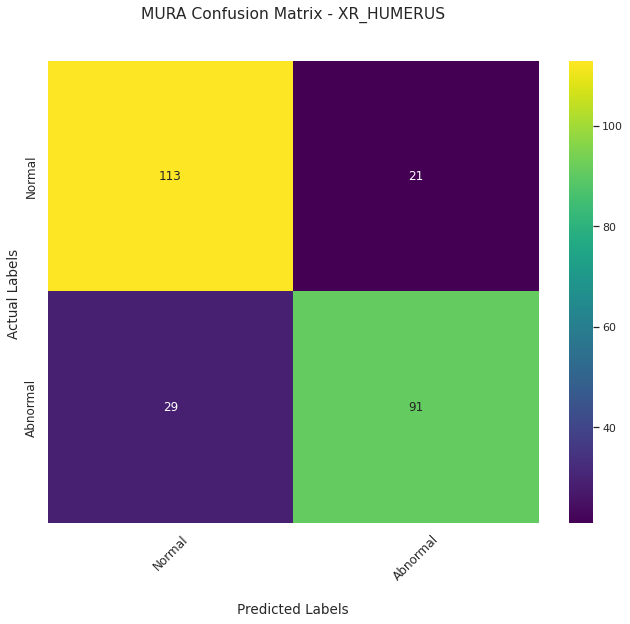




Found 1676 validated image filenames belonging to 2 classes.


XR_SHOULDER


Metrics for the dev set:
loss        : 0.4822539985179901
f1          : 0.7604978680610657
pr_auc      : 0.8611294627189636
roc_auc     : 0.8544090390205383
precision   : 0.794608473777771
recall      : 0.7422062158584595
binary_acc  : 0.7762529850006104
tp          : 619.0
fp          : 160.0
tn          : 682.0
fn          : 215.0
cohen_kappa : 0.5523555278778076

Precision, recall, F1 scores for each class(dev set)
              precision    recall  f1-score   support

      Normal       0.76      0.81      0.78       842
    Abnormal       0.79      0.75      0.77       834

    accuracy                           0.78      1676
   macro avg       0.78      0.78      0.78      1676
weighted avg       0.78      0.78      0.78      1676


Precision Recall AUC score for the normal class(dev set):
0.8334849490851057

Precision Recall AUC score for the abnormal class(dev set):
0.8691654156586848

Macro-averag

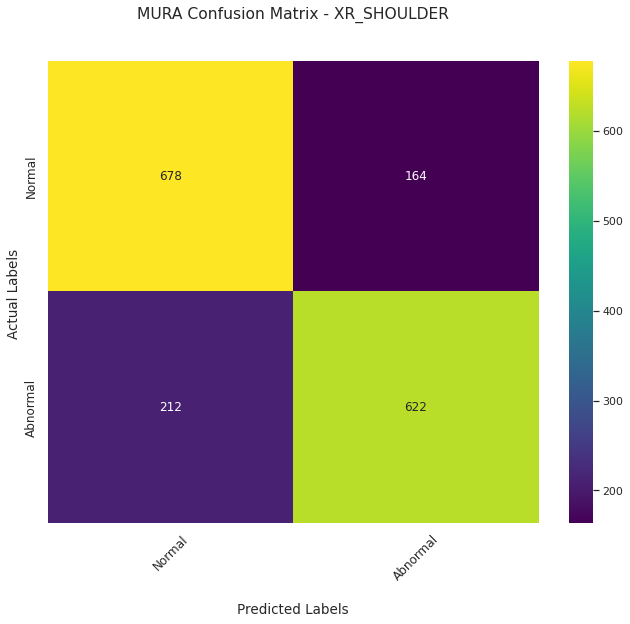




Found 1950 validated image filenames belonging to 2 classes.


XR_WRIST  


Metrics for the dev set:
loss        : 0.3684118986129761
f1          : 0.7963208556175232
pr_auc      : 0.8957189321517944
roc_auc     : 0.9068406224250793
precision   : 0.8310439586639404
recall      : 0.759096622467041
binary_acc  : 0.8384615182876587
tp          : 605.0
fp          : 123.0
tn          : 1030.0
fn          : 192.0
cohen_kappa : 0.6612563133239746

Precision, recall, F1 scores for each class(dev set)
              precision    recall  f1-score   support

      Normal       0.84      0.90      0.87      1153
    Abnormal       0.84      0.76      0.80       797

    accuracy                           0.84      1950
   macro avg       0.84      0.83      0.83      1950
weighted avg       0.84      0.84      0.84      1950


Precision Recall AUC score for the normal class(dev set):
0.9155014997296094

Precision Recall AUC score for the abnormal class(dev set):
0.8936430134608457

Macro-averag

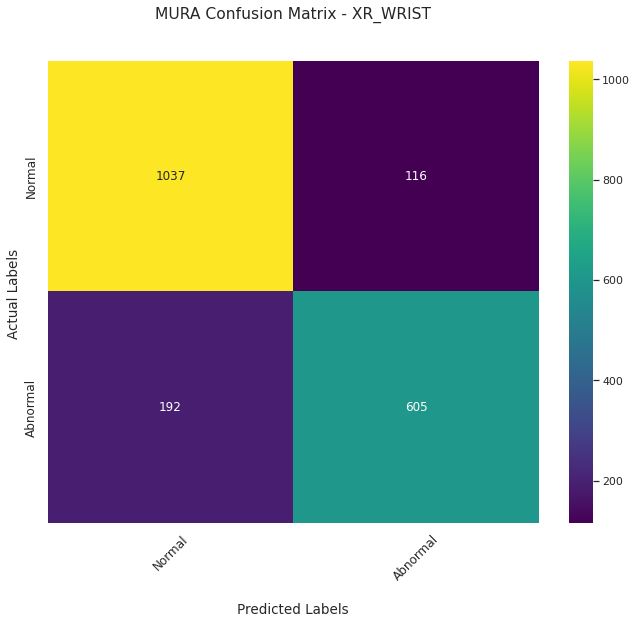

In [ ]:
report(dev, 'dev', 'rgb', MURA_DenseNet169, datagen, chosen_metrics)

Found 465 validated image filenames belonging to 2 classes.


XR_ELBOW  


Metrics for the test set:
loss        : 0.409588098526001
f1          : 0.4228883385658264
pr_auc      : 0.9073320031166077
roc_auc     : 0.8906660676002502
precision   : 0.8860103487968445
recall      : 0.7434782385826111
binary_acc  : 0.8258064389228821
tp          : 171.0
fp          : 22.0
tn          : 213.0
fn          : 59.0
cohen_kappa : 0.6509753465652466

Precision, recall, F1 scores for each class(test set)
              precision    recall  f1-score   support

      Normal       0.79      0.90      0.84       235
    Abnormal       0.88      0.76      0.81       230

    accuracy                           0.83       465
   macro avg       0.83      0.83      0.83       465
weighted avg       0.83      0.83      0.83       465


Precision Recall AUC score for the normal class(test set):
0.881457138180071

Precision Recall AUC score for the abnormal class(test set):
0.9038354348167972

Macro-averaged P

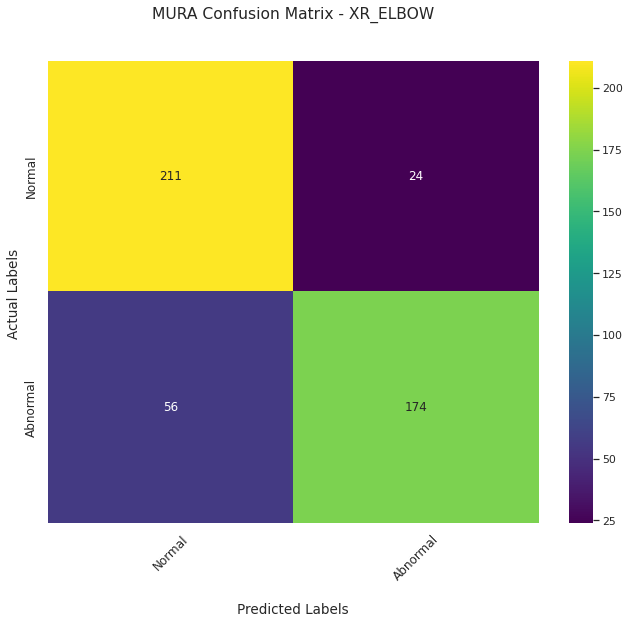




Found 461 validated image filenames belonging to 2 classes.


XR_FINGER 


Metrics for the test set:
loss        : 0.5658746957778931
f1          : 0.4353710114955902
pr_auc      : 0.8702044486999512
roc_auc     : 0.8324189186096191
precision   : 0.8402062058448792
recall      : 0.659919023513794
binary_acc  : 0.7505422830581665
tp          : 163.0
fp          : 31.0
tn          : 183.0
fn          : 84.0
cohen_kappa : 0.5066766738891602

Precision, recall, F1 scores for each class(test set)
              precision    recall  f1-score   support

      Normal       0.68      0.87      0.76       214
    Abnormal       0.85      0.64      0.73       247

    accuracy                           0.75       461
   macro avg       0.76      0.75      0.75       461
weighted avg       0.77      0.75      0.74       461


Precision Recall AUC score for the normal class(test set):
0.7660378480360921

Precision Recall AUC score for the abnormal class(test set):
0.8620028186234148

Macro-averag

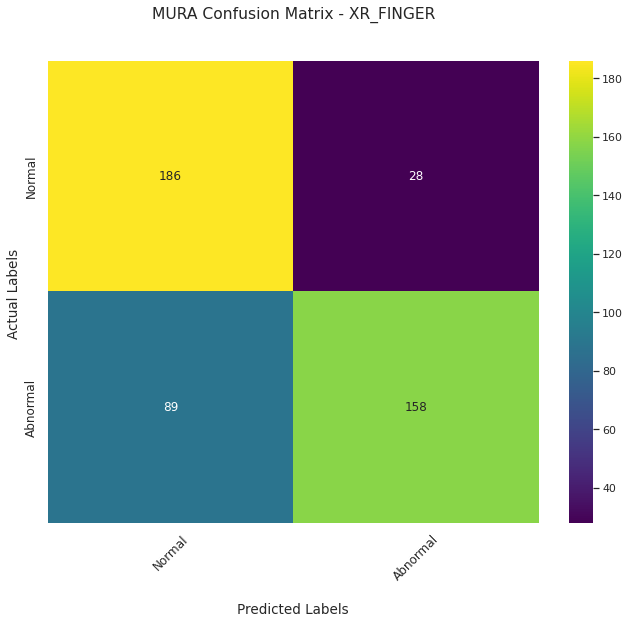




Found 301 validated image filenames belonging to 2 classes.


XR_FOREARM


Metrics for the test set:
loss        : 0.45014113187789917
f1          : 0.5384615063667297
pr_auc      : 0.9110704660415649
roc_auc     : 0.8885210156440735
precision   : 0.9051724076271057
recall      : 0.695364236831665
binary_acc  : 0.8106312155723572
tp          : 105.0
fp          : 11.0
tn          : 139.0
fn          : 46.0
cohen_kappa : 0.6215506792068481

Precision, recall, F1 scores for each class(test set)
              precision    recall  f1-score   support

      Normal       0.75      0.94      0.83       150
    Abnormal       0.92      0.69      0.79       151

    accuracy                           0.81       301
   macro avg       0.84      0.81      0.81       301
weighted avg       0.84      0.81      0.81       301


Precision Recall AUC score for the normal class(test set):
0.8519584149287696

Precision Recall AUC score for the abnormal class(test set):
0.9010510300917685

Macro-avera

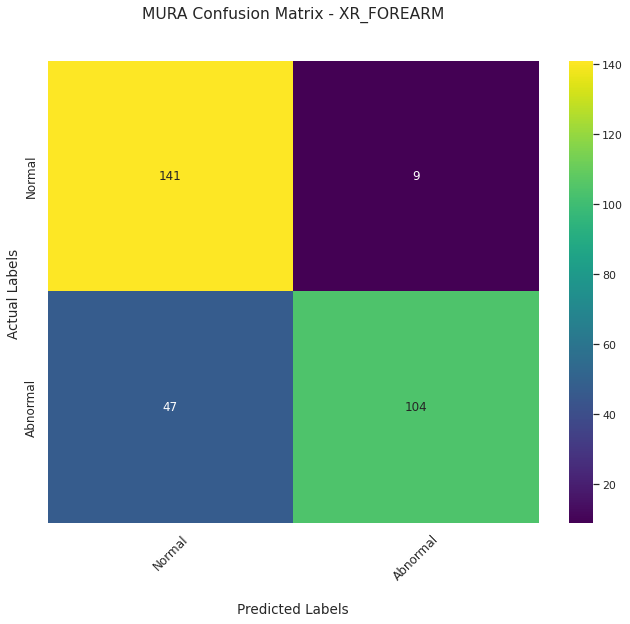




Found 460 validated image filenames belonging to 2 classes.


XR_HAND   


Metrics for the test set:
loss        : 0.5976001024246216
f1          : 0.3363471031188965
pr_auc      : 0.7575669288635254
roc_auc     : 0.784611165523529
precision   : 0.7952755689620972
recall      : 0.5343915224075317
binary_acc  : 0.752173900604248
tp          : 101.0
fp          : 26.0
tn          : 245.0
fn          : 88.0
cohen_kappa : 0.46134722232818604

Precision, recall, F1 scores for each class(test set)
              precision    recall  f1-score   support

      Normal       0.75      0.91      0.82       271
    Abnormal       0.82      0.57      0.67       189

    accuracy                           0.77       460
   macro avg       0.78      0.74      0.75       460
weighted avg       0.78      0.77      0.76       460


Precision Recall AUC score for the normal class(test set):
0.814174053636036

Precision Recall AUC score for the abnormal class(test set):
0.7916689912166657

Macro-average

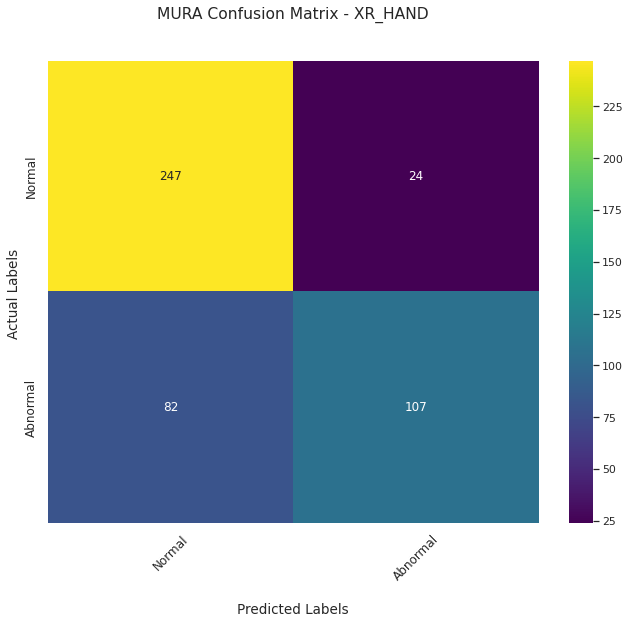




Found 288 validated image filenames belonging to 2 classes.


XR_HUMERUS


Metrics for the test set:
loss        : 0.4592492878437042
f1          : 0.5066103935241699
pr_auc      : 0.8565887212753296
roc_auc     : 0.8824324607849121
precision   : 0.8461538553237915
recall      : 0.8642857074737549
binary_acc  : 0.8576388955116272
tp          : 121.0
fp          : 22.0
tn          : 126.0
fn          : 19.0
cohen_kappa : 0.7152228355407715

Precision, recall, F1 scores for each class(test set)
              precision    recall  f1-score   support

      Normal       0.83      0.86      0.84       148
    Abnormal       0.85      0.81      0.83       140

    accuracy                           0.84       288
   macro avg       0.84      0.84      0.84       288
weighted avg       0.84      0.84      0.84       288


Precision Recall AUC score for the normal class(test set):
0.8550856605424436

Precision Recall AUC score for the abnormal class(test set):
0.8481063363770099

Macro-avera

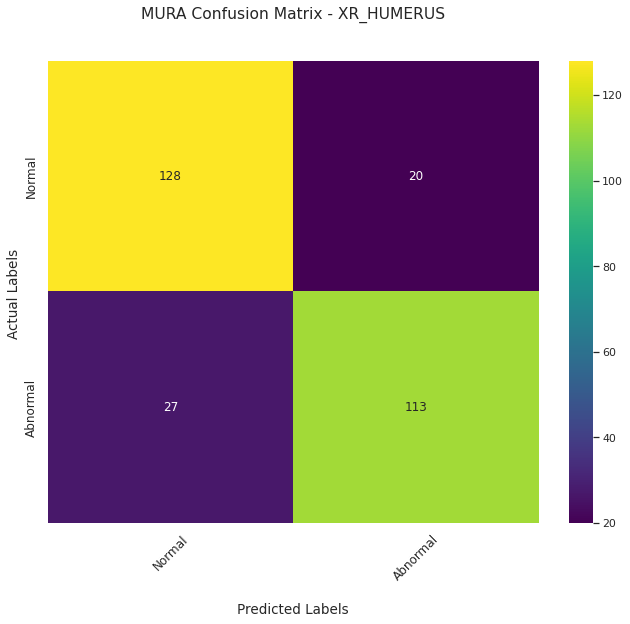




Found 563 validated image filenames belonging to 2 classes.


XR_SHOULDER


Metrics for the test set:
loss        : 0.523220419883728
f1          : 0.48721322417259216
pr_auc      : 0.8545051217079163
roc_auc     : 0.8317366242408752
precision   : 0.7562723755836487
recall      : 0.7589927911758423
binary_acc  : 0.7602131366729736
tp          : 211.0
fp          : 68.0
tn          : 217.0
fn          : 67.0
cohen_kappa : 0.5203733444213867

Precision, recall, F1 scores for each class(test set)
              precision    recall  f1-score   support

      Normal       0.75      0.73      0.74       285
    Abnormal       0.73      0.75      0.74       278

    accuracy                           0.74       563
   macro avg       0.74      0.74      0.74       563
weighted avg       0.74      0.74      0.74       563


Precision Recall AUC score for the normal class(test set):
0.7834289701286024

Precision Recall AUC score for the abnormal class(test set):
0.8405581230731336

Macro-aver

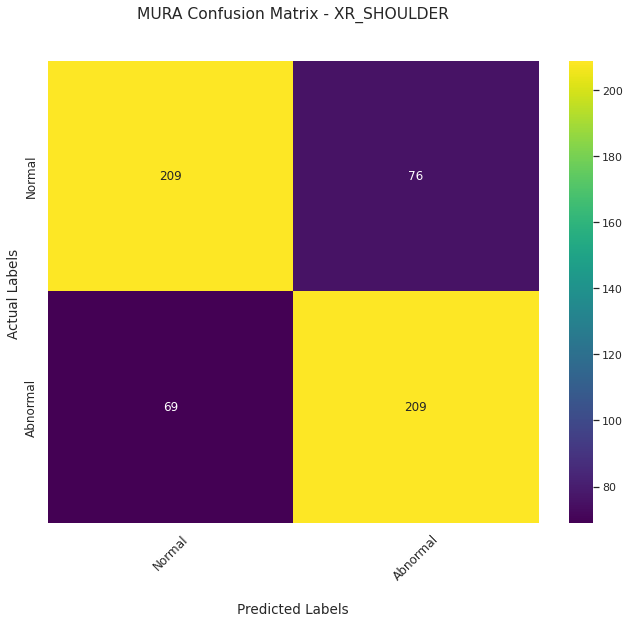




Found 659 validated image filenames belonging to 2 classes.


XR_WRIST  


Metrics for the test set:
loss        : 0.40133750438690186
f1          : 0.4133056700229645
pr_auc      : 0.892429530620575
roc_auc     : 0.8970385789871216
precision   : 0.8912134170532227
recall      : 0.7220339179039001
binary_acc  : 0.836115300655365
tp          : 213.0
fp          : 26.0
tn          : 338.0
fn          : 82.0
cohen_kappa : 0.6625256538391113

Precision, recall, F1 scores for each class(test set)
              precision    recall  f1-score   support

      Normal       0.80      0.93      0.86       364
    Abnormal       0.90      0.72      0.80       295

    accuracy                           0.84       659
   macro avg       0.85      0.82      0.83       659
weighted avg       0.84      0.84      0.83       659


Precision Recall AUC score for the normal class(test set):
0.8955774253786529

Precision Recall AUC score for the abnormal class(test set):
0.887651554762886

Macro-average

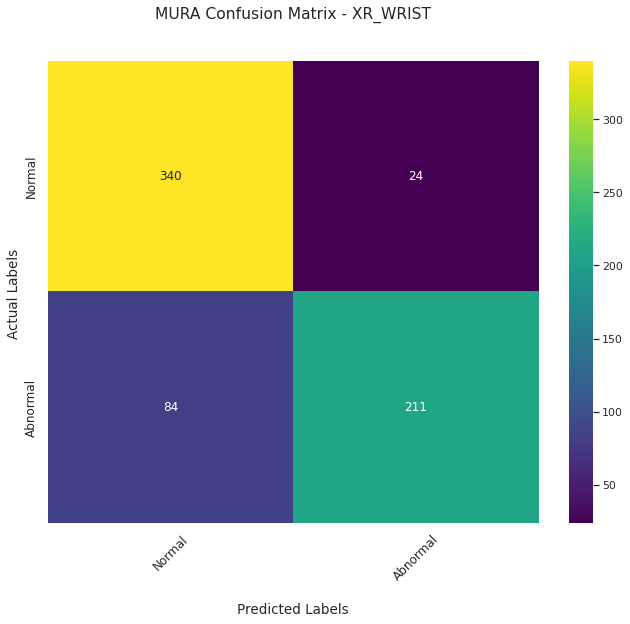

In [ ]:
report(test, 'test', 'rgb', MURA_DenseNet169, datagen, chosen_metrics)